In [36]:
import os

try:
    os.getcwd()
except OSError:
    os.chdir('/content')  # Répertoire de base valide dans Colab


## Daniel tests

Je teste RandomForest (et d'autres modeles).

J'ai testé KNN plus en bas, c'est bien aussi selon j'ai vu avec des NaN.

J'ai fait de la regression et pas de la classification (donc pas de accuracy, f1 score etc)

Pour après, je voulais simplifier la tache en une classification binaire car on a des scores médiocres à cause de la complexité et du **MANQUE** de données.

**Classification binaire** : On s'intéresse pas à combien une personne a donné comme valeur exacte à chaque individu. On les transforme en catégories.

- Si valueOneA > valueOneB → classe 1 (donne plus à A)

- Si valueOneA < valueOneB → classe 2 (donne plus à B)

- Si égalité → classe 3.

Exemple :

- Scénario perles
- Individu A : Enfant
- Individu B : Homme grande Taille

ValueOneA = 3 et ValueOneB  = 7
ValueTwoA = 5 et ValueTwoB = 5

On peut simplifier ça par disant que **ValueOneA < ValueOneB** peut etre encodé comme **2**, **ValueTwoA = valueTwoB** peut etre encodé comme **3**, et **ValueTwoA > valueTwoB** encodé comme **1**.

J'ai pas eu le temps de faire ça mais si quelqu'un peut le faire ça serait bien
ça serait un truc du genre (je pense) :



```
df_bin['a_more_b_one'] = (df_bin['valueOneA'] > df_bin['valueOneB']).astype(int)
df_bin['a_more_b_two'] = (df_bin['valueTwoA'] > df_bin['valueTwoB']).astype(int)
# faire pareil pour les autres cas

# ex pour valueOne

X_cls = df_bin[['textId', 'associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
y_cls = df_bin['a_more_b_one']

clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_cls, y_cls, cv=5, scoring='f1')

print("F1-score moyen (valueOne):", scores.mean())

```



In [37]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install optuna
!pip install catboost
import optuna
import optuna.visualization as vis

from catboost import CatBoostRegressor

import joblib
import pickle




In [38]:
from google.colab import drive
drive.mount('/content/gdrive/')


my_local_drive='/content/gdrive/My Drive/Colab Notebooks/TERM1'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/TERM1


'/content/gdrive/My Drive/Colab Notebooks/TERM1'

In [54]:
df=pd.read_csv('merged_output.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

_id_x  genre  age nationalite niveauEtudes  \
0  67e05b30dacaf24880d98fe8  homme   23         HRV        bac+4   
1  67e05b30dacaf24880d98fe8  homme   23         HRV        bac+4   
2  67e05b30dacaf24880d98fe8  homme   23         HRV        bac+4   
3  67e05b30dacaf24880d98fe8  homme   23         HRV        bac+4   
4  67e05b30dacaf24880d98fe8  homme   23         HRV        bac+4   

                              sessionId  __v_x                     _id_y  \
0  420008aa-5136-48fb-9a6f-4347673fce87      0  67e05bb9dacaf24880d98feb   
1  420008aa-5136-48fb-9a6f-4347673fce87      0  67e05c02dacaf24880d98fed   
2  420008aa-5136-48fb-9a6f-4347673fce87      0  67e05c25dacaf24880d98fef   
3  420008aa-5136-48fb-9a6f-4347673fce87      0  67e05c33dacaf24880d98ff1   
4  420008aa-5136-48fb-9a6f-4347673fce87      0  67e05c4bdacaf24880d98ff3   

                     textId associationType          personAType  valueOneA  \
0  67a243ea6d8e29a001947946     risk-reward                Robot          8   
1  67a243ea6d8e29a001947945     risk-reward  Femme petite taille          4   
2  67a51efa18a0dfe14aac016b     risk-effort               Enfant          5   
3  67a243ea6d8e29a001947947   effort-reward               Enfant          3   
4  67a243ea6d8e29a001947949   effort-reward  Femme grande taille          5   

   valueTwoA  forceA          personBType  valueOneB  valueTwoB  forceB  \
0          5       8        Personne âgée          2          5       3   
1          7       5                Robot          6          3       8   
2          3       3  Femme petite taille          5          7       5   
3          3       3  Femme petite taille          7          7       5   
4          5       7  Homme petite taille          5          5       6   

                  createdAt  __v_y  
0  2025-03-23T19:06:33.515Z      0  
1  2025-03-23T19:07:46.725Z      0  
2  2025-03-23T19:08:21.185Z      0  
3  2025-03-23T19:08:35.846Z      0  
4  2025-03-23T19:08:59.087Z      0

Nombre total de lignes : 1398


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   _id_x            1398 non-null   object
 1   genre            1398 non-null   object
 2   age              1398 non-null   int64 
 3   nationalite      1398 non-null   object
 4   niveauEtudes     1398 non-null   object
 5   sessionId        1398 non-null   object
 6   __v_x            1398 non-null   int64 
 7   _id_y            1398 non-null   object
 8   textId           1398 non-null   object
 9   associationType  1398 non-null   object
 10  personAType      1398 non-null   object
 11  valueOneA        1398 non-null   int64 
 12  valueTwoA        1398 non-null   int64 
 13  forceA           1398 non-null   int64 
 14  personBType      1398 non-null   object
 15  valueOneB        1398 non-null   int64 
 16  valueTwoB        1398 non-null   int64 
 17  forceB           1398 non-null   

In [ ]:
le = LabelEncoder()

df['sessionId'] = le.fit_transform(df['sessionId'])
df['textId'] = le.fit_transform(df['textId'])

df.drop(columns=['_id_x','_id_y','__v_x','createdAt','__v_y'], inplace=True)
#df.drop(columns=['_id_x','_id_y','__v_x','__v_y'], inplace=True)


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   genre            1398 non-null   object
 1   age              1398 non-null   int64 
 2   nationalite      1398 non-null   object
 3   niveauEtudes     1398 non-null   object
 4   sessionId        1398 non-null   int64 
 5   textId           1398 non-null   int64 
 6   associationType  1398 non-null   object
 7   personAType      1398 non-null   object
 8   valueOneA        1398 non-null   int64 
 9   valueTwoA        1398 non-null   int64 
 10  forceA           1398 non-null   int64 
 11  personBType      1398 non-null   object
 12  valueOneB        1398 non-null   int64 
 13  valueTwoB        1398 non-null   int64 
 14  forceB           1398 non-null   int64 
dtypes: int64(9), object(6)
memory usage: 164.0+ KB


genre  age nationalite niveauEtudes  sessionId  textId associationType  \
0  homme   23         HRV        bac+4         28       2     risk-reward   
1  homme   23         HRV        bac+4         28       1     risk-reward   
2  homme   23         HRV        bac+4         28       8     risk-effort   
3  homme   23         HRV        bac+4         28       3   effort-reward   
4  homme   23         HRV        bac+4         28       5   effort-reward   

           personAType  valueOneA  valueTwoA  forceA          personBType  \
0                Robot          8          5       8        Personne âgée   
1  Femme petite taille          4          7       5                Robot   
2               Enfant          5          3       3  Femme petite taille   
3               Enfant          3          3       3  Femme petite taille   
4  Femme grande taille          5          5       7  Homme petite taille   

   valueOneB  valueTwoB  forceB  
0          2          5       3  
1          6          3       8  
2          5          7       5  
3          7          7       5  
4          5          5       6

### Analyse des joueurs

In [ ]:
reponses_hrv = df['nationalite'] == 'HRV'
display(df[reponses_hrv])
print("------------------------------------------------")
display(len(df[reponses_hrv]))


genre  age nationalite niveauEtudes  sessionId  textId associationType  \
0   homme   23         HRV        bac+4         28       2     risk-reward   
1   homme   23         HRV        bac+4         28       1     risk-reward   
2   homme   23         HRV        bac+4         28       8     risk-effort   
3   homme   23         HRV        bac+4         28       3   effort-reward   
4   homme   23         HRV        bac+4         28       5   effort-reward   
5   homme   23         HRV        bac+4         28       2     risk-reward   
6   homme   23         HRV        bac+4         28       0     risk-reward   
7   homme   23         HRV        bac+4         28       5   effort-reward   
8   homme   23         HRV        bac+4         28       6     risk-effort   
9   homme   23         HRV        bac+4         28       0     risk-reward   
10  homme   23         HRV        bac+4         28       8     risk-effort   
11  homme   23         HRV        bac+4         28       7     risk-effort   
12  homme   23         HRV        bac+4         28       6     risk-effort   
13  homme   23         HRV        bac+4         28       4   effort-reward   
14  homme   23         HRV        bac+4         28       3   effort-reward   
15  homme   23         HRV        bac+4         28       7     risk-effort   
16  homme   23         HRV        bac+4         28       1     risk-reward   
17  homme   23         HRV        bac+4         28       4   effort-reward   

            personAType  valueOneA  valueTwoA  forceA          personBType  \
0                 Robot          8          5       8        Personne âgée   
1   Femme petite taille          4          7       5                Robot   
2                Enfant          5          3       3  Femme petite taille   
3                Enfant          3          3       3  Femme petite taille   
4   Femme grande taille          5          5       7  Homme petite taille   
5   Homme petite taille          8          8       6        Personne âgée   
6   Homme grande taille          6          6       9  Homme petite taille   
7         Personne âgée          3          3       3  Femme grande taille   
8   Homme petite taille          7          8       6               Enfant   
9         Personne âgée          3          3       3  Homme petite taille   
10        Personne âgée          7          3       3  Femme petite taille   
11  Femme grande taille          4          5       7  Homme grande taille   
12  Homme grande taille          8          9       9        Personne âgée   
13        Personne âgée          3          5       3  Femme grande taille   
14  Femme petite taille          2         10       5                Robot   
15               Enfant          1          1       3                Robot   
16                Robot          6          0       8  Femme grande taille   
17  Femme grande taille          7          5       7               Enfant   

    valueOneB  valueTwoB  forceB  
0           2          5       3  
1           6          3       8  
2           5          7       5  
3           7          7       5  
4           5          5       6  
5           2          2       3  
6           4          4       6  
7           7          7       7  
8           3          2       3  
9           7          7       6  
10          3          7       5  
11          6          5       9  
12          2          1       3  
13          7          5       7  
14          8          0       8  
15          9          9       8  
16          4         10       7  
17          3          5       3

------------------------------------------------


18

In [ ]:
# nb de réponses par sessionId
sizeSession = df.groupby('sessionId').size()
# display(sizeSession)

# on renomme la colonne en n_reponses
session_counts = df.groupby('sessionId').size().reset_index(name='n_reponses')
display(session_counts)

# infos démographiques (en prenant la première ligne de chaque session)
demographics = df.groupby('sessionId').first().reset_index()[['sessionId', 'genre', 'age', 'nationalite', 'niveauEtudes']]
# display(demographics)

# stats agrégées sur les réponses (par exemple, moyennes)
response_stats = df.groupby('sessionId').agg({
    'valueOneA': 'mean',
    'valueTwoA': 'mean',
    'valueOneB': 'mean',
    'valueTwoB': 'mean'
    }).reset_index()

# display(response_stats)

# fusion des trois tables
summary_df = demographics.merge(session_counts, on='sessionId').merge(response_stats, on='sessionId')
#display(summary_df)


# pour l'exporter
# summary_df.to_csv("resume_sessions.csv", index=False)

session_incompletes = summary_df[summary_df['n_reponses'] < 18]
session_completes = summary_df[summary_df['n_reponses'] >= 18]

print(f"Nombre de sessions incomplètes : {len(session_incompletes)}")
print(f"Nombre de sessions complètes : {len(session_completes)}")


sessionId  n_reponses
0           0           8
1           1          34
2           2          14
3           3          18
4           4           2
..        ...         ...
88         88           5
89         89          18
90         90           2
91         91          18
92         92          18

[93 rows x 2 columns]

Nombre de sessions incomplètes : 29
Nombre de sessions complètes : 64


In [ ]:
# On affiche un exemple de joueur incomplet (grace au tableau de la cellule précédente)
joueur_df_inc = df[df['sessionId'] == 0]

display(joueur_df_inc)

genre  age nationalite niveauEtudes  sessionId  textId associationType  \
711  femme   23         DZA        bac+4          0       1     risk-reward   
712  femme   23         DZA        bac+4          0       6     risk-effort   
713  femme   23         DZA        bac+4          0       8     risk-effort   
714  femme   23         DZA        bac+4          0       2     risk-reward   
715  femme   23         DZA        bac+4          0       0     risk-reward   
716  femme   23         DZA        bac+4          0       4   effort-reward   
717  femme   23         DZA        bac+4          0       8     risk-effort   
718  femme   23         DZA        bac+4          0       4   effort-reward   

             personAType  valueOneA  valueTwoA  forceA          personBType  \
711                Robot          5          5       5        Personne âgée   
712  Homme petite taille          5          5       1        Personne âgée   
713  Femme grande taille          5          5       1  Homme grande taille   
714               Enfant          5          5       1  Homme grande taille   
715        Personne âgée          5          5       1               Enfant   
716        Personne âgée          5          5       1  Femme petite taille   
717                Robot          5          5       5  Femme petite taille   
718  Femme grande taille          5          5       1  Homme petite taille   

     valueOneB  valueTwoB  forceB  
711          5          5       1  
712          5          5       1  
713          5          5       1  
714          5          5       1  
715          5          5       1  
716          5          5       8  
717          5          5       8  
718          5          5       1

In [ ]:
# pour voir les joueurs qui ont plus de 18 réponses
joueur_df = df[df['sessionId'] == 23]

display(joueur_df)

# juste voir les colonnes principales :
#print(joueur_df[['associationType', 'personAType', 'valueOneA', 'valueTwoA', 'forceA',
             #    'personBType', 'valueOneB', 'valueTwoB', 'forceB']])


genre  age nationalite niveauEtudes  sessionId  textId associationType  \
98   homme   52         DZA      employe         23       6     risk-effort   
99   homme   52         DZA      employe         23       4   effort-reward   
100  homme   52         DZA      employe         23       1     risk-reward   
101  homme   52         DZA      employe         23       3   effort-reward   
102  homme   52         DZA      employe         23       2     risk-reward   
103  homme   52         DZA      employe         23       7     risk-effort   
104  homme   52         DZA      employe         23       5   effort-reward   
105  homme   52         DZA      employe         23       7     risk-effort   
106  homme   52         DZA      employe         23       2     risk-reward   
107  homme   52         DZA      employe         23       3   effort-reward   
108  homme   52         DZA      employe         23       8     risk-effort   
109  homme   52         DZA      employe         23       8     risk-effort   
110  homme   52         DZA      employe         23       6     risk-effort   
111  homme   52         DZA      employe         23       0     risk-reward   
112  homme   52         DZA      employe         23       5   effort-reward   
113  homme   52         DZA      employe         23       4   effort-reward   
114  homme   52         DZA      employe         23       1     risk-reward   
115  homme   52         DZA      employe         23       0     risk-reward   
116  homme   52         DZA      employe         23       0     risk-reward   
117  homme   52         DZA      employe         23       0     risk-reward   
118  homme   52         DZA      employe         23       0     risk-reward   
581  homme   52         DZA      employe         23       6     risk-effort   
582  homme   52         DZA      employe         23       4   effort-reward   
583  homme   52         DZA      employe         23       1     risk-reward   
584  homme   52         DZA      employe         23       3   effort-reward   
585  homme   52         DZA      employe         23       2     risk-reward   
586  homme   52         DZA      employe         23       7     risk-effort   
587  homme   52         DZA      employe         23       5   effort-reward   
588  homme   52         DZA      employe         23       7     risk-effort   
589  homme   52         DZA      employe         23       2     risk-reward   
590  homme   52         DZA      employe         23       3   effort-reward   
591  homme   52         DZA      employe         23       8     risk-effort   
592  homme   52         DZA      employe         23       8     risk-effort   
593  homme   52         DZA      employe         23       6     risk-effort   
594  homme   52         DZA      employe         23       0     risk-reward   
595  homme   52         DZA      employe         23       5   effort-reward   
596  homme   52         DZA      employe         23       4   effort-reward   
597  homme   52         DZA      employe         23       1     risk-reward   
598  homme   52         DZA      employe         23       0     risk-reward   
599  homme   52         DZA      employe         23       0     risk-reward   
600  homme   52         DZA      employe         23       0     risk-reward   
601  homme   52         DZA      employe         23       0     risk-reward   

             personAType  valueOneA  valueTwoA  forceA          personBType  \
98         Personne âgée          5          0       1  Homme grande taille   
99                 Robot          0          5       1  Femme grande taille   
100        Personne âgée          5          4       1  Femme grande taille   
101  Femme grande taille          5          5       1        Personne âgée   
102  Homme grande taille          5          5       6  Homme petite taille   
103               Enfant          5          5       1  Femme grande taille   
104               Enfant          5          5       1

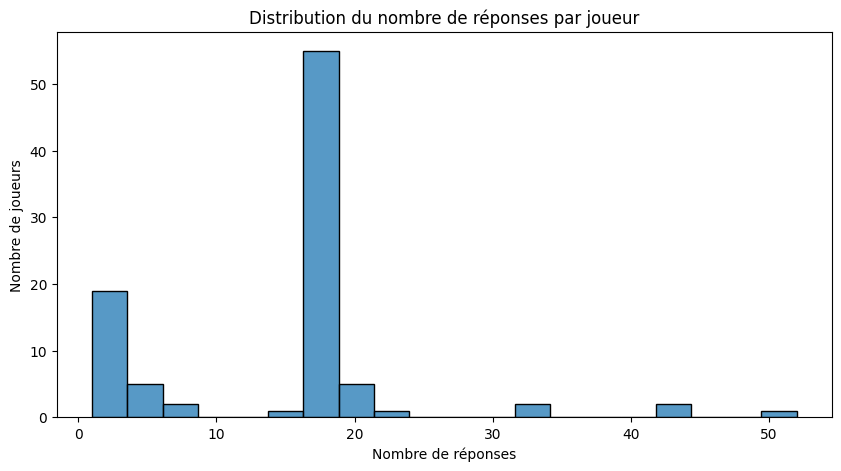

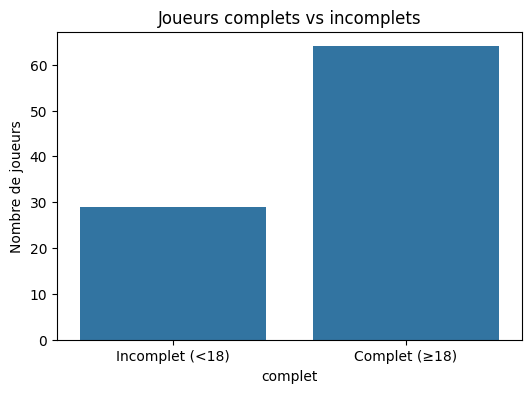

In [ ]:
# Histogramme du nombre de réponses par joueur
plt.figure(figsize=(10, 5))
sns.histplot(summary_df['n_reponses'], bins=20, kde=False)
plt.title("Distribution du nombre de réponses par joueur")
plt.xlabel("Nombre de réponses")
plt.ylabel("Nombre de joueurs")
plt.show()

# nb de joueurs incomplets (<18) vs complets (≥18)
summary_df['complet'] = summary_df['n_reponses'] >= 18
complet_counts = summary_df['complet'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=complet_counts.index, y=complet_counts.values)
plt.xticks([0, 1], ['Incomplet (<18)', 'Complet (≥18)'])
plt.ylabel('Nombre de joueurs')
plt.title('Joueurs complets vs incomplets')
plt.show()





In [ ]:
# Séparation complet/incomplet
plus_que_complets = summary_df[summary_df['n_reponses'] > 18]
complets = summary_df[summary_df['n_reponses'] == 18]
incomplets = summary_df[summary_df['n_reponses'] < 18]

n_complets = len(complets)
n_incomplets = len(incomplets)

display(f"Nombre de joueurs complets (=18 réponses) : {n_complets}")
display(f"Nombre de joueurs incomplets (<18 réponses) : {n_incomplets}")
display(f"Nombre de joueurs dépassant les 18 questions : {len(plus_que_complets)}")
display(f"Ratio de complets : {n_complets / (n_complets + n_incomplets)}")
display(f"Ratio de non-complets : {n_incomplets / (n_complets + n_incomplets)}")
display(f"Ratio de réponses dépassant 18 : {len(plus_que_complets) / (n_complets + n_incomplets)}")



'Nombre de joueurs complets (=18 réponses) : 53'

'Nombre de joueurs incomplets (<18 réponses) : 29'

'Nombre de joueurs dépassant les 18 questions : 11'

'Ratio de complets : 0.6463414634146342'

'Ratio de non-complets : 0.35365853658536583'

'Ratio de réponses dépassant 18 : 0.13414634146341464'

### Un premier test avec les trois dimensions


In [ ]:
df_test = df.copy()

df_test['associationType'] = LabelEncoder().fit_transform(df_test['associationType'])
df_test['personAType'] = LabelEncoder().fit_transform(df_test['personAType'])
df_test['personBType'] = LabelEncoder().fit_transform(df_test['personBType'])
df_test['textId'] = LabelEncoder().fit_transform(df_test['textId'])

X = df_test[['textId', 'associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
y = df_test[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]

In [ ]:
# premier test initial

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def mae(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def r2(y_true, y_pred): return r2_score(y_true, y_pred)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True))
}

# Définir KFold (pas stratified car régression)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

results = []

for name, model in models.items():
    row = {'Model': name}
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
    results.append(row)

results_df = pd.DataFrame(results)

# tri par R2 décroissant
results_df_sorted = results_df.sort_values(by='R2', ascending=False)

print("Résultats de la validation croisée (5-fold) :")
display(results_df_sorted)


[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 6
[LightGBM] [Info] Start training from score 5.039356
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 6
[LightGBM] [Info] Start training from score 4.960644
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 6
[LightGBM] [Info] Start training from score 4.855098
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 6
[LightGBM] [Info] Start training from score 5.144902
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 6
[LightGBM] [Info] Start training from score 4.997317
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features:

Model            MAE           RMSE             R2
1  Gradient Boosting  1.725 ± 0.055  2.294 ± 0.068  0.251 ± 0.037
4           LightGBM  1.723 ± 0.025  2.315 ± 0.051  0.234 ± 0.049
0      Random Forest  1.699 ± 0.032  2.347 ± 0.043  0.213 ± 0.064
2  Linear Regression  1.837 ± 0.079  2.450 ± 0.080  0.144 ± 0.040
3            XGBoost  1.842 ± 0.016  2.578 ± 0.028  0.049 ± 0.067

### On trouve des scores assez décevants pour les 3 dimensions en même temps, le meilleur étant 0,25 de R2 de Gradient Boosting

#### Explication des métriques


1.  **MAE (Mean Absolute Error)**	: Erreur absolue moyenne → moyenne des valeurs absolues des écarts.	Plus c’est bas, mieux c’est (meilleur = 0)
2.   **RMSE (Root Mean Squared Error)** :	Erreur quadratique moyenne → punit plus fort les grosses erreurs.	Plus c’est bas, mieux c’est (meilleur = 0)
3. **R² (coefficient de détermination)** : Part de variance expliquée par le modèle → indique si le modèle “explique” les variations des données.	Plus c’est proche de 1, mieux c’est ; 0 = pas mieux qu’une moyenne, < 0 = pire qu’un modèle naïf


#### Exemple

Imaginons que les vraies valeurs à prédire soient : [5, 6, 7]

Le modèle prédit : [4, 6, 8]

- MAE = moyenne des |4–5|, |6–6|, |8–7| → (1 + 0 + 1)/3 = 0.67

- RMSE = racine de ((1² + 0² + 1²)/3) → racine de (2/3) ≈ 0.82

- R² → mesure à quel point ton modèle réduit l’erreur par rapport à toujours prédire la moyenne → proche de 1 si parfait, proche de 0 si pas mieux qu’un modèle bête, négatif si catastrophique.

### A partir d'ici on se concentre sur seulement UNE dimension

In [ ]:
complets = df.groupby('sessionId').filter(lambda x: len(x) >= 18)
incomplets = df.groupby('sessionId').filter(lambda x: len(x) < 18)

def prepare_data(sub_df):
    X_sub = sub_df[['textId',  'genre', 'age','niveauEtudes','associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
    y_sub = sub_df[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]
    return X_sub, y_sub

X_complets, y_complets = prepare_data(complets)
X_incomplets, y_incomplets = prepare_data(incomplets)


In [ ]:
df_bin = df.copy()

print(df_bin['associationType'].unique())


['risk-reward' 'risk-effort' 'effort-reward']


#### On teste pour la dimension EFFORT

In [ ]:

# Encoder d’abord TOUT le df_bin global
label_encoders = {}
for col in ['textId', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# Filtrer effort APRÈS encodage
# Trouver le code numérique correspondant à "risk-effort" et "effort-reward"
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])

effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]

# Préparer X et y pour effort
X_effort = effort_df[['textId',  'associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
y_effort = effort_df[['valueOneA', 'valueOneB']]

# Même préparation pour complets et incomplets
X_complets = complets[['textId', 'associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
y_complets = complets[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]

X_incomplets = incomplets[['textId', 'associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
y_incomplets = incomplets[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]


In [ ]:
# deuxieme test (juste pour effort)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True))
}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)


# Exemple : tester sur l’effort uniquement
results_effort = evaluate_models(X_effort, y_effort)
print("\n📊 Résultats pour l'effort :")
print(results_effort)
'''
results_complets = evaluate_models(X_complets, y_complets)
print("\n📊 Résultats pour joueurs complets :")
print(results_complets)

results_incomplets = evaluate_models(X_incomplets, y_incomplets)
print("\n📊 Résultats pour joueurs incomplets :")
print(results_incomplets)
'''


[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 749, number of used features: 6
[LightGBM] [Info] Start training from score 4.965287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


'\nresults_complets = evaluate_models(X_complets, y_complets)\nprint("\n📊 Résultats pour joueurs complets :")\nprint(results_complets)\n\nresults_incomplets = evaluate_models(X_incomplets, y_incomplets)\nprint("\n📊 Résultats pour joueurs incomplets :")\nprint(results_incomplets)\n'

📊 Résultats pour l'effort :

               Model            MAE           RMSE             R2
            Random Forest  1.840 ± 0.075  2.481 ± 0.085  0.236 ± 0.044
        Gradient Boosting  1.848 ± 0.078  2.468 ± 0.089  0.244 ± 0.042
        Linear Regression  1.980 ± 0.063  2.578 ± 0.088  0.175 ± 0.047
                  XGBoost  2.048 ± 0.066  2.774 ± 0.093  0.045 ± 0.048
                 LightGBM  1.879 ± 0.077  2.485 ± 0.112  0.233 ± 0.065

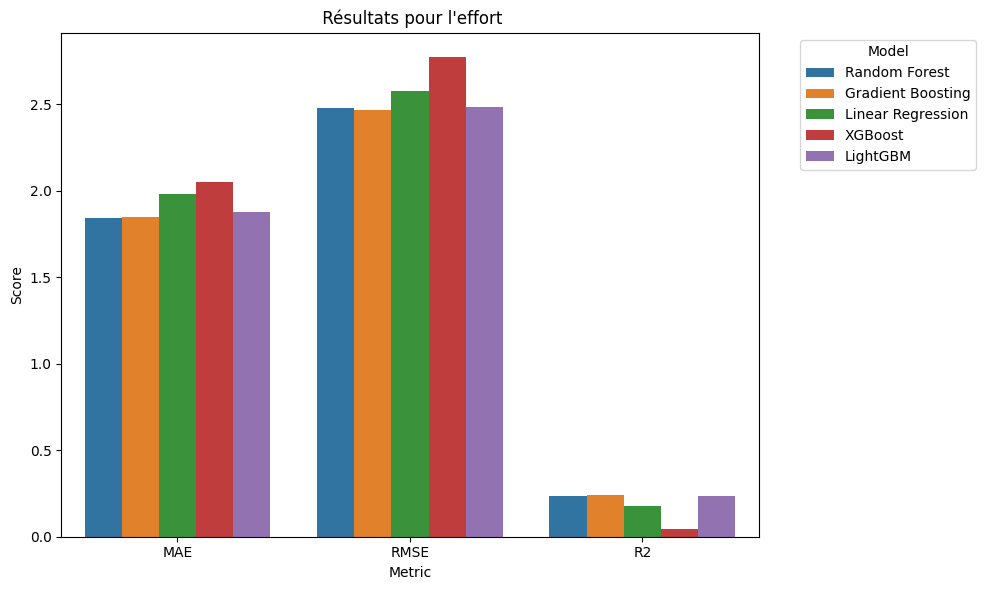

'\nplot_results(results_complets, " Résultats pour joueurs complets")\nplot_results(results_incomplets, " Résultats pour joueurs incomplets")\n'

In [ ]:
def plot_results(results_df, title):
    # Convertir les colonnes MAE, RMSE, R2 en valeurs numériques (en enlevant le ±)
    for metric in ['MAE', 'RMSE', 'R2']:
        results_df[metric] = results_df[metric].str.extract(r'([0-9\.]+)').astype(float)

    # Restructurer pour seaborn (long format)
    melted = pd.melt(results_df, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



plot_results(results_effort, " Résultats pour l'effort")
'''
plot_results(results_complets, " Résultats pour joueurs complets")
plot_results(results_incomplets, " Résultats pour joueurs incomplets")
'''


### Maintenant on teste pour les autres **dimensions** (séparemment toujours)

In [55]:
df_bin = df.copy()

label_encoders = {}
for col in [ 'genre','age','niveauEtudes','nationalite', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# on filtre les datasets
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[['associationType', 'genre', 'age','niveauEtudes', 'nationalite', 'personAType', 'personBType', 'forceA', 'forceB']]
X_effort = effort_df[['associationType', 'genre','age','niveauEtudes', 'nationalite','personAType', 'personBType', 'forceA', 'forceB']]
X_reward = reward_df[['associationType', 'personAType', 'genre','age','niveauEtudes','nationalite','personBType', 'forceA', 'forceB']]

# def y selon la colonne correspondant à la dimension

# RISK
risk_reward_code = label_encoders['associationType'].transform(['risk-reward'])[0]
risk_effort_code = label_encoders['associationType'].transform(['risk-effort'])[0]

risk_part1 = risk_df[risk_df['associationType'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType'] == risk_reward_code][['valueOneA', 'valueOneB']]
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()


# EFFORT
effort_effort_code = label_encoders['associationType'].transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType'] == effort_effort_code][['valueOneA', 'valueOneB']]
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()


# REWARD
reward_part1 = reward_df[reward_df['associationType'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()

reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()


print("Infos des features X : ")
print("")

display(X_risk.columns)
display(X_risk.shape)

display(X_effort.columns)
display(X_effort.shape)

display(X_reward.columns)
display(X_reward.shape)

print("------------------------------------------------")


print("Infos des targets y : ")
print("")

display(y_risk.columns)
display(y_risk.shape)

display(y_effort.columns)
display(y_effort.shape)

display(y_reward.columns)
display(y_reward.shape)

print("------------------------------------------------")


print("Premieres valeurs des features X")

display(X_risk.head())
display(X_effort.head())
display(X_reward.head())

print("------------------------------------------------")


print("Premieres valeurs des targets y")

display(y_risk.head())
display(y_effort.head())
display(y_reward.head())


print("Risk part 1 et 2")
display(risk_part1)
display(risk_part2)

Infos des features X : 



Index(['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite',
       'personAType', 'personBType', 'forceA', 'forceB'],
      dtype='object')

(922, 9)

Index(['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite',
       'personAType', 'personBType', 'forceA', 'forceB'],
      dtype='object')

(937, 9)

Index(['associationType', 'personAType', 'genre', 'age', 'niveauEtudes',
       'nationalite', 'personBType', 'forceA', 'forceB'],
      dtype='object')

(937, 9)

------------------------------------------------
Infos des targets y : 



Index(['riskA', 'riskB'], dtype='object')

(922, 2)

Index(['effortA', 'effortB'], dtype='object')

(937, 2)

Index(['rewardA', 'rewardB'], dtype='object')

(937, 2)

------------------------------------------------
Premieres valeurs des features X


associationType  genre  age  niveauEtudes  nationalite  personAType  \
0                2      1    8             3            5            6   
1                2      1    8             3            5            2   
2                1      1    8             3            5            0   
5                2      1    8             3            5            4   
6                2      1    8             3            5            3   

   personBType  forceA  forceB  
0            5       8       3  
1            6       5       8  
2            2       3       5  
5            5       6       3  
6            4       9       6

associationType  genre  age  niveauEtudes  nationalite  personAType  \
2                1      1    8             3            5            0   
3                0      1    8             3            5            0   
4                0      1    8             3            5            1   
7                0      1    8             3            5            5   
8                1      1    8             3            5            4   

   personBType  forceA  forceB  
2            2       3       5  
3            2       3       5  
4            4       7       6  
7            1       3       7  
8            0       6       3

associationType  personAType  genre  age  niveauEtudes  nationalite  \
0                2            6      1    8             3            5   
1                2            2      1    8             3            5   
3                0            0      1    8             3            5   
4                0            1      1    8             3            5   
5                2            4      1    8             3            5   

   personBType  forceA  forceB  
0            5       8       3  
1            6       5       8  
3            2       3       5  
4            4       7       6  
5            5       6       3

------------------------------------------------
Premieres valeurs des targets y


riskA  riskB
0      8      2
1      4      6
2      5      5
5      8      2
6      6      4

effortA  effortB
2        3        7
3        3        7
4        5        5
7        3        7
8        8        2

rewardA  rewardB
0        5        5
1        7        3
3        3        7
4        5        5
5        8        2

Risk part 1 et 2


riskA  riskB
2         5      5
8         7      3
10        7      3
11        4      6
12        8      2
...     ...    ...
1384     10      0
1385      0     10
1386      0     10
1389      5      5
1394      0     10

[461 rows x 2 columns]

riskA  riskB
0         8      2
1         4      6
5         8      2
6         6      4
9         3      7
...     ...    ...
1383      5      5
1390      0     10
1391      0     10
1392      5      5
1396      0     10

[461 rows x 2 columns]

In [ ]:
# Évaluer
results_risk = evaluate_models(X_risk, y_risk)
results_effort = evaluate_models(X_effort, y_effort)
results_reward = evaluate_models(X_reward, y_reward)

# Afficher
print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Risk :")
display(results_risk)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Effort :")
display(results_effort)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Reward :")
display(results_reward)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

Model            MAE           RMSE              R2
0      Random Forest  1.878 ± 0.126  2.595 ± 0.185   0.134 ± 0.124
1  Gradient Boosting  2.005 ± 0.114  2.659 ± 0.141   0.093 ± 0.099
2  Linear Regression  2.009 ± 0.095  2.593 ± 0.138   0.138 ± 0.085
3            XGBoost  2.003 ± 0.125  2.835 ± 0.188  -0.036 ± 0.161
4           LightGBM  1.965 ± 0.101  2.653 ± 0.135   0.097 ± 0.093

-----------------------------------------------------------

 Résultats pour la dimension Effort :


Model            MAE           RMSE             R2
0      Random Forest  1.614 ± 0.065  2.239 ± 0.094  0.370 ± 0.049
1  Gradient Boosting  1.639 ± 0.053  2.191 ± 0.099  0.395 ± 0.067
2  Linear Regression  1.765 ± 0.088  2.341 ± 0.104  0.313 ± 0.036
3            XGBoost  1.688 ± 0.070  2.392 ± 0.130  0.280 ± 0.071
4           LightGBM  1.665 ± 0.051  2.225 ± 0.090  0.378 ± 0.045

-----------------------------------------------------------

 Résultats pour la dimension Reward :


Model            MAE           RMSE             R2
0      Random Forest  1.417 ± 0.094  2.000 ± 0.107  0.255 ± 0.042
1  Gradient Boosting  1.490 ± 0.096  2.020 ± 0.126  0.240 ± 0.056
2  Linear Regression  1.635 ± 0.115  2.268 ± 0.114  0.042 ± 0.036
3            XGBoost  1.527 ± 0.072  2.227 ± 0.074  0.074 ± 0.045
4           LightGBM  1.529 ± 0.092  2.101 ± 0.109  0.178 ± 0.037

In [43]:
from sklearn.base import clone

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True))
}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def save_best_model(X, y, dimension_name):
    best_score = -np.inf
    best_model = None
    best_model_name = ""

    for name, model in models.items():
        # On évalue le modèle avec R² comme critère principal
        scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_model = clone(model)
            best_model_name = name

    # On réentraîne sur tout le dataset
    best_model.fit(X, y)

    # Sauvegarde
    filename = f"best_model_{dimension_name}_{best_model_name.replace(' ', '_')}.joblib"
    joblib.dump(best_model, filename)
    print(f"Meilleur modèle pour {dimension_name} ({best_model_name}) sauvegardé dans : {filename}")

save_best_model(X_risk, y_risk, "risk")
save_best_model(X_effort, y_effort, "effort")
save_best_model(X_reward, y_reward, "reward")



[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 737, number of used features: 9
[LightGBM] [Info] Start training from score 5.042062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
def plot_results(results_df, title):
    df_copy = results_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)
    melted = pd.melt(df_copy, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

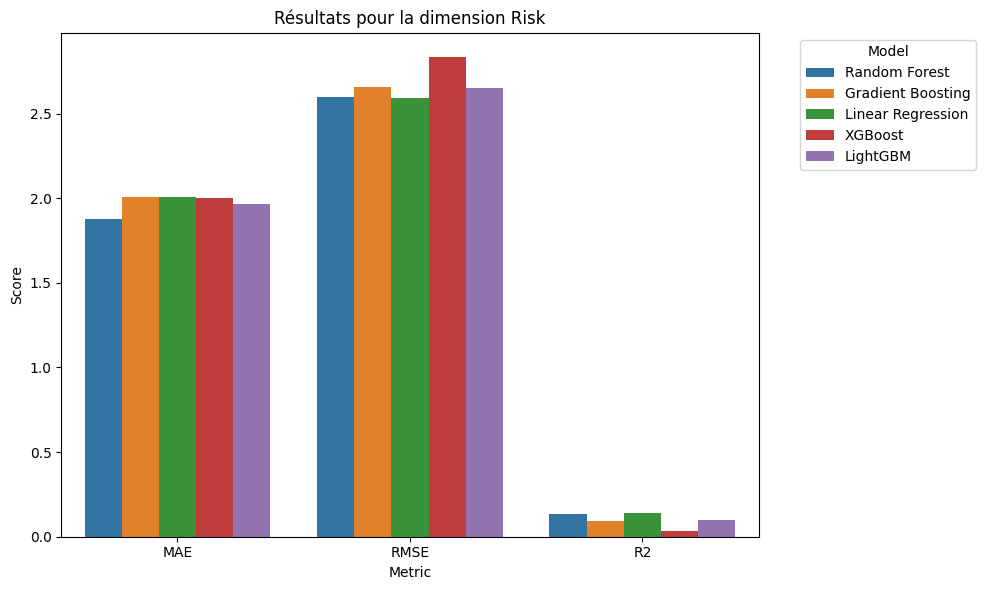

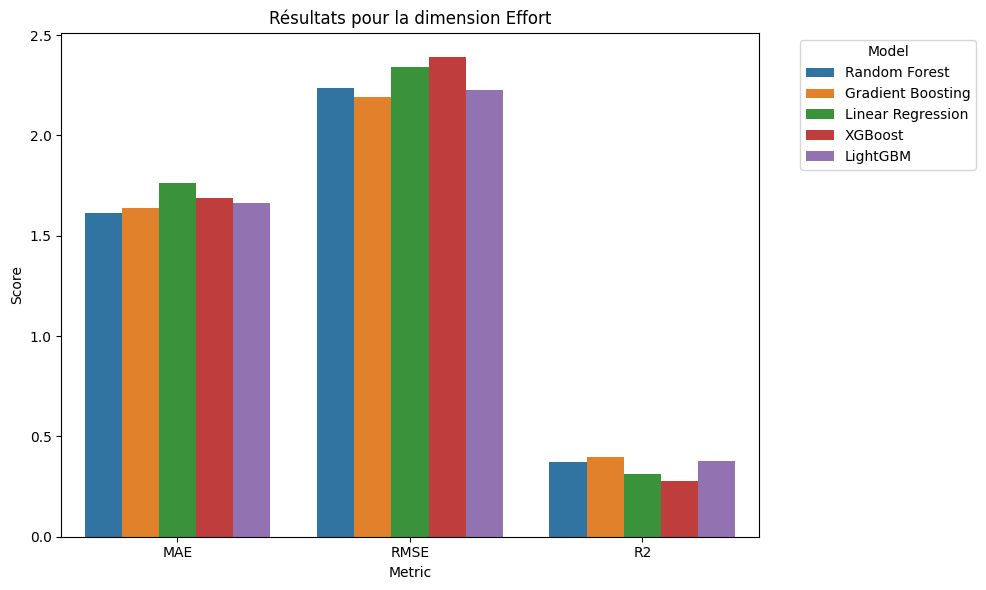

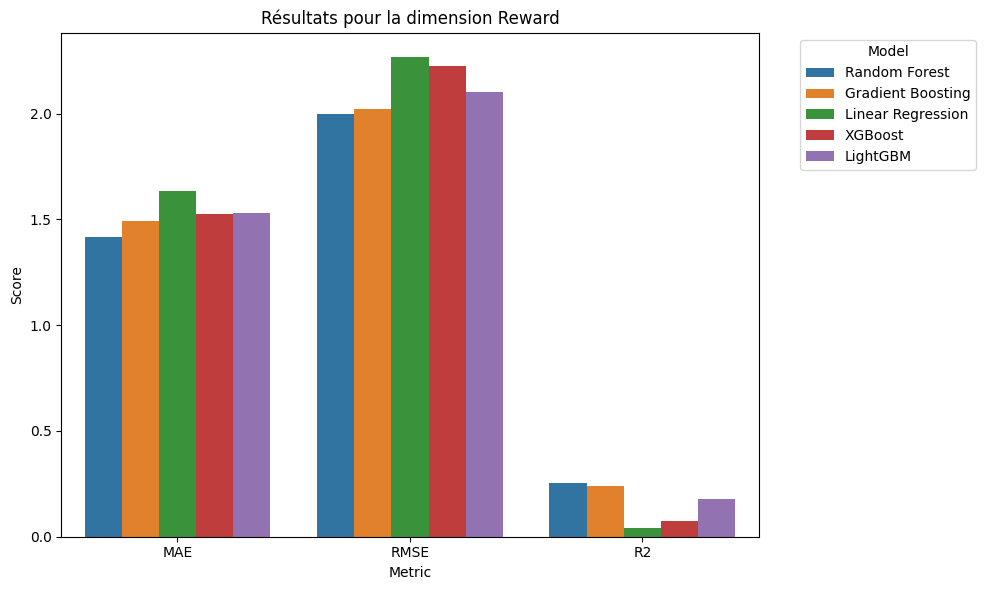

In [ ]:
plot_results(results_risk, "Résultats pour la dimension Risk")
plot_results(results_effort, "Résultats pour la dimension Effort")
plot_results(results_reward, "Résultats pour la dimension Reward")


In [ ]:
def combine_results(results_risk, results_effort, results_reward):
    risk = results_risk.copy()
    risk['Dimension'] = 'Risk'
    effort = results_effort.copy()
    effort['Dimension'] = 'Effort'
    reward = results_reward.copy()
    reward['Dimension'] = 'Reward'

    combined = pd.concat([risk, effort, reward], axis=0)
    return combined


In [ ]:
def plot_combined_results(combined_df):
    df_copy = combined_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)

    melted = pd.melt(df_copy, id_vars=['Model', 'Dimension'], value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(14, 7))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model', ci=None, palette='Set2', dodge=True)
    plt.title("Résultats combinés Risk / Effort / Reward")
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Model            MAE           RMSE              R2 Dimension
0      Random Forest  1.878 ± 0.126  2.595 ± 0.185   0.134 ± 0.124      Risk
1  Gradient Boosting  2.005 ± 0.114  2.659 ± 0.141   0.093 ± 0.099      Risk
2  Linear Regression  2.009 ± 0.095  2.593 ± 0.138   0.138 ± 0.085      Risk
3            XGBoost  2.003 ± 0.125  2.835 ± 0.188  -0.036 ± 0.161      Risk
4           LightGBM  1.965 ± 0.101  2.653 ± 0.135   0.097 ± 0.093      Risk
0      Random Forest  1.614 ± 0.065  2.239 ± 0.094   0.370 ± 0.049    Effort
1  Gradient Boosting  1.639 ± 0.053  2.191 ± 0.099   0.395 ± 0.067    Effort
2  Linear Regression  1.765 ± 0.088  2.341 ± 0.104   0.313 ± 0.036    Effort
3            XGBoost  1.688 ± 0.070  2.392 ± 0.130   0.280 ± 0.071    Effort
4           LightGBM  1.665 ± 0.051  2.225 ± 0.090   0.378 ± 0.045    Effort
0      Random Forest  1.417 ± 0.094  2.000 ± 0.107   0.255 ± 0.042    Reward
1  Gradient Boosting  1.490 ± 0.096  2.020 ± 0.126   0.240 ± 0.056    Reward
2  Linear Regression  1.635 ± 0.115  2.268 ± 0.114   0.042 ± 0.036    Reward
3            XGBoost  1.527 ± 0.072  2.227 ± 0.074   0.074 ± 0.045    Reward
4           LightGBM  1.529 ± 0.092  2.101 ± 0.109   0.178 ± 0.037    Reward

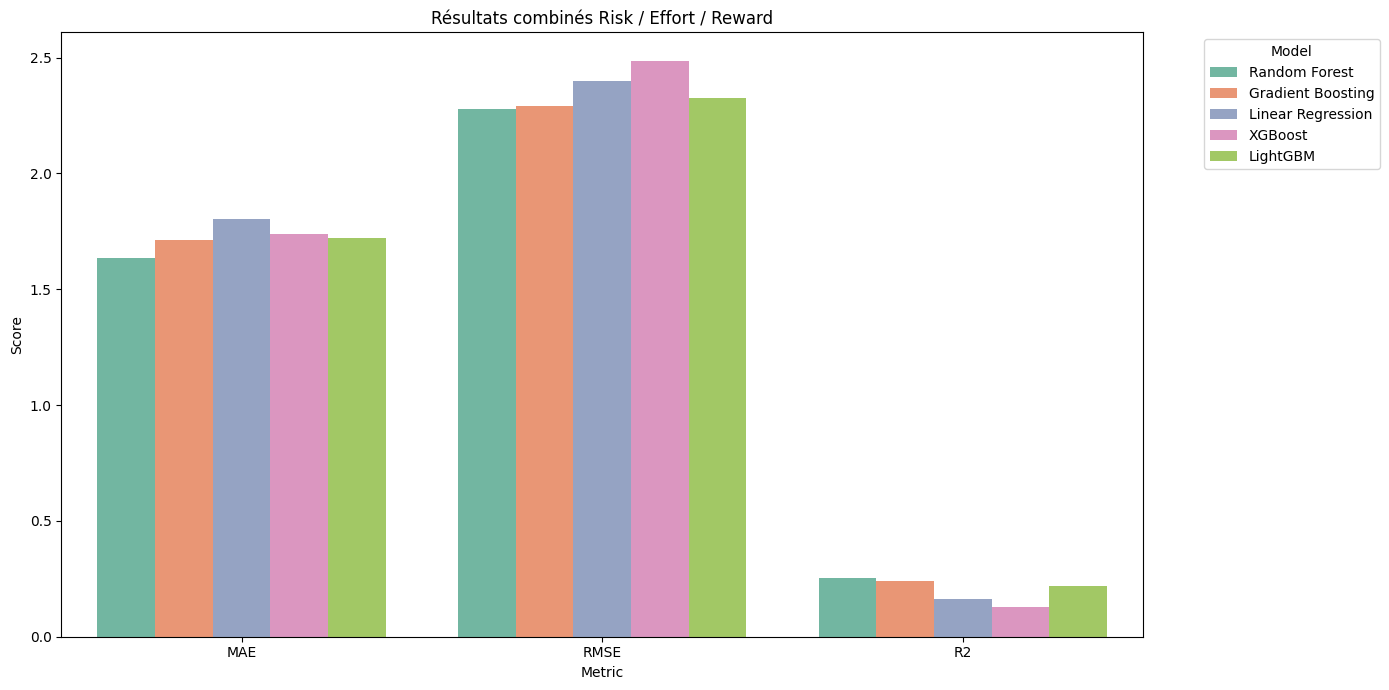

In [ ]:
combined_results = combine_results(results_risk, results_effort, results_reward)
display(combined_results)

plot_combined_results(combined_results)


### Hyperparameter Tuning

#### Avec Optuna

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42, **params))
    scores = cross_val_score(model, X_effort, y_effort, cv=3, scoring='r2')
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

print("✅ Best XGBoost params:", study_xgb.best_params)
print("✅ Best R² XGBoost:", study_xgb.best_value)


In [ ]:
from lightgbm import LGBMRegressor

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    model = MultiOutputRegressor(LGBMRegressor(random_state=42, **params))
    scores = cross_val_score(model, X_effort, y_effort, cv=3, scoring='r2')
    return np.mean(scores)

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100)

print("✅ Best LightGBM params:", study_lgbm.best_params)
print("✅ Best R² LightGBM:", study_lgbm.best_value)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42, **params))
    scores = cross_val_score(model, X_effort, y_effort, cv=3, scoring='r2')
    return np.mean(scores)

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=30)

print("✅ Best Gradient Boosting params:", study_gb.best_params)
print("✅ Best R² Gradient Boosting:", study_gb.best_value)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42, **params))
    scores = cross_val_score(model, X_effort, y_effort, cv=3, scoring='r2')
    return np.mean(scores)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)

print("✅ Best Random Forest params:", study_rf.best_params)
print("✅ Best R² Random Forest:", study_rf.best_value)


In [ ]:
# visualiser avec optuna

# xgboost
vis.plot_optimization_history(study_xgb).show()
vis.plot_param_importances(study_xgb).show()

# light gbm
vis.plot_optimization_history(study_lgbm).show()
vis.plot_param_importances(study_lgbm).show()

# gradient boosting
vis.plot_optimization_history(study_gb).show()
vis.plot_param_importances(study_gb).show()

# random forest
vis.plot_optimization_history(study_rf).show()
vis.plot_param_importances(study_rf).show()


### On teste avec ratios des forces et et définition de colonnes catégorielles

---



In [59]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

df_bin = df.copy()

# Ajout des ratios
df_bin['force_sum'] = df_bin['forceA'] + df_bin['forceB']
df_bin['forceA_ratio'] = df_bin['forceA'] / df_bin['force_sum']
df_bin['forceB_ratio'] = df_bin['forceB'] / df_bin['force_sum']

# Colonnes finales (y compris ratios)
feature_cols = ['age', 'nationalite', 'forceA', 'forceB', 'forceA_ratio', 'forceB_ratio',
                 'genre', 'niveauEtudes', 'personAType', 'personBType']


label_encoders = {}
for col in feature_cols:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# Encodage pour filtrer les scénarios : LabelEncoder seulement pour associationType
le_assoc = LabelEncoder()
df_bin['associationType_encoded'] = le_assoc.fit_transform(df_bin['associationType'])

# Récupération des codes pour chaque dimension
risk_codes = le_assoc.transform(['risk-effort', 'risk-reward'])
effort_codes = le_assoc.transform(['risk-effort', 'effort-reward'])
reward_codes = le_assoc.transform(['risk-reward', 'effort-reward'])

# Filtrer les datasets
risk_df = df_bin[df_bin['associationType_encoded'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType_encoded'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType_encoded'].isin(reward_codes)]

# Définir X
X_risk = risk_df[feature_cols]
X_effort = effort_df[feature_cols]
X_reward = reward_df[feature_cols]

# Définir y selon la colonne correspondant à la dimension

# RISK
risk_effort_code = le_assoc.transform(['risk-effort'])[0]
risk_reward_code = le_assoc.transform(['risk-reward'])[0]

risk_part1 = risk_df[risk_df['associationType_encoded'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType_encoded'] == risk_reward_code][['valueOneA', 'valueOneB']]
risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

# EFFORT
effort_effort_code = le_assoc.transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType_encoded'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType_encoded'] == effort_effort_code][['valueOneA', 'valueOneB']]
effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

# REWARD
reward_part1 = reward_df[reward_df['associationType_encoded'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType_encoded'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor

# Modèles
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "LightGBM": LGBMRegressor(random_state=42, force_row_wise=True),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

# Validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Métriques
scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        pipe = MultiOutputRegressor(model)
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(pipe, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)


# ➤ Lancer les évaluations
results_risk = evaluate_models(X_risk, y_risk)
results_effort = evaluate_models(X_effort, y_effort)
results_reward = evaluate_models(X_reward, y_reward)

print("\n📊 Résultats Risk")
display(results_risk)
print("\n📊 Résultats Effort")
display(results_effort)
print("\n📊 Résultats Reward")
display(results_reward)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

Model            MAE           RMSE              R2
0      Random Forest  1.939 ± 0.141  2.642 ± 0.212   0.100 ± 0.157
1  Gradient Boosting  1.968 ± 0.119  2.609 ± 0.155   0.126 ± 0.104
2  Linear Regression  2.007 ± 0.098  2.594 ± 0.139   0.137 ± 0.087
3            XGBoost  2.067 ± 0.178  2.899 ± 0.249  -0.083 ± 0.188
4           LightGBM  1.998 ± 0.138  2.700 ± 0.180   0.062 ± 0.137
5           CatBoost  1.953 ± 0.133  2.670 ± 0.186   0.082 ± 0.140


📊 Résultats Effort


Model            MAE           RMSE             R2
0      Random Forest  1.629 ± 0.062  2.273 ± 0.091  0.351 ± 0.054
1  Gradient Boosting  1.675 ± 0.062  2.238 ± 0.110  0.369 ± 0.069
2  Linear Regression  1.770 ± 0.082  2.344 ± 0.107  0.311 ± 0.037
3            XGBoost  1.717 ± 0.051  2.464 ± 0.049  0.237 ± 0.050
4           LightGBM  1.678 ± 0.060  2.269 ± 0.101  0.353 ± 0.060
5           CatBoost  1.638 ± 0.062  2.280 ± 0.111  0.347 ± 0.052


📊 Résultats Reward


Model            MAE           RMSE             R2
0      Random Forest  1.455 ± 0.096  2.066 ± 0.110  0.205 ± 0.042
1  Gradient Boosting  1.517 ± 0.097  2.081 ± 0.120  0.192 ± 0.057
2  Linear Regression  1.621 ± 0.107  2.246 ± 0.109  0.059 ± 0.049
3            XGBoost  1.573 ± 0.068  2.288 ± 0.075  0.023 ± 0.050
4           LightGBM  1.567 ± 0.099  2.159 ± 0.113  0.132 ± 0.041
5           CatBoost  1.483 ± 0.089  2.107 ± 0.109  0.171 ± 0.066

### On change à une tache de classification binaire (pas de regression)


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# On teste avec RandomForest d'abord

# cibles binaires
df_bin['who_more_oneA'] = (df_bin['valueOneA'] > df_bin['valueOneB']).astype(int)
df_bin['who_more_twoA'] = (df_bin['valueTwoA'] > df_bin['valueTwoB']).astype(int)
df_bin['who_equal_oneB'] = (df_bin['valueOneB'] == df_bin['valueOneA']).astype(int)
df_bin['who_more_oneB'] = (df_bin['valueOneB'] > df_bin['valueOneA']).astype(int)
df_bin['who_more_twoB'] = (df_bin['valueTwoB'] > df_bin['valueTwoA']).astype(int)
df_bin['who_equal_twoA'] = (df_bin['valueTwoA'] == df_bin['valueTwoB']).astype(int)

print(df_bin['who_more_oneA'].value_counts(normalize=True))
print(df_bin['who_more_twoA'].value_counts(normalize=True))
print(df_bin['who_more_oneB'].value_counts(normalize=True))
print(df_bin['who_more_twoB'].value_counts(normalize=True))
print(df_bin['who_equal_oneB'].value_counts(normalize=True))
print(df_bin['who_equal_twoA'].value_counts(normalize=True))


X_cls = df_bin[feature_cols]


def evaluate_classification_all(X, y):
    clf = Pipeline([
        ('onehot', onehot),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }
    results = {}
    for metric, scorer in scoring.items():
        scores = cross_val_score(clf, X, y, cv=kf, scoring=scorer)
        results[metric] = f"{scores.mean():.3f} ± {scores.std():.3f}"
    return results
'''
# tester sur toutes les cibles
for col in ['who_more_oneA', 'who_more_twoA', 'who_more_oneB', 'who_more_twoB', 'who_equal_oneB', 'who_equal_twoA']:
    print(f"\n📊 Classification binaire {col}")
    res = evaluate_classification_all(X_cls, df_bin[col])
    for metric, score in res.items():
        display(f"{metric.capitalize()} : {score}")
'''


who_more_oneA
0    0.655222
1    0.344778
Name: proportion, dtype: float64
who_more_twoA
0    0.738913
1    0.261087
Name: proportion, dtype: float64
who_more_oneB
0    0.649499
1    0.350501
Name: proportion, dtype: float64
who_more_twoB
0    0.683119
1    0.316881
Name: proportion, dtype: float64
who_equal_oneB
0    0.695279
1    0.304721
Name: proportion, dtype: float64
who_equal_twoA
0    0.577969
1    0.422031
Name: proportion, dtype: float64


'\n# tester sur toutes les cibles\nfor col in [\'who_more_oneA\', \'who_more_twoA\', \'who_more_oneB\', \'who_more_twoB\', \'who_equal_oneB\', \'who_equal_twoA\']:\n    print(f"\n📊 Classification binaire {col}")\n    res = evaluate_classification_all(X_cls, df_bin[col])\n    for metric, score in res.items():\n        display(f"{metric.capitalize()} : {score}")\n'

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

feature_cols = ['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite',
                'personAType', 'personBType', 'forceA', 'forceB']

def prepare_and_evaluate(df_sub, dimension_name):
    df_sub = df_sub.copy()
    df_sub['who_more_oneA'] = (df_sub['valueOneA'] > df_sub['valueOneB']).astype(int)
    df_sub['who_more_twoA'] = (df_sub['valueTwoA'] > df_sub['valueTwoB']).astype(int)
    df_sub['who_more_oneB'] = (df_sub['valueOneB'] > df_sub['valueOneA']).astype(int)
    df_sub['who_more_twoB'] = (df_sub['valueTwoB'] > df_sub['valueTwoA']).astype(int)
    df_sub['who_equal_oneB'] = (df_sub['valueOneB'] == df_sub['valueOneA']).astype(int)
    df_sub['who_equal_twoA'] = (df_sub['valueTwoA'] == df_sub['valueTwoB']).astype(int)


    X_sub = df_sub[feature_cols]

    print(f"\n✅ Résultats pour la dimension {dimension_name}")
    for col in ['who_more_oneA', 'who_more_twoA', 'who_more_oneB', 'who_more_twoB', 'who_equal_oneB', 'who_equal_twoA']:
        print(f"\n📊 Classification binaire {col}")
        res = evaluate_classification_all(X_sub, df_sub[col])
        for metric, score in res.items():
            print(f"{metric.capitalize()} : {score}")

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

def evaluate_classification_models(X, y):
    results = []
    for name, model in models.items():
        clf = Pipeline([
            ('onehot', onehot),
            ('classifier', model)
        ])
        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1': make_scorer(f1_score)
        }
        row = {'Model': name}
        for metric, scorer in scoring.items():
            scores = cross_val_score(clf, X, y, cv=kf, scoring=scorer)
            row[metric] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)

# Exemple sur la dimension Risk, cible who_more_oneA
results_risk_oneA = evaluate_classification_models(X_risk, risk_df['valueOneA'] > risk_df['valueOneB'])
print("\n📊 Résultats Risk - who_more_oneA")
display(results_risk_oneA)



📊 Résultats Risk - who_more_oneA


Model       accuracy      precision         recall  \
0        Random Forest  0.751 ± 0.030  0.672 ± 0.070  0.491 ± 0.045   
1  Logistic Regression  0.719 ± 0.015  0.607 ± 0.038  0.452 ± 0.046   
2                  SVM  0.706 ± 0.026  0.717 ± 0.146  0.255 ± 0.106   
3                  KNN  0.691 ± 0.016  0.540 ± 0.044  0.471 ± 0.037   
4    Gradient Boosting  0.727 ± 0.006  0.611 ± 0.028  0.494 ± 0.034   
5             AdaBoost  0.722 ± 0.022  0.594 ± 0.053  0.544 ± 0.062   
6          Naive Bayes  0.702 ± 0.025  0.548 ± 0.023  0.620 ± 0.073   

              f1  
0  0.567 ± 0.052  
1  0.516 ± 0.030  
2  0.350 ± 0.132  
3  0.503 ± 0.037  
4  0.545 ± 0.022  
5  0.564 ± 0.036  
6  0.579 ± 0.030

In [ ]:
prepare_and_evaluate(risk_df, "Risk")
prepare_and_evaluate(effort_df, "Effort")
prepare_and_evaluate(reward_df, "Reward")



✅ Résultats pour la dimension Risk

📊 Classification binaire who_more_oneA
Accuracy : 0.751 ± 0.030
Precision : 0.672 ± 0.070
Recall : 0.491 ± 0.045
F1 : 0.567 ± 0.052

📊 Classification binaire who_more_twoA
Accuracy : 0.799 ± 0.025
Precision : 0.647 ± 0.079
Recall : 0.447 ± 0.055
F1 : 0.528 ± 0.060

📊 Classification binaire who_more_oneB
Accuracy : 0.758 ± 0.031
Precision : 0.694 ± 0.081
Recall : 0.573 ± 0.055
F1 : 0.625 ± 0.053

📊 Classification binaire who_more_twoB
Accuracy : 0.746 ± 0.030
Precision : 0.667 ± 0.058
Recall : 0.492 ± 0.051
F1 : 0.566 ± 0.054

📊 Classification binaire who_equal_oneB
Accuracy : 0.778 ± 0.018
Precision : 0.690 ± 0.054
Recall : 0.520 ± 0.028
F1 : 0.593 ± 0.038

📊 Classification binaire who_equal_twoA
Accuracy : 0.743 ± 0.030
Precision : 0.708 ± 0.037
Recall : 0.636 ± 0.040
F1 : 0.670 ± 0.034

✅ Résultats pour la dimension Effort

📊 Classification binaire who_more_oneA
Accuracy : 0.769 ± 0.015
Precision : 0.708 ± 0.035
Recall : 0.582 ± 0.045
F1 : 0.637 ±

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

feature_cols = ['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite',
                'personAType', 'personBType', 'forceA', 'forceB']

models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced',random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced',max_iter=500),
    'SVM': SVC(),
    'SVM Poly': SVC(kernel='poly'),
    'SVM RBF': SVC(kernel='rbf'),
    'SVM Sigmoid': SVC(kernel='sigmoid'),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}


categorical_cols = ['associationType', 'genre', 'niveauEtudes', 'nationalite',
                    'personAType', 'personBType']

onehot = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_cols)
], remainder='passthrough')




def prepare_and_evaluate_all_models(df_sub, dimension_name):
    df_sub = df_sub.copy()

    # Création des cibles binaires
    df_sub['who_more_oneA'] = (df_sub['valueOneA'] > df_sub['valueOneB']).astype(int)
    df_sub['who_more_twoA'] = (df_sub['valueTwoA'] > df_sub['valueTwoB']).astype(int)
    df_sub['who_more_oneB'] = (df_sub['valueOneB'] > df_sub['valueOneA']).astype(int)
    df_sub['who_more_twoB'] = (df_sub['valueTwoB'] > df_sub['valueTwoA']).astype(int)
    df_sub['who_equal_one'] = (df_sub['valueOneB'] == df_sub['valueOneA']).astype(int)
    df_sub['who_equal_two'] = (df_sub['valueTwoA'] == df_sub['valueTwoB']).astype(int)

    X_sub = df_sub[feature_cols]

    print(f"\n📊📊 Résultats pour la dimension : {dimension_name}")

    # Pour chaque cible binaire
    for target in ['who_more_oneA', 'who_more_twoA', 'who_more_oneB', 'who_more_twoB', 'who_equal_one', 'who_equal_two']:
        print(f"\n🔹 Classification binaire : {target}")
        y_sub = df_sub[target]

        results = []
        best_score = -1
        best_model = None
        best_model_name = ""
        for name, model in models.items():
            clf = Pipeline([
                ('onehot', onehot),
                ('classifier', model)
            ])
            scoring = {
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score),
                'recall': make_scorer(recall_score),
                'f1': make_scorer(f1_score)
            }
            row = {'Model': name}
            for metric, scorer in scoring.items():
                scores = cross_val_score(clf, X_sub, y_sub, cv=kf, scoring=scorer)
                row[metric] = f"{scores.mean():.3f} ± {scores.std():.3f}"
                if metric == 'f1' and scores.mean() > best_score:
                    best_score = scores.mean()
                    best_model = clone(clf)
                    best_model_name = name
            results.append(row)

        results_df = pd.DataFrame(results)
        display(results_df)


        # Réentraîner et sauvegarder le meilleur modèle
        if best_model:
            best_model.fit(X_sub, y_sub)
            filename = f"best_model_{dimension_name}_{target}_{best_model_name.replace(' ', '_')}.joblib"
            joblib.dump(best_model, filename)
            print(f"Meilleur modèle ({best_model_name}) pour {dimension_name} - {target} sauvegardé dans : {filename}")



In [77]:
prepare_and_evaluate_all_models(risk_df, "Risk")
prepare_and_evaluate_all_models(effort_df, "Effort")
prepare_and_evaluate_all_models(reward_df, "Reward")



📊📊 Résultats pour la dimension : Risk

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0        Random Forest  0.734 ± 0.025  0.633 ± 0.048  0.487 ± 0.040   
1  Logistic Regression  0.677 ± 0.027  0.513 ± 0.024  0.659 ± 0.054   
2                  SVM  0.729 ± 0.009  0.660 ± 0.066  0.376 ± 0.042   
3             SVM Poly  0.710 ± 0.019  0.698 ± 0.150  0.237 ± 0.034   
4              SVM RBF  0.729 ± 0.009  0.660 ± 0.066  0.376 ± 0.042   
5          SVM Sigmoid  0.650 ± 0.063  0.474 ± 0.082  0.403 ± 0.119   
6                  KNN  0.708 ± 0.020  0.575 ± 0.051  0.481 ± 0.022   
7    Gradient Boosting  0.736 ± 0.009  0.628 ± 0.027  0.511 ± 0.049   
8             AdaBoost  0.711 ± 0.025  0.611 ± 0.073  0.367 ± 0.042   
9          Naive Bayes  0.681 ± 0.027  0.569 ± 0.085  0.154 ± 0.049   

              f1  
0  0.549 ± 0.036  
1  0.575 ± 0.023  
2  0.478 ± 0.048  
3  0.352 ± 0.054  
4  0.478 ± 0.048  
5  0.430 ± 0.090  
6  0.523 ± 0.032  
7  0.562 ± 0.033  
8  0.458 ± 0.051  
9  0.241 ± 0.067

Meilleur modèle (Logistic Regression) pour Risk - who_more_oneA sauvegardé dans : best_model_Risk_who_more_oneA_Logistic_Regression.joblib

🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0        Random Forest  0.812 ± 0.030  0.715 ± 0.062  0.423 ± 0.073   
1  Logistic Regression  0.685 ± 0.025  0.424 ± 0.057  0.708 ± 0.072   
2                  SVM  0.751 ± 0.031  0.160 ± 0.320  0.019 ± 0.038   
3             SVM Poly  0.747 ± 0.028  0.000 ± 0.000  0.000 ± 0.000   
4              SVM RBF  0.751 ± 0.031  0.160 ± 0.320  0.019 ± 0.038   
5          SVM Sigmoid  0.650 ± 0.038  0.194 ± 0.109  0.170 ± 0.097   
6                  KNN  0.752 ± 0.015  0.515 ± 0.053  0.370 ± 0.041   
7    Gradient Boosting  0.777 ± 0.044  0.592 ± 0.095  0.378 ± 0.081   
8             AdaBoost  0.749 ± 0.028  0.516 ± 0.089  0.238 ± 0.031   
9          Naive Bayes  0.535 ± 0.039  0.335 ± 0.012  0.857 ± 0.042   

              f1  
0  0.530 ± 0.072  
1  0.530 ± 0.063  
2  0.034 ± 0.068  
3  0.000 ± 0.000  
4  0.034 ± 0.068  
5  0.180 ± 0.100  
6  0.427 ± 0.025  
7  0.460 ± 0.088  
8  0.324 ± 0.041  
9  0.481 ± 0.017

Meilleur modèle (Random Forest) pour Risk - who_more_twoA sauvegardé dans : best_model_Risk_who_more_twoA_Random_Forest.joblib

🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0        Random Forest  0.760 ± 0.026  0.699 ± 0.066  0.568 ± 0.029   
1  Logistic Regression  0.675 ± 0.019  0.534 ± 0.052  0.648 ± 0.049   
2                  SVM  0.689 ± 0.028  0.627 ± 0.101  0.324 ± 0.037   
3             SVM Poly  0.677 ± 0.028  0.624 ± 0.124  0.242 ± 0.073   
4              SVM RBF  0.689 ± 0.028  0.627 ± 0.101  0.324 ± 0.037   
5          SVM Sigmoid  0.654 ± 0.041  0.527 ± 0.092  0.397 ± 0.019   
6                  KNN  0.708 ± 0.035  0.614 ± 0.042  0.496 ± 0.055   
7    Gradient Boosting  0.721 ± 0.013  0.628 ± 0.070  0.526 ± 0.063   
8             AdaBoost  0.676 ± 0.028  0.575 ± 0.086  0.334 ± 0.043   
9          Naive Bayes  0.487 ± 0.026  0.398 ± 0.033  0.863 ± 0.028   

              f1  
0  0.626 ± 0.040  
1  0.584 ± 0.038  
2  0.423 ± 0.036  
3  0.340 ± 0.083  
4  0.423 ± 0.036  
5  0.449 ± 0.034  
6  0.546 ± 0.032  
7  0.569 ± 0.047  
8  0.421 ± 0.049  
9  0.543 ± 0.027

Meilleur modèle (Random Forest) pour Risk - who_more_oneB sauvegardé dans : best_model_Risk_who_more_oneB_Random_Forest.joblib

🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0        Random Forest  0.746 ± 0.023  0.675 ± 0.022  0.473 ± 0.066   
1  Logistic Regression  0.684 ± 0.012  0.525 ± 0.030  0.666 ± 0.025   
2                  SVM  0.715 ± 0.022  0.690 ± 0.070  0.279 ± 0.034   
3             SVM Poly  0.690 ± 0.017  0.771 ± 0.143  0.126 ± 0.016   
4              SVM RBF  0.715 ± 0.022  0.690 ± 0.070  0.279 ± 0.034   
5          SVM Sigmoid  0.653 ± 0.056  0.503 ± 0.111  0.320 ± 0.067   
6                  KNN  0.716 ± 0.025  0.597 ± 0.040  0.475 ± 0.079   
7    Gradient Boosting  0.745 ± 0.023  0.669 ± 0.044  0.485 ± 0.047   
8             AdaBoost  0.717 ± 0.014  0.604 ± 0.037  0.469 ± 0.052   
9          Naive Bayes  0.691 ± 0.042  0.596 ± 0.101  0.314 ± 0.131   

              f1  
0  0.554 ± 0.054  
1  0.587 ± 0.024  
2  0.397 ± 0.045  
3  0.215 ± 0.023  
4  0.397 ± 0.045  
5  0.383 ± 0.073  
6  0.527 ± 0.060  
7  0.561 ± 0.042  
8  0.526 ± 0.036  
9  0.394 ± 0.098

Meilleur modèle (Logistic Regression) pour Risk - who_more_twoB sauvegardé dans : best_model_Risk_who_more_twoB_Logistic_Regression.joblib

🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0        Random Forest  0.767 ± 0.025  0.685 ± 0.061  0.468 ± 0.039   
1  Logistic Regression  0.646 ± 0.032  0.448 ± 0.036  0.584 ± 0.060   
2                  SVM  0.731 ± 0.014  0.705 ± 0.051  0.240 ± 0.033   
3             SVM Poly  0.736 ± 0.013  0.788 ± 0.080  0.219 ± 0.028   
4              SVM RBF  0.731 ± 0.014  0.705 ± 0.051  0.240 ± 0.033   
5          SVM Sigmoid  0.572 ± 0.028  0.227 ± 0.066  0.157 ± 0.046   
6                  KNN  0.745 ± 0.026  0.628 ± 0.098  0.468 ± 0.024   
7    Gradient Boosting  0.755 ± 0.013  0.696 ± 0.026  0.382 ± 0.042   
8             AdaBoost  0.740 ± 0.027  0.755 ± 0.088  0.251 ± 0.034   
9          Naive Bayes  0.404 ± 0.041  0.335 ± 0.027  0.913 ± 0.022   

              f1  
0  0.556 ± 0.047  
1  0.507 ± 0.044  
2  0.356 ± 0.037  
3  0.341 ± 0.029  
4  0.356 ± 0.037  
5  0.185 ± 0.054  
6  0.534 ± 0.048  
7  0.492 ± 0.035  
8  0.375 ± 0.046  
9  0.489 ± 0.028

Meilleur modèle (Random Forest) pour Risk - who_equal_one sauvegardé dans : best_model_Risk_who_equal_one_Random_Forest.joblib

🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0        Random Forest  0.706 ± 0.030  0.654 ± 0.046  0.601 ± 0.037   
1  Logistic Regression  0.633 ± 0.010  0.544 ± 0.033  0.633 ± 0.039   
2                  SVM  0.630 ± 0.025  0.678 ± 0.046  0.185 ± 0.018   
3             SVM Poly  0.637 ± 0.020  0.714 ± 0.104  0.190 ± 0.023   
4              SVM RBF  0.630 ± 0.025  0.678 ± 0.046  0.185 ± 0.018   
5          SVM Sigmoid  0.485 ± 0.034  0.354 ± 0.057  0.309 ± 0.042   
6                  KNN  0.646 ± 0.026  0.577 ± 0.033  0.529 ± 0.042   
7    Gradient Boosting  0.660 ± 0.028  0.602 ± 0.049  0.500 ± 0.053   
8             AdaBoost  0.632 ± 0.019  0.587 ± 0.064  0.387 ± 0.080   
9          Naive Bayes  0.457 ± 0.034  0.429 ± 0.034  0.969 ± 0.011   

              f1  
0  0.626 ± 0.036  
1  0.585 ± 0.032  
2  0.290 ± 0.025  
3  0.300 ± 0.035  
4  0.290 ± 0.025  
5  0.329 ± 0.045  
6  0.550 ± 0.020  
7  0.545 ± 0.047  
8  0.457 ± 0.056  
9  0.593 ± 0.031

Meilleur modèle (Random Forest) pour Risk - who_equal_two sauvegardé dans : best_model_Risk_who_equal_two_Random_Forest.joblib

📊📊 Résultats pour la dimension : Effort

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0        Random Forest  0.767 ± 0.027  0.717 ± 0.037  0.546 ± 0.068   
1  Logistic Regression  0.716 ± 0.035  0.577 ± 0.065  0.679 ± 0.056   
2                  SVM  0.753 ± 0.017  0.712 ± 0.050  0.494 ± 0.031   
3             SVM Poly  0.729 ± 0.025  0.712 ± 0.015  0.373 ± 0.048   
4              SVM RBF  0.753 ± 0.017  0.712 ± 0.050  0.494 ± 0.031   
5          SVM Sigmoid  0.634 ± 0.025  0.476 ± 0.045  0.506 ± 0.048   
6                  KNN  0.741 ± 0.019  0.647 ± 0.041  0.561 ± 0.030   
7    Gradient Boosting  0.765 ± 0.031  0.709 ± 0.064  0.560 ± 0.053   
8             AdaBoost  0.746 ± 0.025  0.680 ± 0.067  0.501 ± 0.063   
9          Naive Bayes  0.658 ± 0.091  0.556 ± 0.094  0.511 ± 0.198   

              f1  
0  0.619 ± 0.054  
1  0.624 ± 0.061  
2  0.582 ± 0.029  
3  0.488 ± 0.045  
4  0.582 ± 0.029  
5  0.490 ± 0.042  
6  0.601 ± 0.033  
7  0.624 ± 0.047  
8  0.577 ± 0.065  
9  0.497 ± 0.105

Meilleur modèle (Logistic Regression) pour Effort - who_more_oneA sauvegardé dans : best_model_Effort_who_more_oneA_Logistic_Regression.joblib

🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0        Random Forest  0.775 ± 0.021  0.639 ± 0.035  0.502 ± 0.057   
1  Logistic Regression  0.678 ± 0.031  0.461 ± 0.039  0.661 ± 0.040   
2                  SVM  0.741 ± 0.026  0.608 ± 0.093  0.280 ± 0.084   
3             SVM Poly  0.714 ± 0.010  0.502 ± 0.318  0.056 ± 0.039   
4              SVM RBF  0.741 ± 0.026  0.608 ± 0.093  0.280 ± 0.084   
5          SVM Sigmoid  0.574 ± 0.037  0.213 ± 0.066  0.178 ± 0.054   
6                  KNN  0.741 ± 0.028  0.561 ± 0.073  0.464 ± 0.061   
7    Gradient Boosting  0.753 ± 0.027  0.597 ± 0.058  0.420 ± 0.085   
8             AdaBoost  0.754 ± 0.025  0.609 ± 0.062  0.402 ± 0.089   
9          Naive Bayes  0.444 ± 0.061  0.332 ± 0.029  0.904 ± 0.045   

              f1  
0  0.560 ± 0.041  
1  0.541 ± 0.028  
2  0.377 ± 0.086  
3  0.097 ± 0.066  
4  0.377 ± 0.086  
5  0.194 ± 0.059  
6  0.506 ± 0.056  
7  0.491 ± 0.073  
8  0.480 ± 0.072  
9  0.484 ± 0.027

Meilleur modèle (Random Forest) pour Effort - who_more_twoA sauvegardé dans : best_model_Effort_who_more_twoA_Random_Forest.joblib

🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0        Random Forest  0.739 ± 0.016  0.696 ± 0.099  0.496 ± 0.050   
1  Logistic Regression  0.700 ± 0.028  0.573 ± 0.080  0.667 ± 0.057   
2                  SVM  0.718 ± 0.019  0.694 ± 0.093  0.410 ± 0.050   
3             SVM Poly  0.702 ± 0.032  0.697 ± 0.083  0.326 ± 0.051   
4              SVM RBF  0.718 ± 0.019  0.694 ± 0.093  0.410 ± 0.050   
5          SVM Sigmoid  0.636 ± 0.022  0.501 ± 0.083  0.498 ± 0.035   
6                  KNN  0.675 ± 0.029  0.559 ± 0.086  0.509 ± 0.043   
7    Gradient Boosting  0.702 ± 0.011  0.607 ± 0.082  0.519 ± 0.043   
8             AdaBoost  0.708 ± 0.014  0.635 ± 0.093  0.444 ± 0.052   
9          Naive Bayes  0.436 ± 0.029  0.386 ± 0.025  0.948 ± 0.047   

              f1  
0  0.576 ± 0.058  
1  0.615 ± 0.067  
2  0.511 ± 0.047  
3  0.440 ± 0.052  
4  0.511 ± 0.047  
5  0.497 ± 0.059  
6  0.530 ± 0.057  
7  0.556 ± 0.046  
8  0.521 ± 0.064  
9  0.549 ± 0.028

Meilleur modèle (Logistic Regression) pour Effort - who_more_oneB sauvegardé dans : best_model_Effort_who_more_oneB_Logistic_Regression.joblib

🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0        Random Forest  0.752 ± 0.016  0.692 ± 0.050  0.475 ± 0.057   
1  Logistic Regression  0.673 ± 0.028  0.512 ± 0.065  0.648 ± 0.047   
2                  SVM  0.705 ± 0.031  0.661 ± 0.095  0.268 ± 0.024   
3             SVM Poly  0.683 ± 0.033  0.663 ± 0.074  0.118 ± 0.030   
4              SVM RBF  0.705 ± 0.031  0.661 ± 0.095  0.268 ± 0.024   
5          SVM Sigmoid  0.663 ± 0.035  0.501 ± 0.060  0.454 ± 0.049   
6                  KNN  0.683 ± 0.027  0.536 ± 0.053  0.427 ± 0.022   
7    Gradient Boosting  0.714 ± 0.011  0.609 ± 0.058  0.415 ± 0.037   
8             AdaBoost  0.696 ± 0.027  0.582 ± 0.081  0.362 ± 0.024   
9          Naive Bayes  0.594 ± 0.121  0.486 ± 0.115  0.614 ± 0.234   

              f1  
0  0.560 ± 0.038  
1  0.570 ± 0.047  
2  0.379 ± 0.022  
3  0.199 ± 0.042  
4  0.379 ± 0.022  
5  0.473 ± 0.038  
6  0.474 ± 0.024  
7  0.491 ± 0.029  
8  0.444 ± 0.032  
9  0.490 ± 0.083

Meilleur modèle (Logistic Regression) pour Effort - who_more_twoB sauvegardé dans : best_model_Effort_who_more_twoB_Logistic_Regression.joblib

🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0        Random Forest  0.759 ± 0.031  0.605 ± 0.086  0.455 ± 0.059   
1  Logistic Regression  0.650 ± 0.036  0.418 ± 0.043  0.589 ± 0.098   
2                  SVM  0.742 ± 0.016  0.646 ± 0.113  0.204 ± 0.062   
3             SVM Poly  0.750 ± 0.017  0.760 ± 0.109  0.181 ± 0.065   
4              SVM RBF  0.742 ± 0.016  0.646 ± 0.113  0.204 ± 0.062   
5          SVM Sigmoid  0.668 ± 0.022  0.261 ± 0.115  0.080 ± 0.044   
6                  KNN  0.725 ± 0.021  0.526 ± 0.077  0.345 ± 0.054   
7    Gradient Boosting  0.741 ± 0.035  0.613 ± 0.129  0.279 ± 0.054   
8             AdaBoost  0.745 ± 0.020  0.733 ± 0.125  0.188 ± 0.081   
9          Naive Bayes  0.347 ± 0.026  0.295 ± 0.017  0.922 ± 0.035   

              f1  
0  0.518 ± 0.065  
1  0.488 ± 0.063  
2  0.307 ± 0.082  
3  0.288 ± 0.089  
4  0.307 ± 0.082  
5  0.115 ± 0.056  
6  0.416 ± 0.062  
7  0.380 ± 0.068  
8  0.287 ± 0.098  
9  0.446 ± 0.021

Meilleur modèle (Random Forest) pour Effort - who_equal_one sauvegardé dans : best_model_Effort_who_equal_one_Random_Forest.joblib

🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0        Random Forest  0.711 ± 0.029  0.636 ± 0.029  0.552 ± 0.073   
1  Logistic Regression  0.644 ± 0.032  0.526 ± 0.035  0.643 ± 0.040   
2                  SVM  0.649 ± 0.031  0.625 ± 0.119  0.181 ± 0.079   
3             SVM Poly  0.655 ± 0.038  0.682 ± 0.146  0.160 ± 0.049   
4              SVM RBF  0.649 ± 0.031  0.625 ± 0.119  0.181 ± 0.079   
5          SVM Sigmoid  0.504 ± 0.030  0.306 ± 0.072  0.269 ± 0.090   
6                  KNN  0.647 ± 0.031  0.535 ± 0.063  0.457 ± 0.074   
7    Gradient Boosting  0.694 ± 0.033  0.642 ± 0.048  0.422 ± 0.082   
8             AdaBoost  0.656 ± 0.028  0.600 ± 0.044  0.276 ± 0.072   
9          Naive Bayes  0.435 ± 0.030  0.399 ± 0.026  0.973 ± 0.013   

              f1  
0  0.588 ± 0.044  
1  0.577 ± 0.020  
2  0.272 ± 0.094  
3  0.258 ± 0.074  
4  0.272 ± 0.094  
5  0.284 ± 0.081  
6  0.492 ± 0.066  
7  0.506 ± 0.069  
8  0.372 ± 0.069  
9  0.565 ± 0.025

Meilleur modèle (Random Forest) pour Effort - who_equal_two sauvegardé dans : best_model_Effort_who_equal_two_Random_Forest.joblib

📊📊 Résultats pour la dimension : Reward

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0        Random Forest  0.805 ± 0.017  0.757 ± 0.036  0.655 ± 0.038   
1  Logistic Regression  0.784 ± 0.035  0.669 ± 0.040  0.778 ± 0.030   
2                  SVM  0.782 ± 0.025  0.728 ± 0.034  0.607 ± 0.046   
3             SVM Poly  0.776 ± 0.031  0.729 ± 0.043  0.578 ± 0.054   
4              SVM RBF  0.782 ± 0.025  0.728 ± 0.034  0.607 ± 0.046   
5          SVM Sigmoid  0.642 ± 0.059  0.490 ± 0.069  0.476 ± 0.103   
6                  KNN  0.779 ± 0.027  0.693 ± 0.035  0.668 ± 0.036   
7    Gradient Boosting  0.817 ± 0.022  0.759 ± 0.032  0.707 ± 0.027   
8             AdaBoost  0.787 ± 0.030  0.724 ± 0.034  0.631 ± 0.074   
9          Naive Bayes  0.747 ± 0.045  0.635 ± 0.030  0.643 ± 0.169   

              f1  
0  0.701 ± 0.029  
1  0.719 ± 0.026  
2  0.661 ± 0.038  
3  0.644 ± 0.043  
4  0.661 ± 0.038  
5  0.480 ± 0.081  
6  0.680 ± 0.031  
7  0.732 ± 0.023  
8  0.673 ± 0.055  
9  0.628 ± 0.112

Meilleur modèle (Gradient Boosting) pour Reward - who_more_oneA sauvegardé dans : best_model_Reward_who_more_oneA_Gradient_Boosting.joblib

🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0        Random Forest  0.793 ± 0.025  0.608 ± 0.031  0.429 ± 0.096   
1  Logistic Regression  0.704 ± 0.017  0.431 ± 0.047  0.701 ± 0.073   
2                  SVM  0.757 ± 0.028  0.000 ± 0.000  0.000 ± 0.000   
3             SVM Poly  0.757 ± 0.028  0.000 ± 0.000  0.000 ± 0.000   
4              SVM RBF  0.757 ± 0.028  0.000 ± 0.000  0.000 ± 0.000   
5          SVM Sigmoid  0.662 ± 0.042  0.211 ± 0.053  0.140 ± 0.046   
6                  KNN  0.752 ± 0.021  0.486 ± 0.104  0.318 ± 0.070   
7    Gradient Boosting  0.796 ± 0.016  0.638 ± 0.097  0.367 ± 0.056   
8             AdaBoost  0.755 ± 0.025  0.483 ± 0.185  0.148 ± 0.068   
9          Naive Bayes  0.295 ± 0.054  0.254 ± 0.034  0.972 ± 0.029   

              f1  
0  0.496 ± 0.067  
1  0.533 ± 0.050  
2  0.000 ± 0.000  
3  0.000 ± 0.000  
4  0.000 ± 0.000  
5  0.165 ± 0.041  
6  0.381 ± 0.074  
7  0.464 ± 0.062  
8  0.223 ± 0.095  
9  0.401 ± 0.040

Meilleur modèle (Logistic Regression) pour Reward - who_more_twoA sauvegardé dans : best_model_Reward_who_more_twoA_Logistic_Regression.joblib

🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0        Random Forest  0.826 ± 0.024  0.787 ± 0.049  0.661 ± 0.061   
1  Logistic Regression  0.750 ± 0.015  0.605 ± 0.037  0.733 ± 0.054   
2                  SVM  0.790 ± 0.018  0.731 ± 0.024  0.587 ± 0.064   
3             SVM Poly  0.757 ± 0.011  0.711 ± 0.051  0.454 ± 0.046   
4              SVM RBF  0.790 ± 0.018  0.731 ± 0.024  0.587 ± 0.064   
5          SVM Sigmoid  0.748 ± 0.031  0.644 ± 0.079  0.558 ± 0.037   
6                  KNN  0.774 ± 0.015  0.663 ± 0.037  0.659 ± 0.037   
7    Gradient Boosting  0.800 ± 0.015  0.728 ± 0.036  0.648 ± 0.060   
8             AdaBoost  0.758 ± 0.020  0.686 ± 0.056  0.517 ± 0.076   
9          Naive Bayes  0.463 ± 0.089  0.382 ± 0.050  0.935 ± 0.032   

              f1  
0  0.716 ± 0.040  
1  0.661 ± 0.024  
2  0.649 ± 0.036  
3  0.552 ± 0.041  
4  0.649 ± 0.036  
5  0.596 ± 0.048  
6  0.660 ± 0.019  
7  0.683 ± 0.024  
8  0.584 ± 0.047  
9  0.540 ± 0.047

Meilleur modèle (Random Forest) pour Reward - who_more_oneB sauvegardé dans : best_model_Reward_who_more_oneB_Random_Forest.joblib

🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0        Random Forest  0.757 ± 0.023  0.607 ± 0.018  0.356 ± 0.079   
1  Logistic Regression  0.669 ± 0.029  0.438 ± 0.022  0.654 ± 0.037   
2                  SVM  0.721 ± 0.019  0.000 ± 0.000  0.000 ± 0.000   
3             SVM Poly  0.721 ± 0.019  0.000 ± 0.000  0.000 ± 0.000   
4              SVM RBF  0.721 ± 0.019  0.000 ± 0.000  0.000 ± 0.000   
5          SVM Sigmoid  0.697 ± 0.022  0.273 ± 0.052  0.055 ± 0.018   
6                  KNN  0.721 ± 0.019  0.502 ± 0.033  0.361 ± 0.060   
7    Gradient Boosting  0.735 ± 0.024  0.543 ± 0.037  0.340 ± 0.078   
8             AdaBoost  0.734 ± 0.012  0.583 ± 0.087  0.213 ± 0.084   
9          Naive Bayes  0.504 ± 0.108  0.353 ± 0.075  0.791 ± 0.129   

              f1  
0  0.444 ± 0.069  
1  0.524 ± 0.016  
2  0.000 ± 0.000  
3  0.000 ± 0.000  
4  0.000 ± 0.000  
5  0.091 ± 0.027  
6  0.416 ± 0.040  
7  0.412 ± 0.063  
8  0.298 ± 0.083  
9  0.474 ± 0.040

Meilleur modèle (Logistic Regression) pour Reward - who_more_twoB sauvegardé dans : best_model_Reward_who_more_twoB_Logistic_Regression.joblib

🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0        Random Forest  0.748 ± 0.036  0.637 ± 0.102  0.471 ± 0.078   
1  Logistic Regression  0.652 ± 0.046  0.452 ± 0.086  0.571 ± 0.141   
2                  SVM  0.720 ± 0.023  0.666 ± 0.112  0.208 ± 0.069   
3             SVM Poly  0.720 ± 0.024  0.701 ± 0.127  0.188 ± 0.057   
4              SVM RBF  0.720 ± 0.023  0.666 ± 0.112  0.208 ± 0.069   
5          SVM Sigmoid  0.594 ± 0.018  0.257 ± 0.074  0.168 ± 0.080   
6                  KNN  0.721 ± 0.033  0.584 ± 0.087  0.396 ± 0.073   
7    Gradient Boosting  0.735 ± 0.035  0.641 ± 0.123  0.374 ± 0.084   
8             AdaBoost  0.732 ± 0.029  0.782 ± 0.183  0.205 ± 0.061   
9          Naive Bayes  0.399 ± 0.039  0.341 ± 0.026  0.959 ± 0.016   

              f1  
0  0.540 ± 0.081  
1  0.503 ± 0.105  
2  0.315 ± 0.094  
3  0.296 ± 0.082  
4  0.315 ± 0.094  
5  0.199 ± 0.078  
6  0.471 ± 0.079  
7  0.468 ± 0.089  
8  0.324 ± 0.090  
9  0.502 ± 0.030

Meilleur modèle (Random Forest) pour Reward - who_equal_one sauvegardé dans : best_model_Reward_who_equal_one_Random_Forest.joblib

🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0        Random Forest  0.673 ± 0.054  0.676 ± 0.096  0.636 ± 0.041   
1  Logistic Regression  0.593 ± 0.053  0.571 ± 0.068  0.597 ± 0.069   
2                  SVM  0.578 ± 0.062  0.633 ± 0.103  0.315 ± 0.133   
3             SVM Poly  0.568 ± 0.038  0.692 ± 0.110  0.173 ± 0.039   
4              SVM RBF  0.578 ± 0.062  0.633 ± 0.103  0.315 ± 0.133   
5          SVM Sigmoid  0.485 ± 0.025  0.465 ± 0.052  0.466 ± 0.063   
6                  KNN  0.615 ± 0.049  0.605 ± 0.047  0.572 ± 0.077   
7    Gradient Boosting  0.638 ± 0.052  0.641 ± 0.091  0.590 ± 0.087   
8             AdaBoost  0.591 ± 0.031  0.628 ± 0.058  0.386 ± 0.061   
9          Naive Bayes  0.544 ± 0.051  0.521 ± 0.057  0.850 ± 0.080   

              f1  
0  0.651 ± 0.046  
1  0.583 ± 0.060  
2  0.403 ± 0.118  
3  0.275 ± 0.053  
4  0.403 ± 0.118  
5  0.461 ± 0.032  
6  0.585 ± 0.048  
7  0.607 ± 0.054  
8  0.472 ± 0.028  
9  0.640 ± 0.026

Meilleur modèle (Random Forest) pour Reward - who_equal_two sauvegardé dans : best_model_Reward_who_equal_two_Random_Forest.joblib


# Franck

## KNN (test pour voir ce que c'est)

In [ ]:
# Liste de tous les utilisateurs
users = df['sessionId'].unique()

# Liste de tous les textId attendus (par exemple les 18)
questions = df['textId'].unique()

#display(users)
#display(questions)

# Créer toutes les combinaisons utilisateur x question
all_combinations = pd.MultiIndex.from_product([users, questions], names=['sessionId', 'textId']).to_frame(index=False)
#display(all_combinations)

df_full = pd.merge(all_combinations, df, on=['sessionId', 'textId'], how='left')
#df_full.info()
#df_full[df_full.isna().any(axis=1)].head()

# Colonnes utilisateur qu'on veut propager
user_cols = ['genre', 'age', 'nationalite', 'niveauEtudes']

# Propager les valeurs connues pour chaque utilisateur
for col in user_cols:
    df_full[col] = df_full.groupby('sessionId')[col].transform(lambda x: x.ffill().bfill())

# Étape 1 : créer un dictionnaire ou dataframe avec textId → associationType
mapping_df = df[['textId', 'associationType']].drop_duplicates()

# Étape 2 : fusionner pour injecter associationType là où il manque
df_full = df_full.drop(columns=['associationType'])
df_full = pd.merge(df_full, mapping_df, on='textId', how='left')


df_full.isna().sum()

#display(df_full)


In [ ]:
#REfactor des données pour quelque chose de plus adapté

import pandas as pd

# Charger les données
df = pd.read_csv("merged_output.csv")  # Remplace par le chemin local si besoin

# Trier pour préserver l’ordre des réponses
df_sorted = df.sort_values(by=["sessionId", "createdAt"])

# Numéroter les réponses par utilisateur
df_sorted["response_num"] = df_sorted.groupby("sessionId").cumcount() + 1

# Séparer : <= 18 réponses à garder / > 18 à exclure
df_main = df_sorted[df_sorted["response_num"] <= 18]
df_excess = df_sorted[df_sorted["response_num"] > 18]

# Colonnes de réponses + contexte à pivoter
response_cols = [
    'valueOneA', 'valueTwoA', 'forceA',
    'valueOneB', 'valueTwoB', 'forceB',
    'associationType'
]

# Pivot pour avoir 1 ligne par utilisateur, 18 colonnes max par champ
pivoted_parts = []
for col in response_cols:
    pivoted = df_main.pivot(index="sessionId", columns="response_num", values=col)
    pivoted.columns = [f"{col}_{i}" for i in pivoted.columns]
    pivoted_parts.append(pivoted)

# Fusionner toutes les réponses
df_wide = pd.concat(pivoted_parts, axis=1)

# Ajouter les infos démographiques
df_profiles = df_main.drop_duplicates("sessionId")[['sessionId', 'genre', 'age', 'nationalite', 'niveauEtudes']]
df_profiles = df_profiles.set_index("sessionId")

# Jointure finale
df_final = pd.concat([df_profiles, df_wide], axis=1)

# Sauvegarde (optionnel)
df_final.to_csv("reponses_formattees.csv")
df_excess.to_csv("reponses_en_trop.csv")



# TEST avec fichier sans lignes incomplètes et sans lignes plus que 36


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install optuna
!pip install catboost
import optuna
import optuna.visualization as vis

from catboost import CatBoostRegressor





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


my_local_drive='/content/gdrive/My Drive/Colab Notebooks/TERM1'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

Mounted at /content/gdrive/
/content/gdrive/My Drive/Colab Notebooks/TERM1


'/content/gdrive/My Drive/Colab Notebooks/TERM1'

In [ ]:
df=pd.read_csv('merged_output_filtered_18_36.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

genre  age nationalite niveauEtudes                             sessionId  \
0  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
1  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
2  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
3  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
4  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot          8          5       8   
1     risk-reward  Femme petite taille          4          7       5   
2     risk-effort               Enfant          5          3       3   
3   effort-reward               Enfant          3          3       3   
4   effort-reward  Femme grande taille          5          5       7   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée          2          5       3  
1                Robot          6          3       8  
2  Femme petite taille          5          7       5  
3  Femme petite taille          7          7       5  
4  Homme petite taille          5          5       6

Nombre total de lignes : 1140


In [ ]:
le = LabelEncoder()

df['sessionId'] = le.fit_transform(df['sessionId'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   genre            1140 non-null   object
 1   age              1140 non-null   int64 
 2   nationalite      1140 non-null   object
 3   niveauEtudes     1140 non-null   object
 4   sessionId        1140 non-null   int64 
 5   associationType  1140 non-null   object
 6   personAType      1140 non-null   object
 7   valueOneA        1140 non-null   int64 
 8   valueTwoA        1140 non-null   int64 
 9   forceA           1140 non-null   int64 
 10  personBType      1140 non-null   object
 11  valueOneB        1140 non-null   int64 
 12  valueTwoB        1140 non-null   int64 
 13  forceB           1140 non-null   int64 
dtypes: int64(8), object(6)
memory usage: 124.8+ KB


genre  age nationalite niveauEtudes  sessionId associationType  \
0  homme   23         HRV        bac+4         16     risk-reward   
1  homme   23         HRV        bac+4         16     risk-reward   
2  homme   23         HRV        bac+4         16     risk-effort   
3  homme   23         HRV        bac+4         16   effort-reward   
4  homme   23         HRV        bac+4         16   effort-reward   

           personAType  valueOneA  valueTwoA  forceA          personBType  \
0                Robot          8          5       8        Personne âgée   
1  Femme petite taille          4          7       5                Robot   
2               Enfant          5          3       3  Femme petite taille   
3               Enfant          3          3       3  Femme petite taille   
4  Femme grande taille          5          5       7  Homme petite taille   

   valueOneB  valueTwoB  forceB  
0          2          5       3  
1          6          3       8  
2          5          7       5  
3          7          7       5  
4          5          5       6

In [ ]:
# nb de réponses par sessionId
sizeSession = df.groupby('sessionId').size()
# display(sizeSession)

# on renomme la colonne en n_reponses
session_counts = df.groupby('sessionId').size().reset_index(name='n_reponses')
display(session_counts)

# infos démographiques (en prenant la première ligne de chaque session)
demographics = df.groupby('sessionId').first().reset_index()[['sessionId', 'genre', 'age', 'nationalite', 'niveauEtudes']]
# display(demographics)

# stats agrégées sur les réponses (par exemple, moyennes)
response_stats = df.groupby('sessionId').agg({
    'valueOneA': 'mean',
    'valueTwoA': 'mean',
    'valueOneB': 'mean',
    'valueTwoB': 'mean'
    }).reset_index()

# display(response_stats)

# fusion des trois tables
summary_df = demographics.merge(session_counts, on='sessionId').merge(response_stats, on='sessionId')
#display(summary_df)


# pour l'exporter
# summary_df.to_csv("resume_sessions.csv", index=False)

session_incompletes = summary_df[summary_df['n_reponses'] < 18]
session_completes = summary_df[summary_df['n_reponses'] >= 18]
session_exacte = summary_df[summary_df['n_reponses'] == 18]
session_moins_36 = summary_df[summary_df['n_reponses'] < 36]
session_plus_36 = summary_df[summary_df['n_reponses'] >= 36]

print(f"Nombre de sessions incomplètes : {len(session_incompletes)}")
print(f"Nombre de sessions complètes : {len(session_completes)}")
print(f"Nombre de sessions avec 18 réponses : {len(session_exacte)}")
print(f"Nombre de sessions avec moins de 36 réponses : {len(session_moins_36)}")
print(f"Nombre de sessions avec plus de 36 réponses : {len(session_plus_36)}")


sessionId  n_reponses
0           0          34
1           1          18
2           2          18
3           3          18
4           4          18
..        ...         ...
56         56          32
57         57          18
58         58          18
59         59          18
60         60          18

[61 rows x 2 columns]

Nombre de sessions incomplètes : 0
Nombre de sessions complètes : 61
Nombre de sessions avec 18 réponses : 53
Nombre de sessions avec moins de 36 réponses : 61
Nombre de sessions avec plus de 36 réponses : 0


In [ ]:
df_bin = df.copy()

complets = df_bin.groupby('sessionId').filter(lambda x: len(x) >= 18)
incomplets = df_bin.groupby('sessionId').filter(lambda x: len(x) < 18)

def prepare_data(sub_df):
    X_sub = sub_df[[ 'associationType',  'genre', 'age','niveauEtudes','personAType', 'personBType', 'forceA', 'forceB']]
    y_sub = sub_df[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]
    return X_sub, y_sub

X_complets, y_complets = prepare_data(complets)
X_incomplets, y_incomplets = prepare_data(incomplets)


label_encoders = {}
for col in [ 'genre','age','niveauEtudes', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# on filtre les datasets
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[['associationType', 'genre', 'age','niveauEtudes', 'personAType', 'personBType', 'forceA', 'forceB']]
X_effort = effort_df[['associationType', 'genre','age','niveauEtudes', 'personAType', 'personBType', 'forceA', 'forceB']]
X_reward = reward_df[['associationType', 'personAType', 'genre','age','niveauEtudes','personBType', 'forceA', 'forceB']]

# def y selon la colonne correspondant à la dimension

# RISK
risk_reward_code = label_encoders['associationType'].transform(['risk-reward'])[0]
risk_effort_code = label_encoders['associationType'].transform(['risk-effort'])[0]

risk_part1 = risk_df[risk_df['associationType'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType'] == risk_reward_code][['valueOneA', 'valueOneB']]
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()


# EFFORT
effort_effort_code = label_encoders['associationType'].transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType'] == effort_effort_code][['valueOneA', 'valueOneB']]
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()


# REWARD
reward_part1 = reward_df[reward_df['associationType'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()

reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()




In [ ]:
# import KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import TweedieRegressor


models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42)),
    "KNN": KNeighborsRegressor(),

    # Nouveaux modèles
    "Ridge": MultiOutputRegressor(Ridge()),
    "Lasso": MultiOutputRegressor(Lasso()),
    "ElasticNet": MultiOutputRegressor(ElasticNet()),
    "Huber": MultiOutputRegressor(HuberRegressor()),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge()),
    "SVR": MultiOutputRegressor(SVR()),
    "MLP Regressor": MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=1000)),
    "Bagging Regressor": MultiOutputRegressor(BaggingRegressor(random_state=42)),
    "AdaBoost Regressor": MultiOutputRegressor(AdaBoostRegressor(random_state=42)),
    "Extra Trees": MultiOutputRegressor(ExtraTreesRegressor(random_state=42)),
    "Tweedie Regressor": MultiOutputRegressor(TweedieRegressor(power=0, alpha=0.5))

}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)

def plot_results(results_df, title):
    df_copy = results_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)
    melted = pd.melt(df_copy, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# Évaluer
results_risk = evaluate_models(X_risk, y_risk)
results_effort = evaluate_models(X_effort, y_effort)
results_reward = evaluate_models(X_reward, y_reward)

# Afficher
print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Risk :")
display(results_risk)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Effort :")
display(results_effort)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Reward :")
display(results_reward)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

Model            MAE           RMSE              R2
0        Random Forest  1.996 ± 0.079  2.666 ± 0.128   0.120 ± 0.081
1    Gradient Boosting  2.034 ± 0.078  2.658 ± 0.105   0.127 ± 0.055
2    Linear Regression  2.054 ± 0.067  2.644 ± 0.096   0.136 ± 0.050
3              XGBoost  2.222 ± 0.063  3.011 ± 0.153  -0.122 ± 0.100
4             LightGBM  2.040 ± 0.081  2.690 ± 0.097   0.105 ± 0.062
5             CatBoost  2.030 ± 0.096  2.729 ± 0.131   0.077 ± 0.093
6                  KNN  2.185 ± 0.102  2.832 ± 0.128   0.003 ± 0.125
7                Ridge  2.054 ± 0.067  2.644 ± 0.096   0.136 ± 0.050
8                Lasso  2.122 ± 0.098  2.719 ± 0.099   0.088 ± 0.013
9           ElasticNet  2.087 ± 0.087  2.672 ± 0.095   0.119 ± 0.024
10               Huber  2.028 ± 0.064  2.667 ± 0.093   0.121 ± 0.056
11      Bayesian Ridge  2.056 ± 0.068  2.640 ± 0.092   0.139 ± 0.047
12                 SVR  2.001 ± 0.077  2.666 ± 0.118   0.121 ± 0.069
13       MLP Regressor  2.143 ± 0.067  2.804 ± 0.117   0.026 ± 0.092
14    Gaussian Process  3.249 ± 0.069  4.182 ± 0.063  -1.163 ± 0.108
15       Decision Tree  2.516 ± 0.065  3.557 ± 0.120  -0.567 ± 0.129
16   Bagging Regressor  2.106 ± 0.056  2.839 ± 0.053   0.003 ± 0.054
17  AdaBoost Regressor  2.092 ± 0.056  2.695 ± 0.066   0.103 ± 0.026
18         Extra Trees  1.984 ± 0.054  2.746 ± 0.099   0.066 ± 0.075
19   Tweedie Regressor  2.056 ± 0.068  2.640 ± 0.092   0.139 ± 0.046

-----------------------------------------------------------

 Résultats pour la dimension Effort :


Model            MAE           RMSE              R2
0        Random Forest  1.716 ± 0.096  2.289 ± 0.140   0.341 ± 0.068
1    Gradient Boosting  1.757 ± 0.127  2.292 ± 0.142   0.341 ± 0.055
2    Linear Regression  1.823 ± 0.145  2.398 ± 0.161   0.281 ± 0.043
3              XGBoost  1.845 ± 0.072  2.532 ± 0.098   0.193 ± 0.081
4             LightGBM  1.796 ± 0.115  2.342 ± 0.146   0.311 ± 0.067
5             CatBoost  1.753 ± 0.138  2.359 ± 0.159   0.300 ± 0.085
6                  KNN  1.879 ± 0.140  2.463 ± 0.154   0.239 ± 0.061
7                Ridge  1.823 ± 0.145  2.397 ± 0.161   0.281 ± 0.043
8                Lasso  1.937 ± 0.159  2.476 ± 0.158   0.233 ± 0.026
9           ElasticNet  1.884 ± 0.154  2.432 ± 0.155   0.260 ± 0.027
10               Huber  1.799 ± 0.134  2.402 ± 0.151   0.277 ± 0.040
11      Bayesian Ridge  1.824 ± 0.144  2.393 ± 0.160   0.283 ± 0.042
12                 SVR  1.763 ± 0.159  2.360 ± 0.171   0.303 ± 0.053
13       MLP Regressor  1.848 ± 0.146  2.427 ± 0.154   0.261 ± 0.058
14    Gaussian Process  3.018 ± 0.126  3.955 ± 0.074  -0.977 ± 0.243
15       Decision Tree  2.130 ± 0.121  3.031 ± 0.147  -0.166 ± 0.204
16   Bagging Regressor  1.803 ± 0.072  2.392 ± 0.108   0.281 ± 0.056
17  AdaBoost Regressor  1.844 ± 0.164  2.356 ± 0.184   0.306 ± 0.043
18         Extra Trees  1.739 ± 0.100  2.416 ± 0.145   0.266 ± 0.074
19   Tweedie Regressor  1.832 ± 0.143  2.391 ± 0.158   0.285 ± 0.040

-----------------------------------------------------------

 Résultats pour la dimension Reward :


Model            MAE           RMSE              R2
0        Random Forest  1.610 ± 0.052  2.169 ± 0.076   0.140 ± 0.095
1    Gradient Boosting  1.606 ± 0.052  2.137 ± 0.069   0.166 ± 0.091
2    Linear Regression  1.675 ± 0.072  2.287 ± 0.083   0.048 ± 0.057
3              XGBoost  1.775 ± 0.067  2.429 ± 0.100  -0.081 ± 0.151
4             LightGBM  1.710 ± 0.055  2.228 ± 0.078   0.092 ± 0.111
5             CatBoost  1.686 ± 0.042  2.264 ± 0.045   0.065 ± 0.085
6                  KNN  1.625 ± 0.073  2.214 ± 0.048   0.108 ± 0.042
7                Ridge  1.675 ± 0.072  2.287 ± 0.083   0.048 ± 0.057
8                Lasso  1.586 ± 0.107  2.354 ± 0.092  -0.006 ± 0.006
9           ElasticNet  1.587 ± 0.097  2.339 ± 0.091   0.007 ± 0.007
10               Huber  1.598 ± 0.084  2.308 ± 0.088   0.033 ± 0.027
11      Bayesian Ridge  1.650 ± 0.081  2.289 ± 0.087   0.048 ± 0.045
12                 SVR  1.543 ± 0.097  2.222 ± 0.085   0.103 ± 0.009
13       MLP Regressor  1.700 ± 0.098  2.205 ± 0.102   0.114 ± 0.085
14    Gaussian Process  3.247 ± 0.068  4.047 ± 0.034  -1.990 ± 0.289
15       Decision Tree  1.894 ± 0.101  2.771 ± 0.090  -0.402 ± 0.150
16   Bagging Regressor  1.628 ± 0.071  2.228 ± 0.080   0.094 ± 0.092
17  AdaBoost Regressor  1.601 ± 0.072  2.100 ± 0.093   0.198 ± 0.054
18         Extra Trees  1.642 ± 0.077  2.274 ± 0.122   0.055 ± 0.124
19   Tweedie Regressor  1.651 ± 0.080  2.287 ± 0.087   0.050 ± 0.047

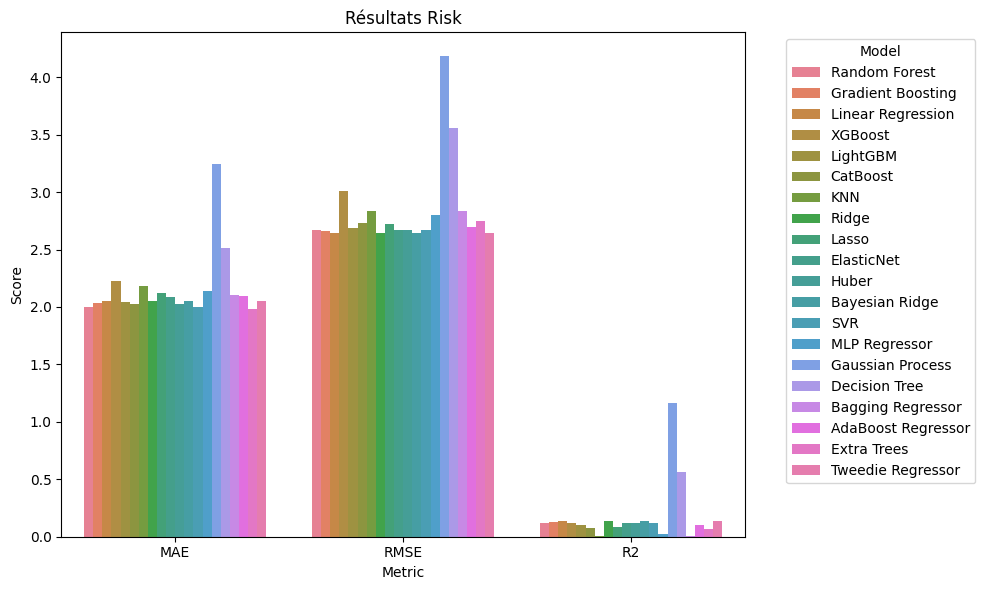

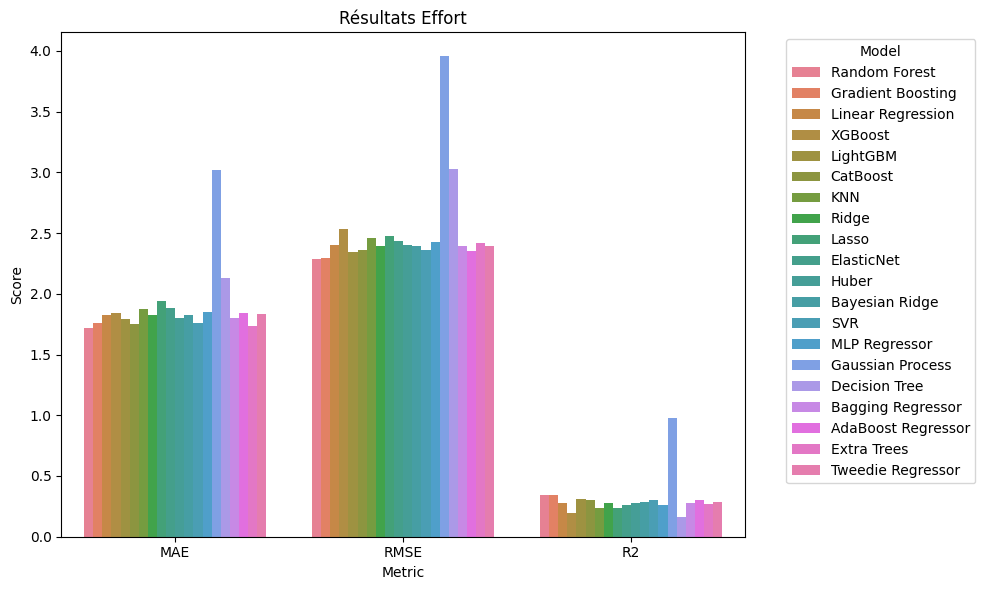

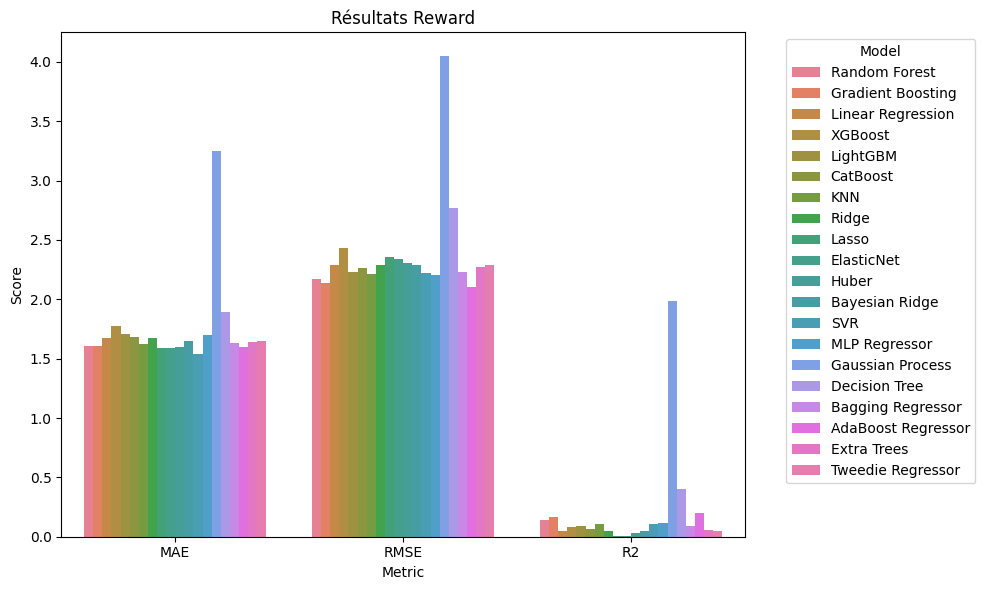

In [ ]:
plot_results(results_risk, "Résultats Risk")
plot_results(results_effort, "Résultats Effort")
plot_results(results_reward, "Résultats Reward")

# TESTS avec fichier avec 18 réponses exactes par personne

In [ ]:
df=pd.read_csv('merged_output_exactly_18.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

genre  age nationalite niveauEtudes                             sessionId  \
0  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
1  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
2  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
3  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
4  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot          8          5       8   
1     risk-reward  Femme petite taille          4          7       5   
2     risk-effort               Enfant          5          3       3   
3   effort-reward               Enfant          3          3       3   
4   effort-reward  Femme grande taille          5          5       7   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée          2          5       3  
1                Robot          6          3       8  
2  Femme petite taille          5          7       5  
3  Femme petite taille          7          7       5  
4  Homme petite taille          5          5       6

Nombre total de lignes : 954


In [ ]:
df_bin = df.copy()

label_encoders = {}
for col in [ 'genre','age','niveauEtudes','nationalite', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# on filtre les datasets
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[['associationType', 'genre', 'age','niveauEtudes', 'nationalite','personAType', 'personBType', 'forceA', 'forceB']]
X_effort = effort_df[['associationType', 'genre','age','niveauEtudes', 'nationalite', 'personAType', 'personBType', 'forceA', 'forceB']]
X_reward = reward_df[['associationType', 'personAType', 'genre','age','niveauEtudes','nationalite','personBType', 'forceA', 'forceB']]

# def y selon la colonne correspondant à la dimension

# RISK
risk_reward_code = label_encoders['associationType'].transform(['risk-reward'])[0]
risk_effort_code = label_encoders['associationType'].transform(['risk-effort'])[0]

risk_part1 = risk_df[risk_df['associationType'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType'] == risk_reward_code][['valueOneA', 'valueOneB']]
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()


# EFFORT
effort_effort_code = label_encoders['associationType'].transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType'] == effort_effort_code][['valueOneA', 'valueOneB']]
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()


# REWARD
reward_part1 = reward_df[reward_df['associationType'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()

reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()




In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import TweedieRegressor


models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42)),
    "KNN": KNeighborsRegressor(),

    # Nouveaux modèles
    "Ridge": MultiOutputRegressor(Ridge()),
    "Lasso": MultiOutputRegressor(Lasso()),
    "ElasticNet": MultiOutputRegressor(ElasticNet()),
    "Huber": MultiOutputRegressor(HuberRegressor()),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge()),
    "SVR": MultiOutputRegressor(SVR()),
    "MLP Regressor": MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=1000)),
    "Bagging Regressor": MultiOutputRegressor(BaggingRegressor(random_state=42)),
    "AdaBoost Regressor": MultiOutputRegressor(AdaBoostRegressor(random_state=42)),
    "Extra Trees": MultiOutputRegressor(ExtraTreesRegressor(random_state=42)),
    "Tweedie Regressor": MultiOutputRegressor(TweedieRegressor(power=0, alpha=0.5))

}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)

def plot_results(results_df, title):
    df_copy = results_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)
    melted = pd.melt(df_copy, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# Évaluer
results_risk = evaluate_models(X_risk, y_risk)
results_effort = evaluate_models(X_effort, y_effort)
results_reward = evaluate_models(X_reward, y_reward)

# Afficher
print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Risk :")
display(results_risk)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Effort :")
display(results_effort)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Reward :")
display(results_reward)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

Model            MAE           RMSE              R2
0        Random Forest  2.067 ± 0.061  2.695 ± 0.064   0.141 ± 0.032
1    Gradient Boosting  2.060 ± 0.071  2.687 ± 0.101   0.147 ± 0.044
2    Linear Regression  2.074 ± 0.071  2.666 ± 0.117   0.160 ± 0.056
3              XGBoost  2.339 ± 0.110  3.055 ± 0.083  -0.105 ± 0.067
4             LightGBM  2.089 ± 0.055  2.734 ± 0.068   0.117 ± 0.031
5             CatBoost  2.150 ± 0.106  2.814 ± 0.100   0.063 ± 0.070
6                  KNN  2.192 ± 0.089  2.858 ± 0.113   0.034 ± 0.064
7                Ridge  2.074 ± 0.071  2.666 ± 0.117   0.160 ± 0.056
8                Lasso  2.167 ± 0.057  2.751 ± 0.078   0.106 ± 0.031
9           ElasticNet  2.123 ± 0.061  2.700 ± 0.094   0.138 ± 0.041
10               Huber  2.036 ± 0.080  2.685 ± 0.150   0.147 ± 0.077
11      Bayesian Ridge  2.078 ± 0.071  2.663 ± 0.115   0.162 ± 0.055
12                 SVR  1.990 ± 0.104  2.648 ± 0.162   0.170 ± 0.082
13       MLP Regressor  2.155 ± 0.115  2.857 ± 0.110   0.035 ± 0.055
14    Gaussian Process  3.440 ± 0.104  4.326 ± 0.122  -1.216 ± 0.148
15       Decision Tree  2.630 ± 0.237  3.595 ± 0.252  -0.538 ± 0.228
16   Bagging Regressor  2.129 ± 0.086  2.799 ± 0.120   0.072 ± 0.080
17  AdaBoost Regressor  2.180 ± 0.073  2.742 ± 0.078   0.111 ± 0.040
18         Extra Trees  2.088 ± 0.071  2.778 ± 0.065   0.087 ± 0.045
19   Tweedie Regressor  2.080 ± 0.071  2.662 ± 0.113   0.162 ± 0.054

-----------------------------------------------------------

 Résultats pour la dimension Effort :


Model            MAE           RMSE              R2
0        Random Forest  1.723 ± 0.117  2.302 ± 0.186   0.375 ± 0.106
1    Gradient Boosting  1.743 ± 0.095  2.288 ± 0.142   0.385 ± 0.081
2    Linear Regression  1.817 ± 0.085  2.393 ± 0.150   0.328 ± 0.077
3              XGBoost  1.850 ± 0.159  2.504 ± 0.229   0.259 ± 0.150
4             LightGBM  1.794 ± 0.088  2.332 ± 0.150   0.360 ± 0.090
5             CatBoost  1.788 ± 0.088  2.406 ± 0.133   0.320 ± 0.083
6                  KNN  1.903 ± 0.068  2.503 ± 0.135   0.263 ± 0.088
7                Ridge  1.817 ± 0.085  2.393 ± 0.150   0.328 ± 0.077
8                Lasso  1.951 ± 0.065  2.487 ± 0.112   0.276 ± 0.051
9           ElasticNet  1.895 ± 0.066  2.435 ± 0.127   0.305 ± 0.062
10               Huber  1.797 ± 0.103  2.404 ± 0.181   0.321 ± 0.094
11      Bayesian Ridge  1.821 ± 0.084  2.390 ± 0.151   0.329 ± 0.077
12                 SVR  1.784 ± 0.095  2.377 ± 0.165   0.335 ± 0.089
13       MLP Regressor  1.941 ± 0.108  2.549 ± 0.151   0.236 ± 0.092
14    Gaussian Process  3.279 ± 0.106  4.183 ± 0.139  -1.052 ± 0.151
15       Decision Tree  2.063 ± 0.109  2.962 ± 0.167  -0.032 ± 0.134
16   Bagging Regressor  1.803 ± 0.145  2.401 ± 0.205   0.320 ± 0.126
17  AdaBoost Regressor  1.884 ± 0.064  2.373 ± 0.098   0.340 ± 0.056
18         Extra Trees  1.783 ± 0.098  2.444 ± 0.137   0.298 ± 0.083
19   Tweedie Regressor  1.832 ± 0.080  2.391 ± 0.145   0.329 ± 0.073

-----------------------------------------------------------

 Résultats pour la dimension Reward :


Model            MAE           RMSE              R2
0        Random Forest  1.504 ± 0.076  2.014 ± 0.132   0.280 ± 0.077
1    Gradient Boosting  1.553 ± 0.119  2.033 ± 0.124   0.266 ± 0.081
2    Linear Regression  1.698 ± 0.133  2.296 ± 0.105   0.064 ± 0.079
3              XGBoost  1.650 ± 0.056  2.262 ± 0.143   0.091 ± 0.104
4             LightGBM  1.589 ± 0.109  2.075 ± 0.096   0.236 ± 0.061
5             CatBoost  1.561 ± 0.109  2.100 ± 0.137   0.216 ± 0.090
6                  KNN  1.598 ± 0.136  2.200 ± 0.126   0.138 ± 0.110
7                Ridge  1.698 ± 0.133  2.296 ± 0.104   0.064 ± 0.079
8                Lasso  1.620 ± 0.068  2.395 ± 0.050  -0.017 ± 0.014
9           ElasticNet  1.624 ± 0.083  2.357 ± 0.048   0.015 ± 0.027
10               Huber  1.630 ± 0.094  2.313 ± 0.073   0.052 ± 0.046
11      Bayesian Ridge  1.676 ± 0.121  2.299 ± 0.090   0.062 ± 0.068
12                 SVR  1.535 ± 0.083  2.176 ± 0.055   0.161 ± 0.021
13       MLP Regressor  1.735 ± 0.131  2.222 ± 0.132   0.121 ± 0.116
14    Gaussian Process  3.502 ± 0.053  4.238 ± 0.022  -2.186 ± 0.131
15       Decision Tree  1.828 ± 0.089  2.639 ± 0.093  -0.237 ± 0.095
16   Bagging Regressor  1.538 ± 0.111  2.108 ± 0.133   0.211 ± 0.082
17  AdaBoost Regressor  1.589 ± 0.117  2.081 ± 0.094   0.232 ± 0.054
18         Extra Trees  1.524 ± 0.109  2.063 ± 0.157   0.242 ± 0.103
19   Tweedie Regressor  1.676 ± 0.120  2.296 ± 0.092   0.065 ± 0.068

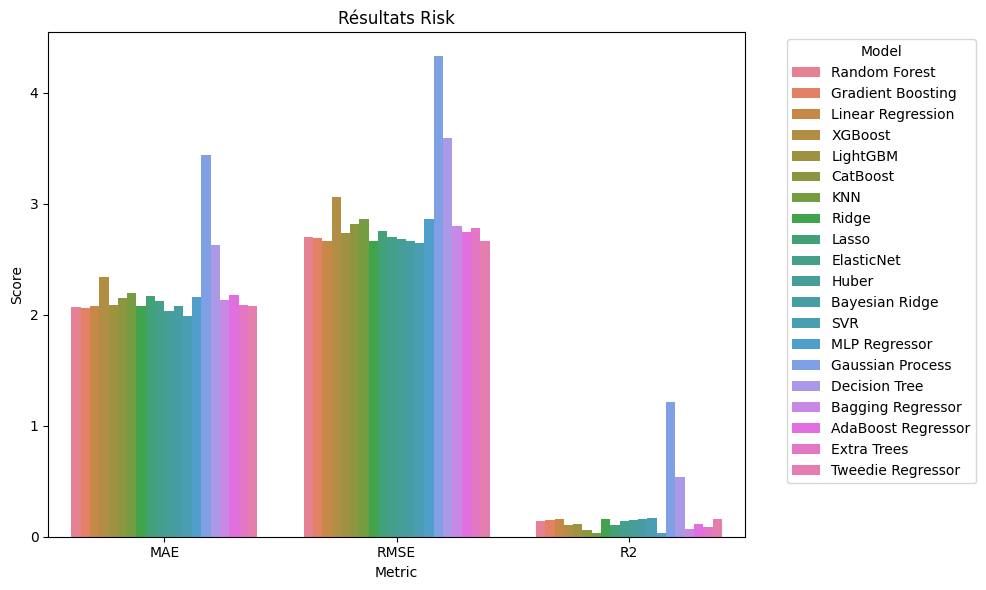

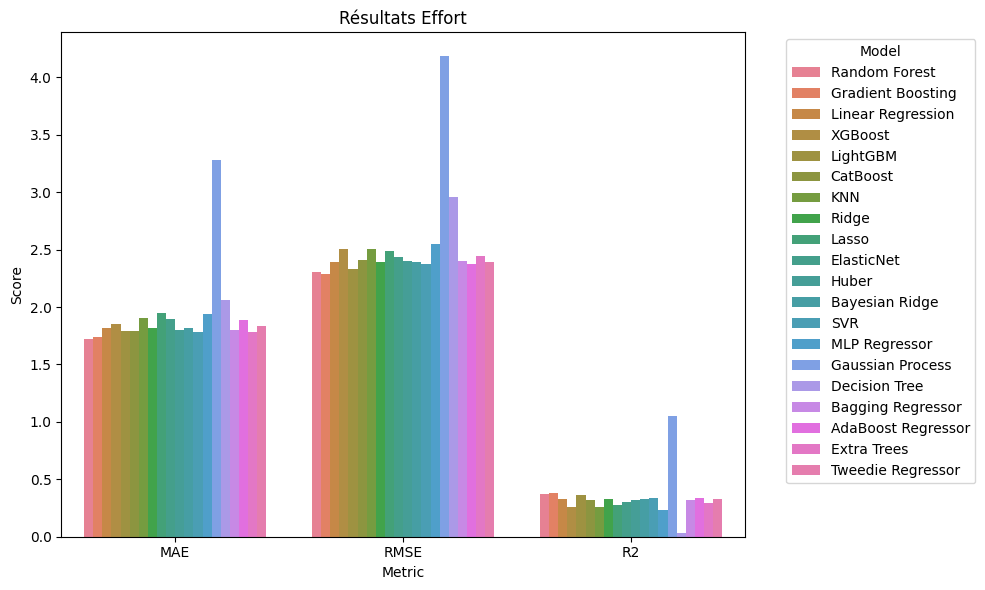

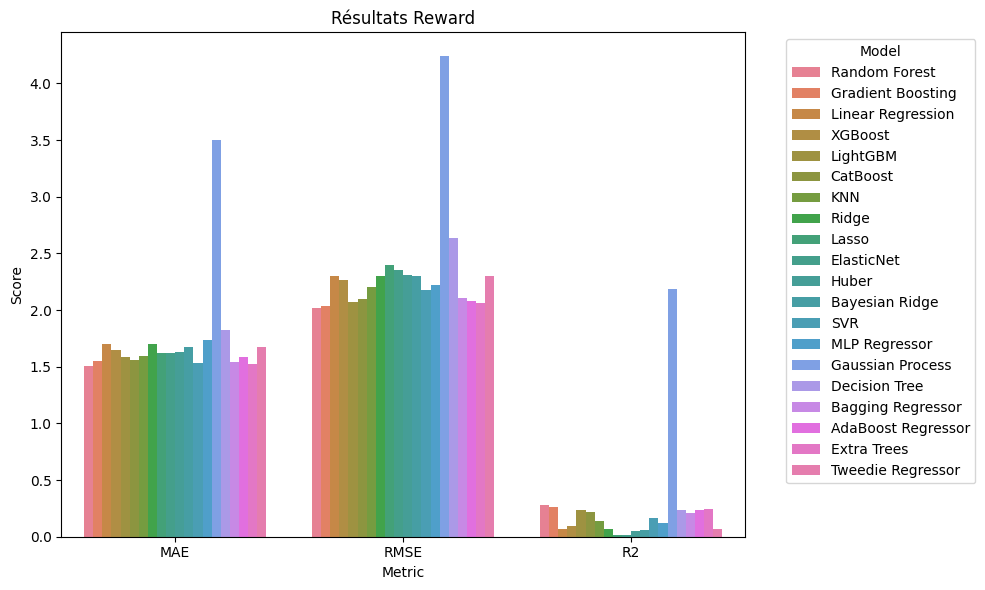

In [ ]:
plot_results(results_risk, "Résultats Risk")
plot_results(results_effort, "Résultats Effort")
plot_results(results_reward, "Résultats Reward")

# TESTS avec fichiers avec des NaN pour compléter les 18 réponses par personne

In [ ]:
df=pd.read_csv('merged_output_completed.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

genre  age nationalite niveauEtudes                             sessionId  \
0  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
1  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
2  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
3  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
4  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot        5.0        5.0     5.0   
1     risk-effort  Homme petite taille        5.0        5.0     1.0   
2     risk-effort  Femme grande taille        5.0        5.0     1.0   
3     risk-reward               Enfant        5.0        5.0     1.0   
4     risk-reward        Personne âgée        5.0        5.0     1.0   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée        5.0        5.0     1.0  
1        Personne âgée        5.0        5.0     1.0  
2  Homme grande taille        5.0        5.0     1.0  
3  Homme grande taille        5.0        5.0     1.0  
4               Enfant        5.0        5.0     1.0

Nombre total de lignes : 1798


In [ ]:

label_encoders = {}
for col in ['genre', 'age', 'nationalite', 'niveauEtudes', 'sessionId']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


display(df.head())


joueur_0 = df[df['sessionId'] == 0]

display(joueur_0)

joueur_4 = df[df['sessionId'] == 4]

display(joueur_4)

joueur_88 = df[df['sessionId'] == 88]

display(joueur_88)


genre  age  nationalite  niveauEtudes  sessionId  associationType  \
0      0    8            2             3          0                2   
1      0    8            2             3          0                1   
2      0    8            2             3          0                1   
3      0    8            2             3          0                2   
4      0    8            2             3          0                2   

           personAType  valueOneA  valueTwoA  forceA          personBType  \
0                Robot        5.0        5.0     5.0        Personne âgée   
1  Homme petite taille        5.0        5.0     1.0        Personne âgée   
2  Femme grande taille        5.0        5.0     1.0  Homme grande taille   
3               Enfant        5.0        5.0     1.0  Homme grande taille   
4        Personne âgée        5.0        5.0     1.0               Enfant   

   valueOneB  valueTwoB  forceB  
0        5.0        5.0     1.0  
1        5.0        5.0     1.0  
2        5.0        5.0     1.0  
3        5.0        5.0     1.0  
4        5.0        5.0     1.0

genre  age  nationalite  niveauEtudes  sessionId  associationType  \
0       0    8            2             3          0                2   
1       0    8            2             3          0                1   
2       0    8            2             3          0                1   
3       0    8            2             3          0                2   
4       0    8            2             3          0                2   
5       0    8            2             3          0                0   
6       0    8            2             3          0                1   
7       0    8            2             3          0                0   
8       0    8            2             3          0                3   
9       0    8            2             3          0                3   
10      0    8            2             3          0                3   
11      0    8            2             3          0                3   
12      0    8            2             3          0                3   
13      0    8            2             3          0                3   
14      0    8            2             3          0                3   
15      0    8            2             3          0                3   
16      0    8            2             3          0                3   
17      0    8            2             3          0                3   

            personAType  valueOneA  valueTwoA  forceA          personBType  \
0                 Robot        5.0        5.0     5.0        Personne âgée   
1   Homme petite taille        5.0        5.0     1.0        Personne âgée   
2   Femme grande taille        5.0        5.0     1.0  Homme grande taille   
3                Enfant        5.0        5.0     1.0  Homme grande taille   
4         Personne âgée        5.0        5.0     1.0               Enfant   
5         Personne âgée        5.0        5.0     1.0  Femme petite taille   
6                 Robot        5.0        5.0     5.0  Femme petite taille   
7   Femme grande taille        5.0        5.0     1.0  Homme petite taille   
8                   NaN        NaN        NaN     NaN                  NaN   
9                   NaN        NaN        NaN     NaN                  NaN   
10                  NaN        NaN        NaN     NaN                  NaN   
11                  NaN        NaN        NaN     NaN                  NaN   
12                  NaN        NaN        NaN     NaN                  NaN   
13                  NaN        NaN        NaN     NaN                  NaN   
14                  NaN        NaN        NaN     NaN                  NaN   
15                  NaN        NaN        NaN     NaN                  NaN   
16                  NaN        NaN        NaN     NaN                  NaN   
17                  NaN        NaN        NaN     NaN                  NaN   

    valueOneB  valueTwoB  forceB  
0         5.0        5.0     1.0  
1         5.0        5.0     1.0  
2         5.0        5.0     1.0  
3         5.0        5.0     1.0  
4         5.0        5.0     1.0  
5         5.0        5.0     8.0  
6         5.0        5.0     8.0  
7         5.0        5.0     1.0  
8         NaN        NaN     NaN  
9         NaN        NaN     NaN  
10        NaN        NaN     NaN  
11        NaN        NaN     NaN  
12        NaN        NaN     NaN  
13        NaN        NaN     NaN  
14        NaN        NaN     NaN  
15        NaN        NaN     NaN  
16        NaN        NaN     NaN  
17        NaN        NaN     NaN

genre  age  nationalite  niveauEtudes  sessionId  associationType  \
88       0    6            3             2          4                1   
89       0    6            3             2          4                0   
90       0    6            3             2          4                3   
91       0    6            3             2          4                3   
92       0    6            3             2          4                3   
93       0    6            3             2          4                3   
94       0    6            3             2          4                3   
95       0    6            3             2          4                3   
96       0    6            3             2          4                3   
97       0    6            3             2          4                3   
98       0    6            3             2          4                3   
99       0    6            3             2          4                3   
100      0    6            3             2          4                3   
101      0    6            3             2          4                3   
102      0    6            3             2          4                3   
103      0    6            3             2          4                3   
104      0    6            3             2          4                3   
105      0    6            3             2          4                3   

    personAType  valueOneA  valueTwoA  forceA          personBType  valueOneB  \
88        Robot        7.0        8.0    10.0               Enfant        3.0   
89        Robot        6.0        4.0    10.0  Femme petite taille        4.0   
90          NaN        NaN        NaN     NaN                  NaN        NaN   
91          NaN        NaN        NaN     NaN                  NaN        NaN   
92          NaN        NaN        NaN     NaN                  NaN        NaN   
93          NaN        NaN        NaN     NaN                  NaN        NaN   
94          NaN        NaN        NaN     NaN                  NaN        NaN   
95          NaN        NaN        NaN     NaN                  NaN        NaN   
96          NaN        NaN        NaN     NaN                  NaN        NaN   
97          NaN        NaN        NaN     NaN                  NaN        NaN   
98          NaN        NaN        NaN     NaN                  NaN        NaN   
99          NaN        NaN        NaN     NaN                  NaN        NaN   
100         NaN        NaN        NaN     NaN                  NaN        NaN   
101         NaN        NaN        NaN     NaN                  NaN        NaN   
102         NaN        NaN        NaN     NaN                  NaN        NaN   
103         NaN        NaN        NaN     NaN                  NaN        NaN   
104         NaN        NaN        NaN     NaN                  NaN        NaN   
105         NaN        NaN        NaN     NaN                  NaN        NaN   

     valueTwoB  forceB  
88         2.0     1.0  
89         6.0     5.0  
90         NaN     NaN  
91         NaN     NaN  
92         NaN     NaN  
93         NaN     NaN  
94         NaN     NaN  
95         NaN     NaN  
96         NaN     NaN  
97         NaN     NaN  
98         NaN     NaN  
99         NaN     NaN  
100        NaN     NaN  
101        NaN     NaN  
102        NaN     NaN  
103        NaN     NaN  
104        NaN     NaN  
105        NaN     NaN

genre  age  nationalite  niveauEtudes  sessionId  associationType  \
1708      0   12            2             4         88                0   
1709      0   12            2             4         88                1   
1710      0   12            2             4         88                1   
1711      0   12            2             4         88                2   
1712      0   12            2             4         88                2   
1713      0   12            2             4         88                3   
1714      0   12            2             4         88                3   
1715      0   12            2             4         88                3   
1716      0   12            2             4         88                3   
1717      0   12            2             4         88                3   
1718      0   12            2             4         88                3   
1719      0   12            2             4         88                3   
1720      0   12            2             4         88                3   
1721      0   12            2             4         88                3   
1722      0   12            2             4         88                3   
1723      0   12            2             4         88                3   
1724      0   12            2             4         88                3   
1725      0   12            2             4         88                3   

              personAType  valueOneA  valueTwoA  forceA          personBType  \
1708               Enfant        5.0        5.0     1.0  Homme grande taille   
1709        Personne âgée       10.0        0.0     1.0  Homme grande taille   
1710  Homme grande taille        5.0        5.0     1.0               Enfant   
1711  Homme grande taille        5.0        5.0     1.0                Robot   
1712        Personne âgée        0.0        3.0     1.0  Homme petite taille   
1713                  NaN        NaN        NaN     NaN                  NaN   
1714                  NaN        NaN        NaN     NaN                  NaN   
1715                  NaN        NaN        NaN     NaN                  NaN   
1716                  NaN        NaN        NaN     NaN                  NaN   
1717                  NaN        NaN        NaN     NaN                  NaN   
1718                  NaN        NaN        NaN     NaN                  NaN   
1719                  NaN        NaN        NaN     NaN                  NaN   
1720                  NaN        NaN        NaN     NaN                  NaN   
1721                  NaN        NaN        NaN     NaN                  NaN   
1722                  NaN        NaN        NaN     NaN                  NaN   
1723                  NaN        NaN        NaN     NaN                  NaN   
1724                  NaN        NaN        NaN     NaN                  NaN   
1725                  NaN        NaN        NaN     NaN                  NaN   

      valueOneB  valueTwoB  forceB  
1708        5.0        5.0     1.0  
1709        0.0       10.0     1.0  
1710        5.0        5.0     1.0  
1711        5.0        5.0     1.0  
1712       10.0        7.0     1.0  
1713        NaN        NaN     NaN  
1714        NaN        NaN     NaN  
1715        NaN        NaN     NaN  
1716        NaN        NaN     NaN  
1717        NaN        NaN     NaN  
1718        NaN        NaN     NaN  
1719        NaN        NaN     NaN  
1720        NaN        NaN     NaN  
1721        NaN        NaN     NaN  
1722        NaN        NaN     NaN  
1723        NaN        NaN     NaN  
1724        NaN        NaN     NaN  
1725        NaN        NaN     NaN

# Fichier avec NaN complétés pour avoir des sessions COMPLETES


---



In [ ]:
df=pd.read_csv('merged_output_final_54.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

genre  age nationalite niveauEtudes                             sessionId  \
0  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
1  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
2  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
3  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
4  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot        5.0        5.0     5.0   
1     risk-effort  Homme petite taille        5.0        5.0     1.0   
2     risk-effort  Femme grande taille        5.0        5.0     1.0   
3     risk-reward               Enfant        5.0        5.0     1.0   
4     risk-reward        Personne âgée        5.0        5.0     1.0   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée        5.0        5.0     1.0  
1        Personne âgée        5.0        5.0     1.0  
2  Homme grande taille        5.0        5.0     1.0  
3  Homme grande taille        5.0        5.0     1.0  
4               Enfant        5.0        5.0     1.0

Nombre total de lignes : 1926


In [ ]:
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42))
}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)

def plot_results(results_df, title):
    df_copy = results_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)
    melted = pd.melt(df_copy, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### On teste une méthode d'imputation avec ce nouveau fichier

In [ ]:
def impute_session_forces(df2):
    df_imputed = df2.copy()

    # On parcourt chaque session incomplète
    for session_id in df2['sessionId'].unique():
        session_df = df2[df2['sessionId'] == session_id]

        # Dictionnaire des forces déjà vues pour un type donné
        force_memory_A = session_df.dropna(subset=['personAType', 'forceA']).groupby('personAType')['forceA'].agg(lambda x: x.mode()[0] if not x.empty else np.nan).to_dict()
        force_memory_B = session_df.dropna(subset=['personBType', 'forceB']).groupby('personBType')['forceB'].agg(lambda x: x.mode()[0] if not x.empty else np.nan).to_dict()

        for idx, row in session_df.iterrows():
            if pd.isna(row['forceA']):
                df_imputed.at[idx, 'forceA'] = force_memory_A.get(row['personAType'], np.nan)
            if pd.isna(row['forceB']):
                df_imputed.at[idx, 'forceB'] = force_memory_B.get(row['personBType'], np.nan)

    return df_imputed


In [ ]:
def impute_values_by_type(df2):
    df_imputed = df2.copy()

    # Moyennes par type de scénario
    for atype in df2['associationType'].dropna().unique():
        temp = df2[df2['associationType'] == atype]

        mean_valueOneA = temp['valueOneA'].mean()
        mean_valueOneB = temp['valueOneB'].mean()
        mean_valueTwoA = temp['valueTwoA'].mean()
        mean_valueTwoB = temp['valueTwoB'].mean()

        mask = df2['associationType'] == atype

        df_imputed.loc[mask & df['valueOneA'].isna(), 'valueOneA'] = mean_valueOneA
        df_imputed.loc[mask & df['valueOneB'].isna(), 'valueOneB'] = mean_valueOneB
        df_imputed.loc[mask & df['valueTwoA'].isna(), 'valueTwoA'] = mean_valueTwoA
        df_imputed.loc[mask & df['valueTwoB'].isna(), 'valueTwoB'] = mean_valueTwoB

    return df_imputed


In [ ]:
df_clean = impute_session_forces(df.copy())
df_clean = impute_values_by_type(df_clean)

In [ ]:
# Ensuite tu encodes
label_encoders = {}
for col in ['genre', 'age', 'nationalite', 'niveauEtudes', 'sessionId', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

df_bin = df_clean  # on remplace l'ancien encodé

In [ ]:
df_bin['sum_valueOne'] = df_bin['valueOneA'] + df_bin['valueOneB']
df_bin['sum_valueTwo'] = df_bin['valueTwoA'] + df_bin['valueTwoB']

print("Valeurs différentes de 10 (valueOne):", (df_bin['sum_valueOne'] != 10).sum())


Valeurs différentes de 10 (valueOne): 528


In [ ]:
joueur_0 = df[df['sessionId'] == 0]

display(joueur_0)

joueur_4 = df[df['sessionId'] == 4]

display(joueur_4)

joueur_88 = df[df['sessionId'] == 88]

display(joueur_88)


Empty DataFrame
Columns: [genre, age, nationalite, niveauEtudes, sessionId, associationType, personAType, valueOneA, valueTwoA, forceA, personBType, valueOneB, valueTwoB, forceB]
Index: []

Empty DataFrame
Columns: [genre, age, nationalite, niveauEtudes, sessionId, associationType, personAType, valueOneA, valueTwoA, forceA, personBType, valueOneB, valueTwoB, forceB]
Index: []

Empty DataFrame
Columns: [genre, age, nationalite, niveauEtudes, sessionId, associationType, personAType, valueOneA, valueTwoA, forceA, personBType, valueOneB, valueTwoB, forceB]
Index: []

In [ ]:
joueur_0 = df_bin[df_bin['sessionId'] == 0]

display(joueur_0)

joueur_4 = df_bin[df_bin['sessionId'] == 4]

display(joueur_4)

joueur_88 = df_bin[df_bin['sessionId'] == 88]

display(joueur_88)

genre  age  nationalite  niveauEtudes  sessionId  associationType  \
0       0    8            2             3          0                2   
1       0    8            2             3          0                1   
2       0    8            2             3          0                1   
3       0    8            2             3          0                2   
4       0    8            2             3          0                2   
5       0    8            2             3          0                0   
6       0    8            2             3          0                1   
7       0    8            2             3          0                0   
8       0    8            2             3          0                3   
9       0    8            2             3          0                3   
10      0    8            2             3          0                3   
11      0    8            2             3          0                3   
12      0    8            2             3          0                3   
13      0    8            2             3          0                3   
14      0    8            2             3          0                3   
15      0    8            2             3          0                3   
16      0    8            2             3          0                3   
17      0    8            2             3          0                3   

    personAType  valueOneA  valueTwoA  forceA  personBType  valueOneB  \
0             6        5.0        5.0     5.0            5        5.0   
1             4        5.0        5.0     1.0            5        5.0   
2             1        5.0        5.0     1.0            3        5.0   
3             0        5.0        5.0     1.0            3        5.0   
4             5        5.0        5.0     1.0            0        5.0   
5             5        5.0        5.0     1.0            2        5.0   
6             6        5.0        5.0     5.0            2        5.0   
7             1        5.0        5.0     1.0            4        5.0   
8             7        NaN        NaN     NaN            7        NaN   
9             7        NaN        NaN     NaN            7        NaN   
10            7        NaN        NaN     NaN            7        NaN   
11            7        NaN        NaN     NaN            7        NaN   
12            7        NaN        NaN     NaN            7        NaN   
13            7        NaN        NaN     NaN            7        NaN   
14            7        NaN        NaN     NaN            7        NaN   
15            7        NaN        NaN     NaN            7        NaN   
16            7        NaN        NaN     NaN            7        NaN   
17            7        NaN        NaN     NaN            7        NaN   

    valueTwoB  forceB  sum_valueOne  sum_valueTwo  
0         5.0     1.0          10.0          10.0  
1         5.0     1.0          10.0          10.0  
2         5.0     1.0          10.0          10.0  
3         5.0     1.0          10.0          10.0  
4         5.0     1.0          10.0          10.0  
5         5.0     8.0          10.0          10.0  
6         5.0     8.0          10.0          10.0  
7         5.0     1.0          10.0          10.0  
8         NaN     NaN           NaN           NaN  
9         NaN     NaN           NaN           NaN  
10        NaN     NaN           NaN           NaN  
11        NaN     NaN           NaN           NaN  
12        NaN     NaN           NaN           NaN  
13        NaN     NaN           NaN           NaN  
14        NaN     NaN           NaN           NaN  
15        NaN     NaN           NaN           NaN  
16        NaN     NaN           NaN           NaN  
17        NaN     NaN           NaN           NaN

genre  age  nationalite  niveauEtudes  sessionId  associationType  \
90       0    6            3             2          4                1   
91       0    6            3             2          4                0   
92       0    6            3             2          4                3   
93       0    6            3             2          4                3   
94       0    6            3             2          4                3   
95       0    6            3             2          4                3   
96       0    6            3             2          4                3   
97       0    6            3             2          4                3   
98       0    6            3             2          4                3   
99       0    6            3             2          4                3   
100      0    6            3             2          4                3   
101      0    6            3             2          4                3   
102      0    6            3             2          4                3   
103      0    6            3             2          4                3   
104      0    6            3             2          4                3   
105      0    6            3             2          4                3   
106      0    6            3             2          4                3   
107      0    6            3             2          4                3   

     personAType  valueOneA  valueTwoA  forceA  personBType  valueOneB  \
90             6        7.0        8.0    10.0            0        3.0   
91             6        6.0        4.0    10.0            2        4.0   
92             7        NaN        NaN     NaN            7        NaN   
93             7        NaN        NaN     NaN            7        NaN   
94             7        NaN        NaN     NaN            7        NaN   
95             7        NaN        NaN     NaN            7        NaN   
96             7        NaN        NaN     NaN            7        NaN   
97             7        NaN        NaN     NaN            7        NaN   
98             7        NaN        NaN     NaN            7        NaN   
99             7        NaN        NaN     NaN            7        NaN   
100            7        NaN        NaN     NaN            7        NaN   
101            7        NaN        NaN     NaN            7        NaN   
102            7        NaN        NaN     NaN            7        NaN   
103            7        NaN        NaN     NaN            7        NaN   
104            7        NaN        NaN     NaN            7        NaN   
105            7        NaN        NaN     NaN            7        NaN   
106            7        NaN        NaN     NaN            7        NaN   
107            7        NaN        NaN     NaN            7        NaN   

     valueTwoB  forceB  sum_valueOne  sum_valueTwo  
90         2.0     1.0          10.0          10.0  
91         6.0     5.0          10.0          10.0  
92         NaN     NaN           NaN           NaN  
93         NaN     NaN           NaN           NaN  
94         NaN     NaN           NaN           NaN  
95         NaN     NaN           NaN           NaN  
96         NaN     NaN           NaN           NaN  
97         NaN     NaN           NaN           NaN  
98         NaN     NaN           NaN           NaN  
99         NaN     NaN           NaN           NaN  
100        NaN     NaN           NaN           NaN  
101        NaN     NaN           NaN           NaN  
102        NaN     NaN           NaN           NaN  
103        NaN     NaN           NaN           NaN  
104        NaN     NaN           NaN           NaN  
105        NaN     NaN           NaN           NaN  
106        NaN     NaN           NaN           NaN  
107        NaN     NaN           NaN           NaN

genre  age  nationalite  niveauEtudes  sessionId  associationType  \
1836      0   12            2             4         88                0   
1837      0   12            2             4         88                1   
1838      0   12            2             4         88                1   
1839      0   12            2             4         88                2   
1840      0   12            2             4         88                2   
1841      0   12            2             4         88                3   
1842      0   12            2             4         88                3   
1843      0   12            2             4         88                3   
1844      0   12            2             4         88                3   
1845      0   12            2             4         88                3   
1846      0   12            2             4         88                3   
1847      0   12            2             4         88                3   
1848      0   12            2             4         88                3   
1849      0   12            2             4         88                3   
1850      0   12            2             4         88                3   
1851      0   12            2             4         88                3   
1852      0   12            2             4         88                3   
1853      0   12            2             4         88                3   

      personAType  valueOneA  valueTwoA  forceA  personBType  valueOneB  \
1836            0        5.0        5.0     1.0            3        5.0   
1837            5       10.0        0.0     1.0            3        0.0   
1838            3        5.0        5.0     1.0            0        5.0   
1839            3        5.0        5.0     1.0            6        5.0   
1840            5        0.0        3.0     1.0            4       10.0   
1841            7        NaN        NaN     NaN            7        NaN   
1842            7        NaN        NaN     NaN            7        NaN   
1843            7        NaN        NaN     NaN            7        NaN   
1844            7        NaN        NaN     NaN            7        NaN   
1845            7        NaN        NaN     NaN            7        NaN   
1846            7        NaN        NaN     NaN            7        NaN   
1847            7        NaN        NaN     NaN            7        NaN   
1848            7        NaN        NaN     NaN            7        NaN   
1849            7        NaN        NaN     NaN            7        NaN   
1850            7        NaN        NaN     NaN            7        NaN   
1851            7        NaN        NaN     NaN            7        NaN   
1852            7        NaN        NaN     NaN            7        NaN   
1853            7        NaN        NaN     NaN            7        NaN   

      valueTwoB  forceB  sum_valueOne  sum_valueTwo  
1836        5.0     1.0          10.0          10.0  
1837       10.0     1.0          10.0          10.0  
1838        5.0     1.0          10.0          10.0  
1839        5.0     1.0          10.0          10.0  
1840        7.0     1.0          10.0          10.0  
1841        NaN     NaN           NaN           NaN  
1842        NaN     NaN           NaN           NaN  
1843        NaN     NaN           NaN           NaN  
1844        NaN     NaN           NaN           NaN  
1845        NaN     NaN           NaN           NaN  
1846        NaN     NaN           NaN           NaN  
1847        NaN     NaN           NaN           NaN  
1848        NaN     NaN           NaN           NaN  
1849        NaN     NaN           NaN           NaN  
1850        NaN     NaN           NaN           NaN  
1851        NaN     NaN           NaN           NaN  
1852        NaN     NaN           NaN           NaN  
1853        NaN     NaN           NaN           NaN

In [ ]:
df_bin = df_clean

label_encoders = {}
for col in ['genre', 'age', 'nationalite', 'niveauEtudes', 'sessionId', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# les blocs suivants ne changent pas :
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[['associationType', 'genre', 'age','niveauEtudes', 'personAType', 'personBType', 'forceA', 'forceB']]
X_effort = effort_df[['associationType', 'genre','age','niveauEtudes', 'personAType', 'personBType', 'forceA', 'forceB']]
X_reward = reward_df[['associationType', 'personAType', 'genre','age','niveauEtudes','personBType', 'forceA', 'forceB']]

# def y selon la colonne correspondant à la dimension

# RISK
risk_reward_code = label_encoders['associationType'].transform(['risk-reward'])[0]
risk_effort_code = label_encoders['associationType'].transform(['risk-effort'])[0]

risk_part1 = risk_df[risk_df['associationType'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType'] == risk_reward_code][['valueOneA', 'valueOneB']]
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()


# EFFORT
effort_effort_code = label_encoders['associationType'].transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType'] == effort_effort_code][['valueOneA', 'valueOneB']]
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()


# REWARD
reward_part1 = reward_df[reward_df['associationType'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()

reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()





In [ ]:
results_risk = evaluate_models(X_risk, y_risk)

results_effort = evaluate_models(X_effort, y_effort)

results_reward = evaluate_models(X_reward, y_reward)




Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [ ]:
# Afficher
print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Risk :")
display(results_risk)


print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Effort :")
display(results_effort)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Reward :")
display(results_reward)


-----------------------------------------------------------

 Résultats pour la dimension Risk :


Model            MAE           RMSE              R2
0      Random Forest  1.823 ± 0.120  2.503 ± 0.160   0.198 ± 0.087
1  Gradient Boosting  1.930 ± 0.126  2.559 ± 0.178   0.162 ± 0.093
2  Linear Regression  1.997 ± 0.117  2.574 ± 0.165   0.153 ± 0.078
3            XGBoost  2.003 ± 0.069  2.798 ± 0.094  -0.001 ± 0.046
4           LightGBM  1.952 ± 0.145  2.612 ± 0.201   0.127 ± 0.109
5           CatBoost  1.897 ± 0.132  2.591 ± 0.166   0.141 ± 0.088

-----------------------------------------------------------

 Résultats pour la dimension Effort :


Model            MAE           RMSE             R2
0      Random Forest  1.683 ± 0.091  2.314 ± 0.139  0.328 ± 0.081
1  Gradient Boosting  1.734 ± 0.095  2.286 ± 0.120  0.345 ± 0.065
2  Linear Regression  1.773 ± 0.080  2.345 ± 0.120  0.312 ± 0.057
3            XGBoost  1.800 ± 0.048  2.527 ± 0.093  0.200 ± 0.067
4           LightGBM  1.747 ± 0.085  2.335 ± 0.099  0.317 ± 0.055
5           CatBoost  1.696 ± 0.098  2.337 ± 0.118  0.316 ± 0.060

-----------------------------------------------------------

 Résultats pour la dimension Reward :


Model            MAE           RMSE             R2
0      Random Forest  1.427 ± 0.065  1.993 ± 0.085  0.246 ± 0.059
1  Gradient Boosting  1.524 ± 0.066  2.036 ± 0.075  0.215 ± 0.047
2  Linear Regression  1.643 ± 0.113  2.271 ± 0.158  0.027 ± 0.043
3            XGBoost  1.517 ± 0.089  2.154 ± 0.118  0.108 ± 0.168
4           LightGBM  1.495 ± 0.043  2.041 ± 0.058  0.208 ± 0.074
5           CatBoost  1.466 ± 0.039  2.060 ± 0.047  0.191 ± 0.097

### On teste KNN avec ce nouveau fichier

In [ ]:
df=pd.read_csv('merged_output_final_54.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

genre  age nationalite niveauEtudes                             sessionId  \
0  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
1  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
2  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
3  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
4  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot        5.0        5.0     5.0   
1     risk-effort  Homme petite taille        5.0        5.0     1.0   
2     risk-effort  Femme grande taille        5.0        5.0     1.0   
3     risk-reward               Enfant        5.0        5.0     1.0   
4     risk-reward        Personne âgée        5.0        5.0     1.0   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée        5.0        5.0     1.0  
1        Personne âgée        5.0        5.0     1.0  
2  Homme grande taille        5.0        5.0     1.0  
3  Homme grande taille        5.0        5.0     1.0  
4               Enfant        5.0        5.0     1.0

Nombre total de lignes : 1926


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import TweedieRegressor


models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42)),
    "KNN": KNeighborsRegressor(),

    # Nouveaux modèles
    "Ridge": MultiOutputRegressor(Ridge()),
    "Lasso": MultiOutputRegressor(Lasso()),
    "ElasticNet": MultiOutputRegressor(ElasticNet()),
    "Huber": MultiOutputRegressor(HuberRegressor()),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge()),
    "SVR": MultiOutputRegressor(SVR()),
    "MLP Regressor": MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=1000)),
    "Bagging Regressor": MultiOutputRegressor(BaggingRegressor(random_state=42)),
    "AdaBoost Regressor": MultiOutputRegressor(AdaBoostRegressor(random_state=42)),
    "Extra Trees": MultiOutputRegressor(ExtraTreesRegressor(random_state=42)),
    "Tweedie Regressor": MultiOutputRegressor(TweedieRegressor(power=0, alpha=0.5))

}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)

def plot_results(results_df, title):
    df_copy = results_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)
    melted = pd.melt(df_copy, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.impute import KNNImputer

df_bin = df.copy()

label_encoders = {}
for col in ['genre', 'age', 'niveauEtudes', 'nationalite', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le

# Appliquer KNN Imputer sur les colonnes numériques
columns_to_impute = ['associationType', 'personAType','personBType','forceA', 'forceB', 'valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']
imputer = KNNImputer(n_neighbors=5)
df_bin[columns_to_impute] = imputer.fit_transform(df_bin[columns_to_impute])

# Aperçu des valeurs manquantes AVANT imputation
print("Valeurs manquantes avant imputation :")
print(df[columns_to_impute].isna().sum())

# Comparaison des valeurs avant/après imputation pour quelques lignes
print("\nExemples de lignes AVANT et APRÈS imputation :")
cols_check = ['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']
print("\nAvant imputation :")
display(df[df[cols_check].isna().any(axis=1)][cols_check].head())

print("\nAprès imputation :")
display(df_bin.loc[df[cols_check].isna().any(axis=1), cols_check].head())

print("Valeurs manquantes avant imputation :")
print(df_bin[columns_to_impute].isna().sum())

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# les blocs suivants ne changent pas :
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[['associationType', 'genre', 'age','niveauEtudes', 'nationalite','personAType', 'personBType', 'forceA', 'forceB']]
X_effort = effort_df[['associationType', 'genre','age','niveauEtudes', 'nationalite', 'personAType', 'personBType', 'forceA', 'forceB']]
X_reward = reward_df[['associationType', 'personAType', 'genre','age','niveauEtudes', 'nationalite','personBType', 'forceA', 'forceB']]

# def y selon la colonne correspondant à la dimension

# RISK
risk_reward_code = label_encoders['associationType'].transform(['risk-reward'])[0]
risk_effort_code = label_encoders['associationType'].transform(['risk-effort'])[0]

risk_part1 = risk_df[risk_df['associationType'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType'] == risk_reward_code][['valueOneA', 'valueOneB']]
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()


# EFFORT
effort_effort_code = label_encoders['associationType'].transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType'] == effort_effort_code][['valueOneA', 'valueOneB']]
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()


# REWARD
reward_part1 = reward_df[reward_df['associationType'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()

reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()



Valeurs manquantes avant imputation :
associationType    528
personAType        528
personBType        528
forceA             528
forceB             528
valueOneA          528
valueOneB          528
valueTwoA          528
valueTwoB          528
dtype: int64

Exemples de lignes AVANT et APRÈS imputation :

Avant imputation :


valueOneA  valueOneB  valueTwoA  valueTwoB
8         NaN        NaN        NaN        NaN
9         NaN        NaN        NaN        NaN
10        NaN        NaN        NaN        NaN
11        NaN        NaN        NaN        NaN
12        NaN        NaN        NaN        NaN


Après imputation :


valueOneA  valueOneB  valueTwoA  valueTwoB
8         5.0        5.0        6.0        4.0
9         5.0        5.0        6.0        4.0
10        5.0        5.0        6.0        4.0
11        5.0        5.0        6.0        4.0
12        5.0        5.0        6.0        4.0

Valeurs manquantes avant imputation :
associationType    0
personAType        0
personBType        0
forceA             0
forceB             0
valueOneA          0
valueOneB          0
valueTwoA          0
valueTwoB          0
dtype: int64


In [ ]:
print("==> Avec KNN Imputer:")
results_risk = evaluate_models(X_risk, y_risk)

results_effort = evaluate_models(X_effort, y_effort)

results_reward = evaluate_models(X_reward, y_reward)


display(results_risk)
print("-----------------------------------------------------------")

display(results_effort)

print("-----------------------------------------------------------")

display(results_reward)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 749, number of used features: 9
[LightGBM] [Info] Start training from score 5.112150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Model            MAE           RMSE             R2
0        Random Forest  1.826 ± 0.106  2.494 ± 0.146  0.204 ± 0.077
1    Gradient Boosting  1.946 ± 0.128  2.570 ± 0.177  0.155 ± 0.090
2    Linear Regression  1.999 ± 0.120  2.578 ± 0.165  0.151 ± 0.078
3              XGBoost  2.008 ± 0.133  2.787 ± 0.177  0.005 ± 0.111
4             LightGBM  1.948 ± 0.146  2.588 ± 0.189  0.143 ± 0.099
5             CatBoost  1.880 ± 0.118  2.577 ± 0.169  0.150 ± 0.091
6                  KNN  2.032 ± 0.079  2.711 ± 0.119  0.061 ± 0.048
7                Ridge  1.999 ± 0.120  2.578 ± 0.165  0.151 ± 0.078
8                Lasso  2.057 ± 0.096  2.658 ± 0.104  0.098 ± 0.035
9           ElasticNet  2.028 ± 0.100  2.611 ± 0.125  0.129 ± 0.051
10               Huber  1.982 ± 0.123  2.588 ± 0.190  0.143 ± 0.095
11      Bayesian Ridge  2.002 ± 0.117  2.579 ± 0.159  0.150 ± 0.073
12                 SVR  1.918 ± 0.115  2.602 ± 0.177  0.134 ± 0.092
13       MLP Regressor  2.011 ± 0.152  2.641 ± 0.229  0.107 ± 0.121
14   Bagging Regressor  1.923 ± 0.062  2.597 ± 0.079  0.138 ± 0.048
15  AdaBoost Regressor  2.035 ± 0.075  2.615 ± 0.081  0.127 ± 0.017
16         Extra Trees  1.803 ± 0.123  2.550 ± 0.166  0.166 ± 0.102
17   Tweedie Regressor  2.003 ± 0.116  2.578 ± 0.157  0.151 ± 0.072

-----------------------------------------------------------


Model            MAE           RMSE             R2
0        Random Forest  1.663 ± 0.084  2.302 ± 0.141  0.335 ± 0.084
1    Gradient Boosting  1.691 ± 0.085  2.253 ± 0.111  0.365 ± 0.051
2    Linear Regression  1.773 ± 0.082  2.345 ± 0.120  0.312 ± 0.056
3              XGBoost  1.737 ± 0.104  2.472 ± 0.170  0.233 ± 0.099
4             LightGBM  1.705 ± 0.089  2.293 ± 0.105  0.341 ± 0.061
5             CatBoost  1.659 ± 0.090  2.300 ± 0.115  0.337 ± 0.063
6                  KNN  1.814 ± 0.043  2.404 ± 0.073  0.277 ± 0.044
7                Ridge  1.773 ± 0.082  2.345 ± 0.120  0.312 ± 0.056
8                Lasso  1.886 ± 0.070  2.423 ± 0.078  0.266 ± 0.038
9           ElasticNet  1.836 ± 0.072  2.380 ± 0.092  0.291 ± 0.047
10               Huber  1.756 ± 0.091  2.355 ± 0.136  0.305 ± 0.067
11      Bayesian Ridge  1.774 ± 0.082  2.342 ± 0.120  0.314 ± 0.056
12                 SVR  1.689 ± 0.101  2.302 ± 0.156  0.337 ± 0.068
13       MLP Regressor  1.791 ± 0.091  2.382 ± 0.131  0.290 ± 0.059
14   Bagging Regressor  1.761 ± 0.063  2.416 ± 0.123  0.267 ± 0.092
15  AdaBoost Regressor  1.844 ± 0.067  2.362 ± 0.088  0.302 ± 0.045
16         Extra Trees  1.676 ± 0.093  2.402 ± 0.180  0.274 ± 0.112
17   Tweedie Regressor  1.782 ± 0.080  2.342 ± 0.116  0.314 ± 0.054

-----------------------------------------------------------


Model            MAE           RMSE              R2
0        Random Forest  1.392 ± 0.068  1.945 ± 0.068   0.282 ± 0.052
1    Gradient Boosting  1.492 ± 0.056  2.008 ± 0.073   0.235 ± 0.054
2    Linear Regression  1.648 ± 0.114  2.277 ± 0.159   0.022 ± 0.044
3              XGBoost  1.493 ± 0.081  2.136 ± 0.090   0.132 ± 0.095
4             LightGBM  1.480 ± 0.043  2.025 ± 0.066   0.219 ± 0.089
5             CatBoost  1.436 ± 0.056  2.014 ± 0.053   0.229 ± 0.072
6                  KNN  1.566 ± 0.077  2.161 ± 0.058   0.114 ± 0.056
7                Ridge  1.648 ± 0.114  2.277 ± 0.159   0.022 ± 0.044
8                Lasso  1.529 ± 0.125  2.324 ± 0.143  -0.020 ± 0.016
9           ElasticNet  1.540 ± 0.137  2.319 ± 0.149  -0.015 ± 0.023
10               Huber  1.561 ± 0.120  2.292 ± 0.157   0.009 ± 0.035
11      Bayesian Ridge  1.617 ± 0.115  2.275 ± 0.155   0.023 ± 0.036
12                 SVR  1.493 ± 0.101  2.201 ± 0.143   0.085 ± 0.027
13       MLP Regressor  1.685 ± 0.064  2.220 ± 0.093   0.062 ± 0.102
14   Bagging Regressor  1.441 ± 0.047  2.047 ± 0.058   0.201 ± 0.096
15  AdaBoost Regressor  1.563 ± 0.086  2.071 ± 0.106   0.189 ± 0.040
16         Extra Trees  1.371 ± 0.054  1.984 ± 0.067   0.252 ± 0.072
17   Tweedie Regressor  1.621 ± 0.114  2.273 ± 0.155   0.025 ± 0.037

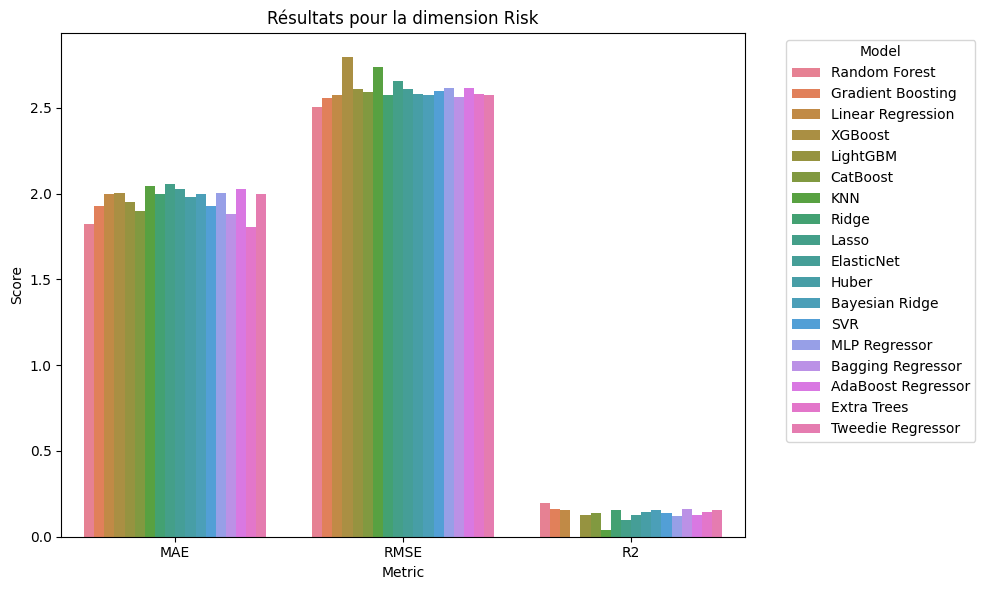

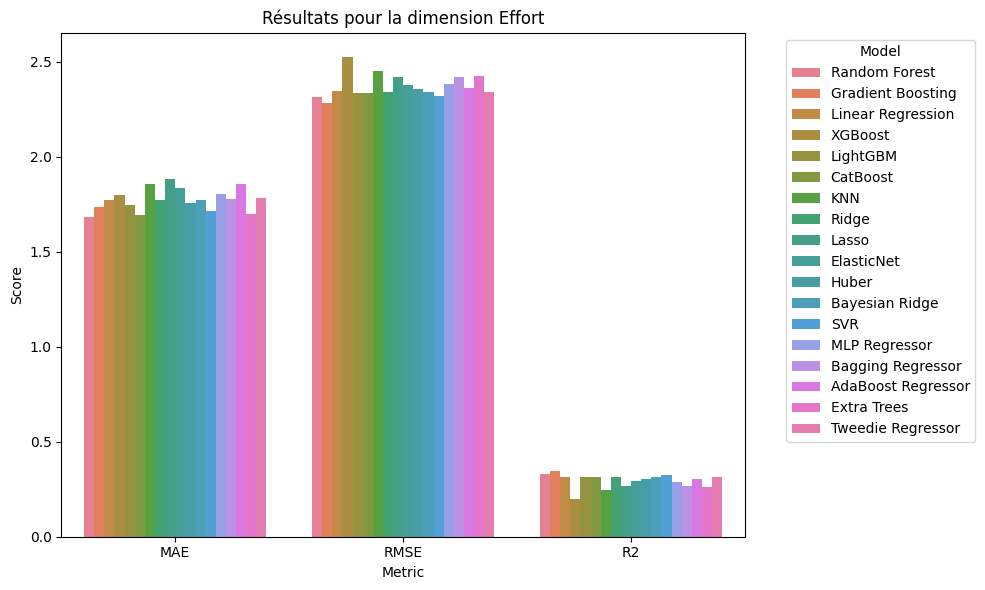

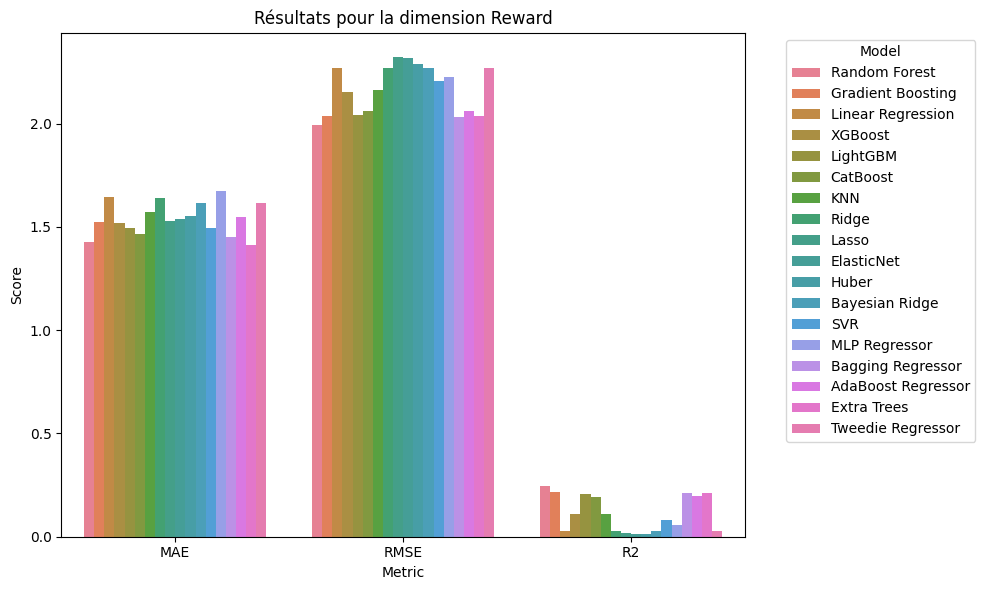

In [ ]:
plot_results(results_risk, "Résultats pour la dimension Risk")
plot_results(results_effort, "Résultats pour la dimension Effort")
plot_results(results_reward, "Résultats pour la dimension Reward")

# On teste avec ChatGPT qui remplie par des données fictives

In [ ]:
df=pd.read_csv('merged_output_final_filled_completed.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

genre  age nationalite niveauEtudes                             sessionId  \
0  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
1  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
2  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
3  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
4  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot        5.0        5.0     5.0   
1     risk-effort  Homme petite taille        5.0        5.0     1.0   
2     risk-effort  Femme grande taille        5.0        5.0     1.0   
3     risk-reward               Enfant        5.0        5.0     1.0   
4     risk-reward        Personne âgée        5.0        5.0     1.0   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée        5.0        5.0     1.0  
1        Personne âgée        5.0        5.0     1.0  
2  Homme grande taille        5.0        5.0     1.0  
3  Homme grande taille        5.0        5.0     1.0  
4               Enfant        5.0        5.0     1.0

Nombre total de lignes : 1926


In [ ]:
le = LabelEncoder()

df['sessionId'] = le.fit_transform(df['sessionId'])

In [ ]:
joueur_0 = df[df['sessionId'] == 0]

display(joueur_0)

joueur_4 = df[df['sessionId'] == 4]

display(joueur_4)

joueur_88 = df[df['sessionId'] == 88]

display(joueur_88)

genre  age nationalite niveauEtudes  sessionId associationType  \
0   femme   23         DZA        bac+4          0     risk-reward   
1   femme   23         DZA        bac+4          0     risk-effort   
2   femme   23         DZA        bac+4          0     risk-effort   
3   femme   23         DZA        bac+4          0     risk-reward   
4   femme   23         DZA        bac+4          0     risk-reward   
5   femme   23         DZA        bac+4          0   effort-reward   
6   femme   23         DZA        bac+4          0     risk-effort   
7   femme   23         DZA        bac+4          0   effort-reward   
8   femme   23         DZA        bac+4          0   effort-reward   
9   femme   23         DZA        bac+4          0   effort-reward   
10  femme   23         DZA        bac+4          0     risk-effort   
11  femme   23         DZA        bac+4          0     risk-effort   
12  femme   23         DZA        bac+4          0   effort-reward   
13  femme   23         DZA        bac+4          0     risk-effort   
14  femme   23         DZA        bac+4          0     risk-reward   
15  femme   23         DZA        bac+4          0   effort-reward   
16  femme   23         DZA        bac+4          0   effort-reward   
17  femme   23         DZA        bac+4          0   effort-reward   

            personAType  valueOneA  valueTwoA  forceA          personBType  \
0                 Robot        5.0        5.0     5.0        Personne âgée   
1   Homme petite taille        5.0        5.0     1.0        Personne âgée   
2   Femme grande taille        5.0        5.0     1.0  Homme grande taille   
3                Enfant        5.0        5.0     1.0  Homme grande taille   
4         Personne âgée        5.0        5.0     1.0               Enfant   
5         Personne âgée        5.0        5.0     1.0  Femme petite taille   
6                 Robot        5.0        5.0     5.0  Femme petite taille   
7   Femme grande taille        5.0        5.0     1.0  Homme petite taille   
8                Enfant        0.0        2.0     1.0  Homme petite taille   
9                 Robot        0.0        3.0     5.0  Femme petite taille   
10  Homme petite taille        6.0       10.0     1.0  Homme grande taille   
11        Personne âgée        4.0        3.0     1.0        Personne âgée   
12        Personne âgée        0.0        7.0     1.0               Enfant   
13               Enfant        4.0        1.0     1.0               Enfant   
14                Robot        9.0        5.0     5.0  Femme petite taille   
15                Robot        9.0        0.0     5.0        Personne âgée   
16  Femme grande taille        7.0        0.0     1.0  Homme petite taille   
17  Femme grande taille        9.0        3.0     1.0  Homme grande taille   

    valueOneB  valueTwoB  forceB  
0         5.0        5.0     1.0  
1         5.0        5.0     1.0  
2         5.0        5.0     1.0  
3         5.0        5.0     1.0  
4         5.0        5.0     1.0  
5         5.0        5.0     8.0  
6         5.0        5.0     8.0  
7         5.0        5.0     1.0  
8        10.0        8.0     1.0  
9        10.0        7.0     8.0  
10        4.0        0.0     1.0  
11        6.0        7.0     1.0  
12       10.0        3.0     1.0  
13        6.0        9.0     1.0  
14        1.0        5.0     8.0  
15        1.0       10.0     1.0  
16        3.0       10.0     1.0  
17        1.0        7.0     1.0

genre  age nationalite niveauEtudes  sessionId associationType  \
90   femme   21         FRA        bac+3          4     risk-effort   
91   femme   21         FRA        bac+3          4   effort-reward   
92   femme   21         FRA        bac+3          4   effort-reward   
93   femme   21         FRA        bac+3          4     risk-reward   
94   femme   21         FRA        bac+3          4     risk-reward   
95   femme   21         FRA        bac+3          4   effort-reward   
96   femme   21         FRA        bac+3          4     risk-effort   
97   femme   21         FRA        bac+3          4     risk-reward   
98   femme   21         FRA        bac+3          4   effort-reward   
99   femme   21         FRA        bac+3          4   effort-reward   
100  femme   21         FRA        bac+3          4     risk-effort   
101  femme   21         FRA        bac+3          4     risk-reward   
102  femme   21         FRA        bac+3          4     risk-effort   
103  femme   21         FRA        bac+3          4   effort-reward   
104  femme   21         FRA        bac+3          4   effort-reward   
105  femme   21         FRA        bac+3          4     risk-reward   
106  femme   21         FRA        bac+3          4   effort-reward   
107  femme   21         FRA        bac+3          4   effort-reward   

    personAType  valueOneA  valueTwoA  forceA          personBType  valueOneB  \
90        Robot        7.0        8.0    10.0               Enfant        3.0   
91        Robot        6.0        4.0    10.0  Femme petite taille        4.0   
92        Robot        9.0        2.0    10.0               Enfant        1.0   
93        Robot        8.0        6.0    10.0               Enfant        2.0   
94        Robot        9.0        4.0    10.0  Femme petite taille        1.0   
95        Robot        1.0        1.0    10.0  Femme petite taille        9.0   
96        Robot        5.0        2.0    10.0               Enfant        5.0   
97        Robot        3.0        5.0    10.0               Enfant        7.0   
98        Robot        2.0        2.0    10.0               Enfant        8.0   
99        Robot        7.0        9.0    10.0               Enfant        3.0   
100       Robot        6.0        8.0    10.0               Enfant        4.0   
101       Robot        9.0        4.0    10.0  Femme petite taille        1.0   
102       Robot        6.0        3.0    10.0               Enfant        4.0   
103       Robot        5.0        4.0    10.0               Enfant        5.0   
104       Robot       10.0       10.0    10.0               Enfant        0.0   
105       Robot        2.0        5.0    10.0  Femme petite taille        8.0   
106       Robot        8.0       10.0    10.0  Femme petite taille        2.0   
107       Robot        9.0        0.0    10.0               Enfant        1.0   

     valueTwoB  forceB  
90         2.0     1.0  
91         6.0     5.0  
92         8.0     1.0  
93         4.0     1.0  
94         6.0     5.0  
95         9.0     5.0  
96         8.0     1.0  
97         5.0     1.0  
98         8.0     1.0  
99         1.0     1.0  
100        2.0     1.0  
101        6.0     5.0  
102        7.0     1.0  
103        6.0     1.0  
104        0.0     1.0  
105        5.0     5.0  
106        0.0     5.0  
107       10.0     1.0

genre  age nationalite niveauEtudes  sessionId associationType  \
1836  femme   27         DZA        bac+5         88   effort-reward   
1837  femme   27         DZA        bac+5         88     risk-effort   
1838  femme   27         DZA        bac+5         88     risk-effort   
1839  femme   27         DZA        bac+5         88     risk-reward   
1840  femme   27         DZA        bac+5         88     risk-reward   
1841  femme   27         DZA        bac+5         88     risk-reward   
1842  femme   27         DZA        bac+5         88     risk-reward   
1843  femme   27         DZA        bac+5         88     risk-reward   
1844  femme   27         DZA        bac+5         88   effort-reward   
1845  femme   27         DZA        bac+5         88     risk-reward   
1846  femme   27         DZA        bac+5         88     risk-reward   
1847  femme   27         DZA        bac+5         88   effort-reward   
1848  femme   27         DZA        bac+5         88   effort-reward   
1849  femme   27         DZA        bac+5         88   effort-reward   
1850  femme   27         DZA        bac+5         88   effort-reward   
1851  femme   27         DZA        bac+5         88   effort-reward   
1852  femme   27         DZA        bac+5         88   effort-reward   
1853  femme   27         DZA        bac+5         88   effort-reward   

              personAType  valueOneA  valueTwoA  forceA          personBType  \
1836               Enfant        5.0        5.0     1.0  Homme grande taille   
1837        Personne âgée       10.0        0.0     1.0  Homme grande taille   
1838  Homme grande taille        5.0        5.0     1.0               Enfant   
1839  Homme grande taille        5.0        5.0     1.0                Robot   
1840        Personne âgée        0.0        3.0     1.0  Homme petite taille   
1841        Personne âgée        9.0        4.0     1.0  Homme grande taille   
1842               Enfant        8.0        6.0     1.0  Homme grande taille   
1843        Personne âgée        3.0        6.0     1.0  Homme grande taille   
1844               Enfant        0.0        1.0     1.0               Enfant   
1845        Personne âgée        3.0        5.0     1.0               Enfant   
1846  Homme grande taille        3.0        6.0     1.0               Enfant   
1847        Personne âgée        2.0        0.0     1.0  Homme grande taille   
1848               Enfant        4.0        4.0     1.0  Homme grande taille   
1849        Personne âgée        3.0        9.0     1.0               Enfant   
1850        Personne âgée        2.0        2.0     1.0               Enfant   
1851  Homme grande taille        3.0        7.0     1.0               Enfant   
1852  Homme grande taille        1.0        7.0     1.0               Enfant   
1853               Enfant        8.0        1.0     1.0  Homme petite taille   

      valueOneB  valueTwoB  forceB  
1836        5.0        5.0     1.0  
1837        0.0       10.0     1.0  
1838        5.0        5.0     1.0  
1839        5.0        5.0     1.0  
1840       10.0        7.0     1.0  
1841        1.0        6.0     1.0  
1842        2.0        4.0     1.0  
1843        7.0        4.0     1.0  
1844       10.0        9.0     1.0  
1845        7.0        5.0     1.0  
1846        7.0        4.0     1.0  
1847        8.0       10.0     1.0  
1848        6.0        6.0     1.0  
1849        7.0        1.0     1.0  
1850        8.0        8.0     1.0  
1851        7.0        3.0     1.0  
1852        9.0        3.0     1.0  
1853        2.0        9.0     1.0

In [ ]:
df_bin = df.copy()


label_encoders = {}
for col in [ 'genre','age','niveauEtudes', 'nationalite','associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# on filtre les datasets
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[['associationType', 'genre', 'age','niveauEtudes','nationalite', 'personAType', 'personBType', 'forceA', 'forceB']]
X_effort = effort_df[['associationType', 'genre','age','niveauEtudes','nationalite', 'personAType', 'personBType', 'forceA', 'forceB']]
X_reward = reward_df[['associationType', 'personAType', 'genre','age','niveauEtudes','nationalite','personBType', 'forceA', 'forceB']]

# def y selon la colonne correspondant à la dimension

# RISK
risk_reward_code = label_encoders['associationType'].transform(['risk-reward'])[0]
risk_effort_code = label_encoders['associationType'].transform(['risk-effort'])[0]

risk_part1 = risk_df[risk_df['associationType'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType'] == risk_reward_code][['valueOneA', 'valueOneB']]
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()


# EFFORT
effort_effort_code = label_encoders['associationType'].transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType'] == effort_effort_code][['valueOneA', 'valueOneB']]
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()


# REWARD
reward_part1 = reward_df[reward_df['associationType'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()

reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import TweedieRegressor


models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42)),
    "KNN": KNeighborsRegressor(),

    # Nouveaux modèles
    "Ridge": MultiOutputRegressor(Ridge()),
    "Lasso": MultiOutputRegressor(Lasso()),
    "ElasticNet": MultiOutputRegressor(ElasticNet()),
    "Huber": MultiOutputRegressor(HuberRegressor()),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge()),
    "SVR": MultiOutputRegressor(SVR()),
    "MLP Regressor": MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=1000)),
    "Bagging Regressor": MultiOutputRegressor(BaggingRegressor(random_state=42)),
    "AdaBoost Regressor": MultiOutputRegressor(AdaBoostRegressor(random_state=42)),
    "Extra Trees": MultiOutputRegressor(ExtraTreesRegressor(random_state=42)),
    "Tweedie Regressor": MultiOutputRegressor(TweedieRegressor(power=0, alpha=0.5))

}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)

def plot_results(results_df, title):
    df_copy = results_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)
    melted = pd.melt(df_copy, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



In [ ]:
# Évaluer
results_risk = evaluate_models(X_risk, y_risk)
results_effort = evaluate_models(X_effort, y_effort)
results_reward = evaluate_models(X_reward, y_reward)

# Afficher
print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Risk :")
display(results_risk)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Effort :")
display(results_effort)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Reward :")
display(results_reward)


[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 9
[LightGBM] [Info] Start training from score 4.921166
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 9
[LightGBM] [Info] Start training from score 5.078834
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 9
[LightGBM] [Info] Start training from score 4.991361
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 9
[LightGBM] [Info] Start training from score 5.008639
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 9
[LightGBM] [Info] Start training from score 4.965443
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 9
[Li

Model            MAE           RMSE              R2
0        Random Forest  2.023 ± 0.080  2.720 ± 0.071   0.024 ± 0.102
1    Gradient Boosting  2.069 ± 0.069  2.674 ± 0.067   0.060 ± 0.059
2    Linear Regression  2.081 ± 0.104  2.655 ± 0.079   0.074 ± 0.043
3              XGBoost  2.189 ± 0.086  2.964 ± 0.047  -0.158 ± 0.100
4             LightGBM  2.096 ± 0.074  2.750 ± 0.089   0.002 ± 0.109
5             CatBoost  2.070 ± 0.072  2.768 ± 0.058  -0.010 ± 0.089
6                  KNN  2.176 ± 0.102  2.842 ± 0.132  -0.067 ± 0.135
7                Ridge  2.081 ± 0.104  2.655 ± 0.079   0.074 ± 0.043
8                Lasso  2.096 ± 0.122  2.698 ± 0.098   0.045 ± 0.003
9           ElasticNet  2.078 ± 0.113  2.658 ± 0.081   0.073 ± 0.019
10               Huber  2.078 ± 0.104  2.667 ± 0.085   0.065 ± 0.058
11      Bayesian Ridge  2.078 ± 0.101  2.649 ± 0.074   0.079 ± 0.042
12                 SVR  2.026 ± 0.117  2.671 ± 0.103   0.062 ± 0.072
13       MLP Regressor  2.108 ± 0.066  2.723 ± 0.058   0.023 ± 0.085
14   Bagging Regressor  2.131 ± 0.074  2.867 ± 0.068  -0.084 ± 0.104
15  AdaBoost Regressor  2.086 ± 0.103  2.671 ± 0.073   0.064 ± 0.023
16         Extra Trees  2.039 ± 0.084  2.843 ± 0.029  -0.065 ± 0.085
17   Tweedie Regressor  2.078 ± 0.100  2.648 ± 0.073   0.079 ± 0.042

-----------------------------------------------------------

 Résultats pour la dimension Effort :


Model            MAE           RMSE              R2
0        Random Forest  2.256 ± 0.044  2.926 ± 0.070   0.073 ± 0.059
1    Gradient Boosting  2.205 ± 0.041  2.798 ± 0.062   0.153 ± 0.043
2    Linear Regression  2.307 ± 0.060  2.855 ± 0.051   0.118 ± 0.025
3              XGBoost  2.411 ± 0.045  3.155 ± 0.074  -0.078 ± 0.080
4             LightGBM  2.291 ± 0.074  2.929 ± 0.080   0.072 ± 0.055
5             CatBoost  2.261 ± 0.047  2.915 ± 0.072   0.080 ± 0.061
6                  KNN  2.336 ± 0.060  2.987 ± 0.093   0.034 ± 0.071
7                Ridge  2.307 ± 0.060  2.855 ± 0.051   0.118 ± 0.025
8                Lasso  2.397 ± 0.061  2.909 ± 0.049   0.085 ± 0.009
9           ElasticNet  2.359 ± 0.054  2.875 ± 0.043   0.106 ± 0.016
10               Huber  2.281 ± 0.060  2.878 ± 0.056   0.104 ± 0.035
11      Bayesian Ridge  2.310 ± 0.059  2.852 ± 0.047   0.120 ± 0.024
12                 SVR  2.204 ± 0.049  2.837 ± 0.055   0.129 ± 0.048
13       MLP Regressor  2.255 ± 0.073  2.869 ± 0.117   0.108 ± 0.086
14   Bagging Regressor  2.338 ± 0.039  3.019 ± 0.063   0.013 ± 0.049
15  AdaBoost Regressor  2.313 ± 0.053  2.834 ± 0.048   0.132 ± 0.017
16         Extra Trees  2.327 ± 0.045  3.091 ± 0.064  -0.035 ± 0.060
17   Tweedie Regressor  2.313 ± 0.059  2.852 ± 0.046   0.120 ± 0.024

-----------------------------------------------------------

 Résultats pour la dimension Reward :


Model            MAE           RMSE              R2
0        Random Forest  1.856 ± 0.073  2.509 ± 0.113   0.012 ± 0.055
1    Gradient Boosting  1.842 ± 0.108  2.427 ± 0.127   0.078 ± 0.021
2    Linear Regression  1.862 ± 0.132  2.517 ± 0.145   0.008 ± 0.017
3              XGBoost  1.989 ± 0.077  2.705 ± 0.141  -0.149 ± 0.082
4             LightGBM  1.894 ± 0.089  2.502 ± 0.128   0.019 ± 0.034
5             CatBoost  1.904 ± 0.076  2.547 ± 0.118  -0.018 ± 0.045
6                  KNN  2.000 ± 0.092  2.610 ± 0.120  -0.068 ± 0.043
7                Ridge  1.862 ± 0.132  2.517 ± 0.145   0.008 ± 0.017
8                Lasso  1.808 ± 0.149  2.530 ± 0.151  -0.001 ± 0.002
9           ElasticNet  1.805 ± 0.152  2.528 ± 0.154   0.001 ± 0.004
10               Huber  1.845 ± 0.131  2.520 ± 0.145   0.006 ± 0.014
11      Bayesian Ridge  1.836 ± 0.135  2.513 ± 0.148   0.012 ± 0.012
12                 SVR  1.813 ± 0.140  2.479 ± 0.151   0.038 ± 0.019
13       MLP Regressor  1.949 ± 0.112  2.538 ± 0.140  -0.009 ± 0.024
14   Bagging Regressor  1.912 ± 0.112  2.584 ± 0.146  -0.046 ± 0.051
15  AdaBoost Regressor  1.837 ± 0.141  2.444 ± 0.153   0.066 ± 0.016
16         Extra Trees  1.890 ± 0.100  2.634 ± 0.141  -0.090 ± 0.088
17   Tweedie Regressor  1.849 ± 0.132  2.513 ± 0.146   0.012 ± 0.014

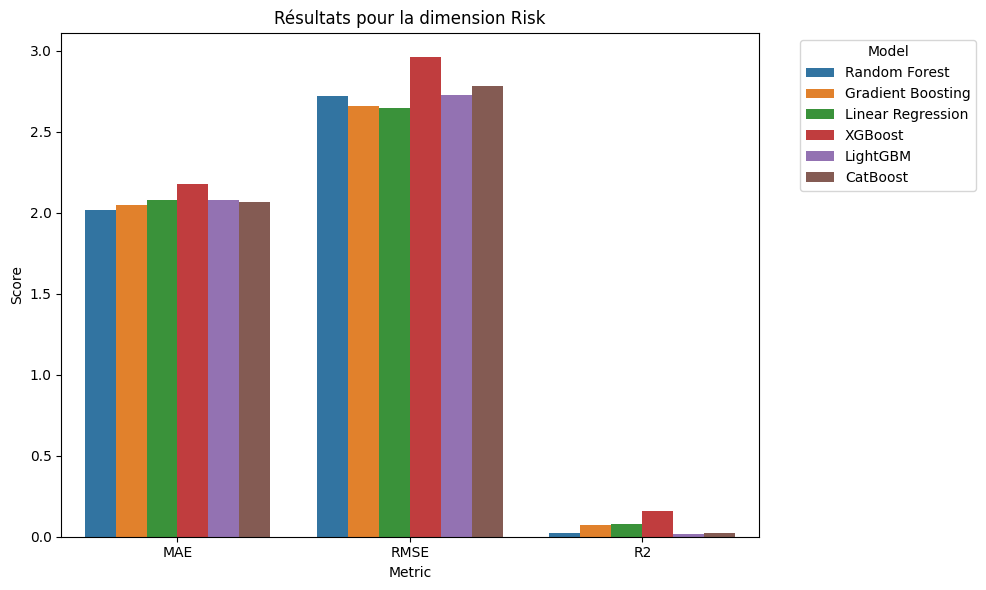

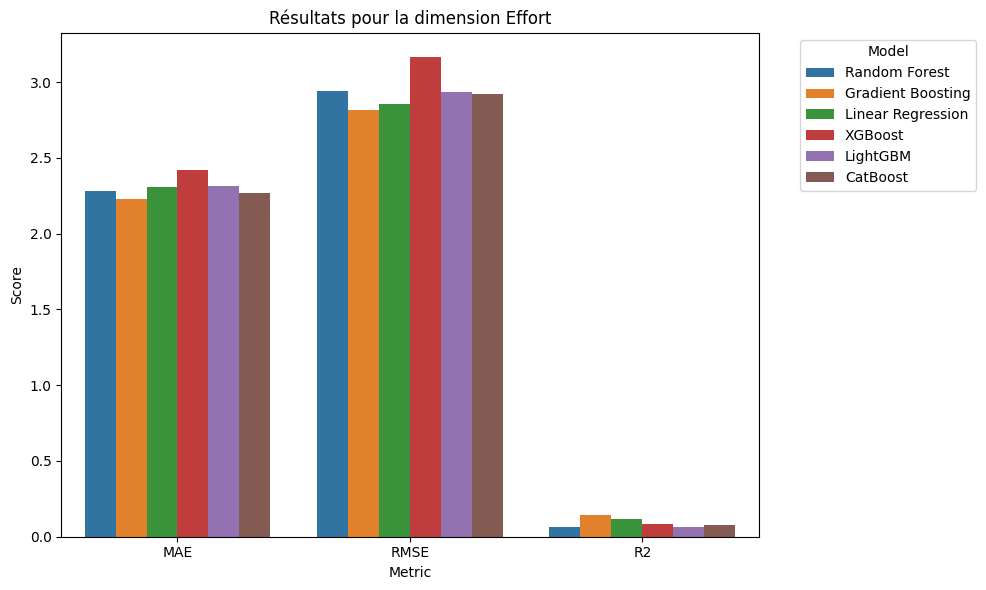

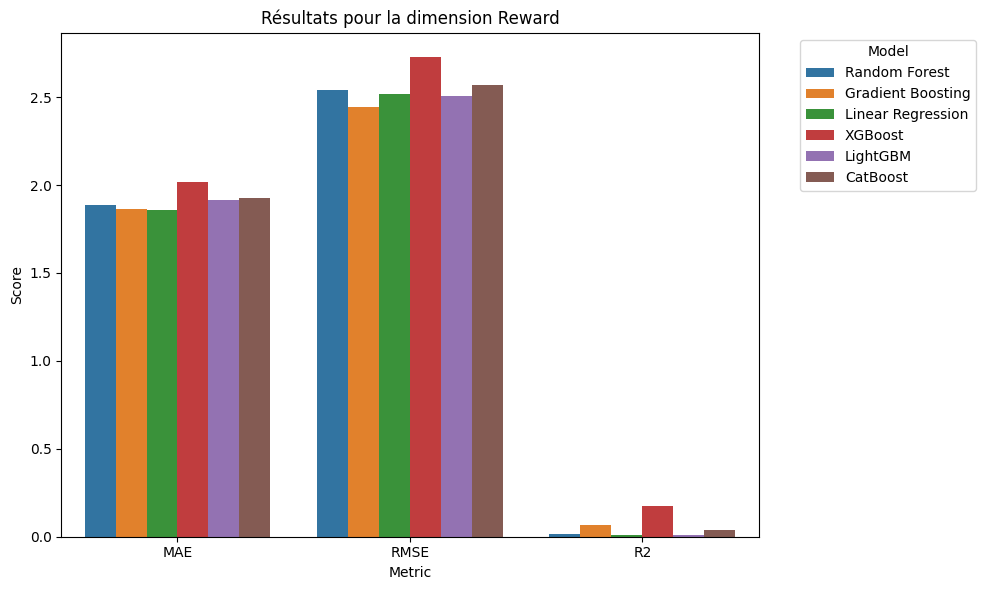

In [ ]:
plot_results(results_risk, "Résultats pour la dimension Risk")
plot_results(results_effort, "Résultats pour la dimension Effort")
plot_results(results_reward, "Résultats pour la dimension Reward")

## TEST TACHE BINAIRE

### NaN COMPLETES KNN Imputer

In [ ]:
df=pd.read_csv('merged_output_final_54.csv')
display (df.head())
print("Nombre total de lignes :", len(df))

genre  age nationalite niveauEtudes                             sessionId  \
0  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
1  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
2  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
3  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
4  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot        5.0        5.0     5.0   
1     risk-effort  Homme petite taille        5.0        5.0     1.0   
2     risk-effort  Femme grande taille        5.0        5.0     1.0   
3     risk-reward               Enfant        5.0        5.0     1.0   
4     risk-reward        Personne âgée        5.0        5.0     1.0   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée        5.0        5.0     1.0  
1        Personne âgée        5.0        5.0     1.0  
2  Homme grande taille        5.0        5.0     1.0  
3  Homme grande taille        5.0        5.0     1.0  
4               Enfant        5.0        5.0     1.0

Nombre total de lignes : 1926


In [ ]:
# Colonnes finales
feature_cols = ['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite',
                'personAType', 'personBType', 'forceA', 'forceB']

df_bin = df.copy()

label_encoders = {}
for col in [ 'genre','age','niveauEtudes','nationalite', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# Appliquer KNN Imputer sur les colonnes numériques
columns_to_impute = ['associationType', 'personAType','personBType','forceA', 'forceB', 'valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']
imputer = KNNImputer(n_neighbors=5)
df_bin[columns_to_impute] = imputer.fit_transform(df_bin[columns_to_impute])

# Aperçu des valeurs manquantes AVANT imputation
print("Valeurs manquantes avant imputation :")
print(df[columns_to_impute].isna().sum())

# Comparaison des valeurs avant/après imputation pour quelques lignes
print("\nExemples de lignes AVANT et APRÈS imputation :")
cols_check = ['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']
print("\nAvant imputation :")
display(df[df[cols_check].isna().any(axis=1)][cols_check].head())

print("\nAprès imputation :")
display(df_bin.loc[df[cols_check].isna().any(axis=1), cols_check].head())

print("Valeurs manquantes avant imputation :")
print(df_bin[columns_to_impute].isna().sum())

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# on filtre les datasets
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[feature_cols]
X_effort = effort_df[feature_cols]
X_reward = reward_df[feature_cols]


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['associationType', 'genre', 'niveauEtudes', 'nationalite', 'personAType', 'personBType']

onehot = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
    remainder='passthrough'
)




In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# On teste avec RandomForest d'abord

# cibles binaires
df_bin['who_more_oneA'] = (df_bin['valueOneA'] > df_bin['valueOneB']).astype(int)
df_bin['who_more_twoA'] = (df_bin['valueTwoA'] > df_bin['valueTwoB']).astype(int)
df_bin['who_equal_one'] = (df_bin['valueOneB'] == df_bin['valueOneA']).astype(int)
df_bin['who_more_oneB'] = (df_bin['valueOneB'] > df_bin['valueOneA']).astype(int)
df_bin['who_more_twoB'] = (df_bin['valueTwoB'] > df_bin['valueTwoA']).astype(int)
df_bin['who_equal_two'] = (df_bin['valueTwoA'] == df_bin['valueTwoB']).astype(int)

print(df_bin['who_more_oneA'].value_counts(normalize=True))
print(df_bin['who_more_twoA'].value_counts(normalize=True))
print(df_bin['who_more_oneB'].value_counts(normalize=True))
print(df_bin['who_more_twoB'].value_counts(normalize=True))
print(df_bin['who_equal_one'].value_counts(normalize=True))
print(df_bin['who_equal_two'].value_counts(normalize=True))


X_cls = df_bin[feature_cols]


def evaluate_classification_all(X, y):
    clf = Pipeline([
        ('onehot', onehot),
        ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
    ])
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }
    results = {}
    for metric, scorer in scoring.items():
        scores = cross_val_score(clf, X, y, cv=kf, scoring=scorer)
        results[metric] = f"{scores.mean():.3f} ± {scores.std():.3f}"
    return results
'''
# tester sur toutes les cibles
for col in ['who_more_oneA', 'who_more_twoA', 'who_more_oneB', 'who_more_twoB', 'who_equal_oneB', 'who_equal_twoA']:
    print(f"\n📊 Classification binaire {col}")
    res = evaluate_classification_all(X_cls, df_bin[col])
    for metric, score in res.items():
        display(f"{metric.capitalize()} : {score}")
'''


who_more_oneA
0    0.74974
1    0.25026
Name: proportion, dtype: float64
who_more_twoA
0    0.810488
1    0.189512
Name: proportion, dtype: float64
who_more_oneB
0    0.745587
1    0.254413
Name: proportion, dtype: float64
who_more_twoB
0    0.76999
1    0.23001
Name: proportion, dtype: float64
who_equal_one
0    0.778816
1    0.221184
Name: proportion, dtype: float64
who_equal_two
0    0.693666
1    0.306334
Name: proportion, dtype: float64


'\n# tester sur toutes les cibles\nfor col in [\'who_more_oneA\', \'who_more_twoA\', \'who_more_oneB\', \'who_more_twoB\', \'who_equal_oneB\', \'who_equal_twoA\']:\n    print(f"\n📊 Classification binaire {col}")\n    res = evaluate_classification_all(X_cls, df_bin[col])\n    for metric, score in res.items():\n        display(f"{metric.capitalize()} : {score}")\n'

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline


def prepare_and_evaluate(df_sub, dimension_name):
    df_sub = df_sub.copy()
    df_sub['who_more_oneA'] = (df_sub['valueOneA'] > df_sub['valueOneB']).astype(int)
    df_sub['who_more_twoA'] = (df_sub['valueTwoA'] > df_sub['valueTwoB']).astype(int)
    df_sub['who_more_oneB'] = (df_sub['valueOneB'] > df_sub['valueOneA']).astype(int)
    df_sub['who_more_twoB'] = (df_sub['valueTwoB'] > df_sub['valueTwoA']).astype(int)
    df_sub['who_equal_one'] = (df_sub['valueOneB'] == df_sub['valueOneA']).astype(int)
    df_sub['who_equal_two'] = (df_sub['valueTwoA'] == df_sub['valueTwoB']).astype(int)


    X_sub = df_sub[feature_cols]

    print(f"\n Résultats pour la dimension {dimension_name}")
    for col in ['who_more_oneA', 'who_more_twoA', 'who_more_oneB', 'who_more_twoB', 'who_equal_one', 'who_equal_two']:
        print(f"\n📊 Classification binaire {col}")
        res = evaluate_classification_all(X_sub, df_sub[col])
        for metric, score in res.items():
            display(f"{metric.capitalize()} : {score}")

models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced',random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced',max_iter=500),
    'SVM': SVC(),
    'SVM Poly': SVC(kernel='poly'),
    'SVM RBF': SVC(kernel='rbf'),
    'SVM Sigmoid': SVC(kernel='sigmoid'),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

def evaluate_classification_models(X, y):
    results = []
    for name, model in models.items():
        clf = Pipeline([
            ('onehot', onehot),
            ('classifier', model)
        ])
        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1': make_scorer(f1_score)
        }
        row = {'Model': name}
        for metric, scorer in scoring.items():
            scores = cross_val_score(clf, X, y, cv=kf, scoring=scorer)
            row[metric] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)


In [ ]:
def prepare_and_evaluate_all_models(df_sub, dimension_name):
    df_sub = df_sub.copy()

    # Création des cibles binaires
    df_sub['who_more_oneA'] = (df_sub['valueOneA'] > df_sub['valueOneB']).astype(int)
    df_sub['who_more_twoA'] = (df_sub['valueTwoA'] > df_sub['valueTwoB']).astype(int)
    df_sub['who_more_oneB'] = (df_sub['valueOneB'] > df_sub['valueOneA']).astype(int)
    df_sub['who_more_twoB'] = (df_sub['valueTwoB'] > df_sub['valueTwoA']).astype(int)
    df_sub['who_equal_one'] = (df_sub['valueOneB'] == df_sub['valueOneA']).astype(int)
    df_sub['who_equal_two'] = (df_sub['valueTwoA'] == df_sub['valueTwoB']).astype(int)

    X_sub = df_sub[feature_cols]

    print(f"\n📊📊 Résultats pour la dimension : {dimension_name}")

    # Pour chaque cible binaire
    for target in ['who_more_oneA', 'who_more_twoA', 'who_more_oneB', 'who_more_twoB', 'who_equal_one', 'who_equal_two']:
        print(f"\n🔹 Classification binaire : {target}")
        y_sub = df_sub[target]

        results = []
        for name, model in models.items():
            clf = Pipeline([
                ('onehot', onehot),
                ('classifier', model)
            ])
            scoring = {
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score),
                'recall': make_scorer(recall_score),
                'f1': make_scorer(f1_score)
            }
            row = {'Model': name}
            for metric, scorer in scoring.items():
                scores = cross_val_score(clf, X_sub, y_sub, cv=kf, scoring=scorer)
                row[metric] = f"{scores.mean():.3f} ± {scores.std():.3f}"
            results.append(row)

        results_df = pd.DataFrame(results)
        display(results_df)


In [ ]:
prepare_and_evaluate_all_models(risk_df, "Risk")
prepare_and_evaluate_all_models(effort_df, "Effort")
prepare_and_evaluate_all_models(reward_df, "Reward")



📊📊 Résultats pour la dimension : Risk

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0        Random Forest  0.745 ± 0.028  0.651 ± 0.053  0.497 ± 0.054   
1  Logistic Regression  0.691 ± 0.023  0.523 ± 0.060  0.657 ± 0.100   
2                  SVM  0.736 ± 0.025  0.700 ± 0.045  0.368 ± 0.048   
3                  KNN  0.692 ± 0.012  0.544 ± 0.069  0.474 ± 0.032   
4    Gradient Boosting  0.726 ± 0.010  0.606 ± 0.055  0.493 ± 0.035   
5             AdaBoost  0.715 ± 0.031  0.609 ± 0.099  0.399 ± 0.054   
6          Naive Bayes  0.675 ± 0.025  0.532 ± 0.057  0.150 ± 0.046   

              f1  
0  0.563 ± 0.054  
1  0.581 ± 0.073  
2  0.480 ± 0.043  
3  0.505 ± 0.041  
4  0.543 ± 0.039  
5  0.481 ± 0.065  
6  0.231 ± 0.060


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0        Random Forest  0.787 ± 0.044  0.646 ± 0.085  0.370 ± 0.075   
1  Logistic Regression  0.683 ± 0.026  0.418 ± 0.072  0.703 ± 0.115   
2                  SVM  0.746 ± 0.038  0.000 ± 0.000  0.000 ± 0.000   
3                  KNN  0.769 ± 0.031  0.560 ± 0.075  0.390 ± 0.046   
4    Gradient Boosting  0.786 ± 0.035  0.605 ± 0.094  0.390 ± 0.112   
5             AdaBoost  0.744 ± 0.031  0.491 ± 0.080  0.221 ± 0.080   
6          Naive Bayes  0.540 ± 0.053  0.342 ± 0.063  0.879 ± 0.044   

              f1  
0  0.467 ± 0.070  
1  0.522 ± 0.083  
2  0.000 ± 0.000  
3  0.459 ± 0.053  
4  0.471 ± 0.113  
5  0.296 ± 0.067  
6  0.490 ± 0.069


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0        Random Forest  0.753 ± 0.020  0.693 ± 0.056  0.562 ± 0.043   
1  Logistic Regression  0.688 ± 0.031  0.549 ± 0.038  0.679 ± 0.063   
2                  SVM  0.690 ± 0.024  0.630 ± 0.077  0.325 ± 0.087   
3                  KNN  0.722 ± 0.041  0.647 ± 0.068  0.508 ± 0.064   
4    Gradient Boosting  0.714 ± 0.028  0.624 ± 0.049  0.507 ± 0.081   
5             AdaBoost  0.688 ± 0.027  0.620 ± 0.092  0.342 ± 0.075   
6          Naive Bayes  0.497 ± 0.036  0.404 ± 0.023  0.885 ± 0.050   

              f1  
0  0.617 ± 0.013  
1  0.606 ± 0.039  
2  0.420 ± 0.068  
3  0.564 ± 0.047  
4  0.554 ± 0.045  
5  0.433 ± 0.056  
6  0.555 ± 0.027


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0        Random Forest  0.752 ± 0.026  0.675 ± 0.040  0.521 ± 0.098   
1  Logistic Regression  0.669 ± 0.014  0.508 ± 0.026  0.640 ± 0.041   
2                  SVM  0.706 ± 0.020  0.653 ± 0.056  0.274 ± 0.080   
3                  KNN  0.693 ± 0.020  0.553 ± 0.039  0.444 ± 0.109   
4    Gradient Boosting  0.744 ± 0.023  0.662 ± 0.045  0.511 ± 0.072   
5             AdaBoost  0.716 ± 0.013  0.613 ± 0.048  0.435 ± 0.060   
6          Naive Bayes  0.699 ± 0.030  0.645 ± 0.154  0.321 ± 0.146   

              f1  
0  0.582 ± 0.054  
1  0.565 ± 0.019  
2  0.379 ± 0.074  
3  0.487 ± 0.070  
4  0.572 ± 0.033  
5  0.506 ± 0.038  
6  0.402 ± 0.100


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0        Random Forest  0.763 ± 0.027  0.686 ± 0.079  0.460 ± 0.053   
1  Logistic Regression  0.644 ± 0.047  0.451 ± 0.040  0.605 ± 0.058   
2                  SVM  0.730 ± 0.049  0.687 ± 0.126  0.245 ± 0.077   
3                  KNN  0.726 ± 0.029  0.581 ± 0.023  0.451 ± 0.095   
4    Gradient Boosting  0.732 ± 0.037  0.626 ± 0.055  0.362 ± 0.075   
5             AdaBoost  0.737 ± 0.054  0.765 ± 0.194  0.247 ± 0.065   
6          Naive Bayes  0.405 ± 0.044  0.337 ± 0.029  0.927 ± 0.028   

              f1  
0  0.546 ± 0.041  
1  0.515 ± 0.041  
2  0.359 ± 0.101  
3  0.501 ± 0.066  
4  0.454 ± 0.073  
5  0.369 ± 0.085  
6  0.493 ± 0.030


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0        Random Forest  0.719 ± 0.029  0.692 ± 0.043  0.578 ± 0.070   
1  Logistic Regression  0.658 ± 0.023  0.573 ± 0.019  0.660 ± 0.051   
2                  SVM  0.628 ± 0.051  0.669 ± 0.100  0.186 ± 0.049   
3                  KNN  0.659 ± 0.019  0.595 ± 0.033  0.547 ± 0.059   
4    Gradient Boosting  0.688 ± 0.022  0.648 ± 0.045  0.533 ± 0.055   
5             AdaBoost  0.645 ± 0.029  0.616 ± 0.058  0.387 ± 0.079   
6          Naive Bayes  0.462 ± 0.037  0.431 ± 0.035  0.971 ± 0.018   

              f1  
0  0.626 ± 0.039  
1  0.612 ± 0.017  
2  0.289 ± 0.068  
3  0.566 ± 0.021  
4  0.581 ± 0.028  
5  0.468 ± 0.044  
6  0.596 ± 0.034


📊📊 Résultats pour la dimension : Effort

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0        Random Forest  0.763 ± 0.022  0.720 ± 0.032  0.528 ± 0.061   
1  Logistic Regression  0.718 ± 0.016  0.586 ± 0.023  0.674 ± 0.035   
2                  SVM  0.754 ± 0.022  0.713 ± 0.047  0.504 ± 0.071   
3                  KNN  0.728 ± 0.026  0.630 ± 0.046  0.546 ± 0.088   
4    Gradient Boosting  0.756 ± 0.031  0.697 ± 0.060  0.537 ± 0.052   
5             AdaBoost  0.739 ± 0.020  0.675 ± 0.049  0.495 ± 0.055   
6          Naive Bayes  0.640 ± 0.065  0.532 ± 0.088  0.589 ± 0.219   

              f1  
0  0.608 ± 0.048  
1  0.626 ± 0.013  
2  0.587 ± 0.046  
3  0.581 ± 0.060  
4  0.606 ± 0.051  
5  0.569 ± 0.038  
6  0.517 ± 0.081


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0        Random Forest  0.780 ± 0.008  0.657 ± 0.024  0.475 ± 0.075   
1  Logistic Regression  0.684 ± 0.045  0.466 ± 0.056  0.647 ± 0.070   
2                  SVM  0.742 ± 0.016  0.619 ± 0.052  0.271 ± 0.023   
3                  KNN  0.752 ± 0.028  0.579 ± 0.065  0.503 ± 0.061   
4    Gradient Boosting  0.752 ± 0.024  0.592 ± 0.069  0.404 ± 0.092   
5             AdaBoost  0.755 ± 0.022  0.607 ± 0.065  0.391 ± 0.089   
6          Naive Bayes  0.432 ± 0.039  0.327 ± 0.021  0.919 ± 0.031   

              f1  
0  0.550 ± 0.058  
1  0.540 ± 0.055  
2  0.375 ± 0.019  
3  0.537 ± 0.058  
4  0.479 ± 0.086  
5  0.473 ± 0.078  
6  0.482 ± 0.018


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0        Random Forest  0.729 ± 0.029  0.672 ± 0.056  0.506 ± 0.043   
1  Logistic Regression  0.689 ± 0.041  0.566 ± 0.045  0.655 ± 0.030   
2                  SVM  0.715 ± 0.026  0.676 ± 0.057  0.416 ± 0.045   
3                  KNN  0.675 ± 0.028  0.562 ± 0.047  0.521 ± 0.056   
4    Gradient Boosting  0.695 ± 0.034  0.598 ± 0.047  0.495 ± 0.043   
5             AdaBoost  0.701 ± 0.021  0.620 ± 0.038  0.454 ± 0.081   
6          Naive Bayes  0.418 ± 0.051  0.379 ± 0.027  0.924 ± 0.057   

              f1  
0  0.576 ± 0.037  
1  0.607 ± 0.033  
2  0.514 ± 0.048  
3  0.538 ± 0.037  
4  0.542 ± 0.043  
5  0.521 ± 0.064  
6  0.537 ± 0.023


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0        Random Forest  0.738 ± 0.049  0.662 ± 0.088  0.458 ± 0.051   
1  Logistic Regression  0.686 ± 0.054  0.526 ± 0.052  0.655 ± 0.069   
2                  SVM  0.699 ± 0.033  0.643 ± 0.114  0.261 ± 0.010   
3                  KNN  0.695 ± 0.030  0.561 ± 0.058  0.417 ± 0.046   
4    Gradient Boosting  0.718 ± 0.050  0.614 ± 0.075  0.458 ± 0.062   
5             AdaBoost  0.710 ± 0.042  0.616 ± 0.091  0.380 ± 0.028   
6          Naive Bayes  0.645 ± 0.078  0.495 ± 0.070  0.625 ± 0.137   

              f1  
0  0.541 ± 0.061  
1  0.583 ± 0.059  
2  0.368 ± 0.010  
3  0.477 ± 0.045  
4  0.522 ± 0.058  
5  0.469 ± 0.044  
6  0.541 ± 0.043


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0        Random Forest  0.747 ± 0.047  0.591 ± 0.106  0.411 ± 0.047   
1  Logistic Regression  0.644 ± 0.019  0.414 ± 0.034  0.582 ± 0.019   
2                  SVM  0.741 ± 0.022  0.664 ± 0.092  0.202 ± 0.031   
3                  KNN  0.729 ± 0.022  0.544 ± 0.078  0.361 ± 0.026   
4    Gradient Boosting  0.732 ± 0.026  0.581 ± 0.079  0.272 ± 0.040   
5             AdaBoost  0.755 ± 0.014  0.794 ± 0.065  0.194 ± 0.028   
6          Naive Bayes  0.352 ± 0.033  0.298 ± 0.015  0.930 ± 0.043   

              f1  
0  0.484 ± 0.069  
1  0.483 ± 0.025  
2  0.308 ± 0.038  
3  0.433 ± 0.040  
4  0.366 ± 0.039  
5  0.311 ± 0.035  
6  0.451 ± 0.016


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0        Random Forest  0.701 ± 0.027  0.632 ± 0.050  0.509 ± 0.053   
1  Logistic Regression  0.627 ± 0.033  0.508 ± 0.034  0.602 ± 0.059   
2                  SVM  0.652 ± 0.020  0.659 ± 0.069  0.170 ± 0.023   
3                  KNN  0.677 ± 0.012  0.593 ± 0.027  0.478 ± 0.057   
4    Gradient Boosting  0.676 ± 0.030  0.617 ± 0.049  0.381 ± 0.076   
5             AdaBoost  0.656 ± 0.026  0.599 ± 0.078  0.294 ± 0.063   
6          Naive Bayes  0.434 ± 0.027  0.398 ± 0.021  0.960 ± 0.033   

              f1  
0  0.562 ± 0.041  
1  0.549 ± 0.031  
2  0.269 ± 0.031  
3  0.526 ± 0.027  
4  0.466 ± 0.067  
5  0.389 ± 0.062  
6  0.562 ± 0.021


📊📊 Résultats pour la dimension : Reward

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0        Random Forest  0.807 ± 0.037  0.752 ± 0.041  0.675 ± 0.058   
1  Logistic Regression  0.788 ± 0.044  0.675 ± 0.032  0.766 ± 0.069   
2                  SVM  0.790 ± 0.038  0.734 ± 0.025  0.633 ± 0.061   
3                  KNN  0.779 ± 0.049  0.686 ± 0.047  0.694 ± 0.058   
4    Gradient Boosting  0.810 ± 0.041  0.748 ± 0.046  0.700 ± 0.085   
5             AdaBoost  0.792 ± 0.041  0.735 ± 0.046  0.645 ± 0.060   
6          Naive Bayes  0.752 ± 0.021  0.633 ± 0.031  0.704 ± 0.038   

              f1  
0  0.711 ± 0.045  
1  0.717 ± 0.048  
2  0.679 ± 0.045  
3  0.690 ± 0.050  
4  0.720 ± 0.057  
5  0.686 ± 0.047  
6  0.666 ± 0.024


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0        Random Forest  0.773 ± 0.044  0.562 ± 0.090  0.398 ± 0.095   
1  Logistic Regression  0.702 ± 0.032  0.428 ± 0.091  0.695 ± 0.055   
2                  SVM  0.757 ± 0.048  0.000 ± 0.000  0.000 ± 0.000   
3                  KNN  0.750 ± 0.026  0.489 ± 0.078  0.316 ± 0.114   
4    Gradient Boosting  0.790 ± 0.030  0.635 ± 0.126  0.352 ± 0.066   
5             AdaBoost  0.743 ± 0.041  0.422 ± 0.081  0.125 ± 0.055   
6          Naive Bayes  0.301 ± 0.078  0.254 ± 0.053  0.958 ± 0.038   

              f1  
0  0.454 ± 0.058  
1  0.526 ± 0.085  
2  0.000 ± 0.000  
3  0.367 ± 0.063  
4  0.443 ± 0.049  
5  0.182 ± 0.056  
6  0.399 ± 0.068


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0        Random Forest  0.820 ± 0.011  0.762 ± 0.067  0.673 ± 0.035   
1  Logistic Regression  0.755 ± 0.017  0.608 ± 0.035  0.728 ± 0.049   
2                  SVM  0.789 ± 0.019  0.726 ± 0.021  0.581 ± 0.059   
3                  KNN  0.760 ± 0.010  0.638 ± 0.037  0.635 ± 0.047   
4    Gradient Boosting  0.789 ± 0.018  0.705 ± 0.062  0.628 ± 0.018   
5             AdaBoost  0.755 ± 0.014  0.673 ± 0.059  0.504 ± 0.050   
6          Naive Bayes  0.447 ± 0.067  0.369 ± 0.029  0.909 ± 0.074   

              f1  
0  0.712 ± 0.025  
1  0.662 ± 0.039  
2  0.645 ± 0.043  
3  0.636 ± 0.039  
4  0.663 ± 0.035  
5  0.576 ± 0.049  
6  0.523 ± 0.030


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0        Random Forest  0.761 ± 0.024  0.620 ± 0.086  0.391 ± 0.055   
1  Logistic Regression  0.668 ± 0.038  0.436 ± 0.073  0.640 ± 0.046   
2                  SVM  0.721 ± 0.039  0.000 ± 0.000  0.000 ± 0.000   
3                  KNN  0.712 ± 0.026  0.481 ± 0.096  0.350 ± 0.077   
4    Gradient Boosting  0.737 ± 0.017  0.548 ± 0.114  0.348 ± 0.051   
5             AdaBoost  0.733 ± 0.030  0.652 ± 0.208  0.177 ± 0.047   
6          Naive Bayes  0.499 ± 0.070  0.332 ± 0.033  0.791 ± 0.156   

              f1  
0  0.474 ± 0.039  
1  0.517 ± 0.062  
2  0.000 ± 0.000  
3  0.398 ± 0.067  
4  0.422 ± 0.060  
5  0.266 ± 0.052  
6  0.463 ± 0.050


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0        Random Forest  0.737 ± 0.023  0.619 ± 0.033  0.437 ± 0.059   
1  Logistic Regression  0.648 ± 0.027  0.458 ± 0.026  0.613 ± 0.061   
2                  SVM  0.717 ± 0.023  0.676 ± 0.122  0.206 ± 0.035   
3                  KNN  0.725 ± 0.026  0.597 ± 0.068  0.406 ± 0.038   
4    Gradient Boosting  0.743 ± 0.015  0.692 ± 0.030  0.342 ± 0.060   
5             AdaBoost  0.722 ± 0.019  0.720 ± 0.089  0.203 ± 0.045   
6          Naive Bayes  0.411 ± 0.039  0.345 ± 0.020  0.956 ± 0.020   

              f1  
0  0.511 ± 0.050  
1  0.523 ± 0.030  
2  0.315 ± 0.053  
3  0.482 ± 0.045  
4  0.454 ± 0.050  
5  0.314 ± 0.060  
6  0.507 ± 0.022


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0        Random Forest  0.671 ± 0.021  0.667 ± 0.052  0.630 ± 0.012   
1  Logistic Regression  0.603 ± 0.039  0.581 ± 0.036  0.603 ± 0.041   
2                  SVM  0.567 ± 0.031  0.606 ± 0.048  0.290 ± 0.071   
3                  KNN  0.587 ± 0.032  0.573 ± 0.036  0.553 ± 0.029   
4    Gradient Boosting  0.632 ± 0.030  0.619 ± 0.045  0.598 ± 0.041   
5             AdaBoost  0.575 ± 0.018  0.597 ± 0.069  0.388 ± 0.090   
6          Naive Bayes  0.559 ± 0.020  0.520 ± 0.033  0.859 ± 0.095   

              f1  
0  0.646 ± 0.022  
1  0.592 ± 0.036  
2  0.385 ± 0.057  
3  0.561 ± 0.015  
4  0.607 ± 0.036  
5  0.459 ± 0.062  
6  0.647 ± 0.052

In [ ]:

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

def prepare_data(df, n_neighbors=5):
    # --- Colonnes utiles ---
    feature_cols = ['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite',
                    'personAType', 'personBType', 'forceA', 'forceB']

    cols_to_encode = ['genre','age','niveauEtudes','nationalite',
                      'associationType', 'personAType', 'personBType']

    cols_to_impute = ['associationType', 'personAType','personBType',
                      'forceA', 'forceB', 'valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']

    cols_check = ['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']

    # --- Copie et encodage ---
    df_bin = df.copy()
    label_encoders = {}
    for col in cols_to_encode:
        le = LabelEncoder()
        df_bin[col] = le.fit_transform(df_bin[col])
        label_encoders[col] = le

    # --- Imputation ---
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_bin[cols_to_impute] = imputer.fit_transform(df_bin[cols_to_impute])

    # --- Séparation par type de scénario ---
    risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
    effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
    reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

    risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
    effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
    reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

    X_risk = risk_df[feature_cols]
    X_effort = effort_df[feature_cols]
    X_reward = reward_df[feature_cols]

    # --- Transformateur OneHot ---
    categorical_cols = ['associationType', 'genre', 'niveauEtudes', 'nationalite', 'personAType', 'personBType']
    onehot = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
        remainder='passthrough'
    )

    return {
        'df_encoded': df_bin,
        'label_encoders': label_encoders,
        'X_risk': X_risk,
        'X_effort': X_effort,
        'X_reward': X_reward,
        'risk_df': risk_df,
        'effort_df': effort_df,
        'reward_df': reward_df,
        'onehot': onehot,
        'feature_cols': feature_cols
    }


In [ ]:
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced',random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced',max_iter=500),
    'SVM': SVC(),
    'SVM Linear': SVC(kernel='linear'),
    'SVM Poly': SVC(kernel='poly'),
    'SVM RBF': SVC(kernel='rbf'),
    'SVM Sigmoid': SVC(kernel='sigmoid'),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

def prepare_and_evaluate_all_models(df_sub, dimension_name, feature_cols, onehot):
    df_sub = df_sub.copy()

    # Création des cibles binaires
    df_sub['who_more_oneA'] = (df_sub['valueOneA'] > df_sub['valueOneB']).astype(int)
    df_sub['who_more_twoA'] = (df_sub['valueTwoA'] > df_sub['valueTwoB']).astype(int)
    df_sub['who_more_oneB'] = (df_sub['valueOneB'] > df_sub['valueOneA']).astype(int)
    df_sub['who_more_twoB'] = (df_sub['valueTwoB'] > df_sub['valueTwoA']).astype(int)
    df_sub['who_equal_one'] = (df_sub['valueOneB'] == df_sub['valueOneA']).astype(int)
    df_sub['who_equal_two'] = (df_sub['valueTwoA'] == df_sub['valueTwoB']).astype(int)

    X_sub = df_sub[feature_cols]

    print(f"\n📊📊 Résultats pour la dimension : {dimension_name}")

    for target in ['who_more_oneA', 'who_more_twoA', 'who_more_oneB', 'who_more_twoB', 'who_equal_one', 'who_equal_two']:
        print(f"\n🔹 Classification binaire : {target}")
        y_sub = df_sub[target]

        results = []
        for name, model in models.items():
            clf = Pipeline([
                ('onehot', onehot),
                ('classifier', model)
            ])
            scoring = {
                'accuracy': make_scorer(accuracy_score),
                'precision': make_scorer(precision_score),
                'recall': make_scorer(recall_score),
                'f1': make_scorer(f1_score)
            }
            row = {'Model': name}
            for metric, scorer in scoring.items():
                scores = cross_val_score(clf, X_sub, y_sub, cv=kf, scoring=scorer)
                row[metric] = f"{scores.mean():.3f} ± {scores.std():.3f}"
            results.append(row)

        results_df = pd.DataFrame(results)
        display(results_df)


### 18 lignes exactes par sessionId

In [ ]:
df=pd.read_csv('merged_output_exactly_18.csv')
display (df.head())
print("Nombre total de lignes :", len(df))


genre  age nationalite niveauEtudes                             sessionId  \
0  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
1  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
2  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
3  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
4  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot          8          5       8   
1     risk-reward  Femme petite taille          4          7       5   
2     risk-effort               Enfant          5          3       3   
3   effort-reward               Enfant          3          3       3   
4   effort-reward  Femme grande taille          5          5       7   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée          2          5       3  
1                Robot          6          3       8  
2  Femme petite taille          5          7       5  
3  Femme petite taille          7          7       5  
4  Homme petite taille          5          5       6

Nombre total de lignes : 954


In [ ]:
df_exact = prepare_data(df)

prepare_and_evaluate_all_models(df_exact['risk_df'], "Risk", df_exact['feature_cols'], df_exact['onehot'])
prepare_and_evaluate_all_models(df_exact['effort_df'], "Effort", df_exact['feature_cols'], df_exact['onehot'])
prepare_and_evaluate_all_models(df_exact['reward_df'], "Reward", df_exact['feature_cols'], df_exact['onehot'])


📊📊 Résultats pour la dimension : Risk

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0         Random Forest  0.698 ± 0.035  0.618 ± 0.079  0.500 ± 0.047   
1   Logistic Regression  0.689 ± 0.025  0.565 ± 0.048  0.643 ± 0.049   
2                   SVM  0.720 ± 0.035  0.692 ± 0.092  0.439 ± 0.028   
3            SVM Linear  0.714 ± 0.038  0.644 ± 0.098  0.522 ± 0.024   
4              SVM Poly  0.683 ± 0.044  0.649 ± 0.093  0.319 ± 0.027   
5               SVM RBF  0.720 ± 0.035  0.692 ± 0.092  0.439 ± 0.028   
6           SVM Sigmoid  0.594 ± 0.042  0.453 ± 0.053  0.432 ± 0.040   
7                   KNN  0.700 ± 0.022  0.610 ± 0.074  0.539 ± 0.060   
8     Gradient Boosting  0.694 ± 0.048  0.614 ± 0.096  0.505 ± 0.044   
9              AdaBoost  0.673 ± 0.027  0.574 ± 0.068  0.438 ± 0.068   
10          Naive Bayes  0.622 ± 0.028  0.484 ± 0.068  0.514 ± 0.057   

               f1  
0   0.548 ± 0.039  
1   0.601 ± 0.046  
2   0.535 ± 0.045  
3   0.573 ± 0.046  
4   0.426 ± 0.039  
5   0.535 ± 0.045  
6   0.438 ± 0.023  
7   0.566 ± 0.038  
8   0.549 ± 0.038  
9   0.493 ± 0.057  
10  0.498 ± 0.062


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0         Random Forest  0.764 ± 0.025  0.641 ± 0.079  0.419 ± 0.071   
1   Logistic Regression  0.659 ± 0.031  0.443 ± 0.045  0.672 ± 0.056   
2                   SVM  0.708 ± 0.040  0.322 ± 0.276  0.093 ± 0.076   
3            SVM Linear  0.713 ± 0.037  0.542 ± 0.129  0.308 ± 0.038   
4              SVM Poly  0.703 ± 0.027  0.240 ± 0.224  0.016 ± 0.013   
5               SVM RBF  0.708 ± 0.040  0.322 ± 0.276  0.093 ± 0.076   
6           SVM Sigmoid  0.617 ± 0.046  0.282 ± 0.069  0.201 ± 0.040   
7                   KNN  0.744 ± 0.017  0.576 ± 0.085  0.429 ± 0.076   
8     Gradient Boosting  0.748 ± 0.026  0.589 ± 0.052  0.446 ± 0.034   
9              AdaBoost  0.734 ± 0.039  0.575 ± 0.103  0.324 ± 0.073   
10          Naive Bayes  0.600 ± 0.088  0.396 ± 0.035  0.661 ± 0.083   

               f1  
0   0.504 ± 0.069  
1   0.533 ± 0.044  
2   0.144 ± 0.118  
3   0.384 ± 0.038  
4   0.029 ± 0.024  
5   0.144 ± 0.118  
6   0.234 ± 0.050  
7   0.489 ± 0.072  
8   0.507 ± 0.038  
9   0.412 ± 0.083  
10  0.492 ± 0.033


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0         Random Forest  0.725 ± 0.024  0.667 ± 0.100  0.557 ± 0.029   
1   Logistic Regression  0.689 ± 0.051  0.580 ± 0.041  0.670 ± 0.050   
2                   SVM  0.703 ± 0.034  0.670 ± 0.029  0.419 ± 0.050   
3            SVM Linear  0.711 ± 0.043  0.642 ± 0.101  0.575 ± 0.066   
4              SVM Poly  0.694 ± 0.055  0.681 ± 0.096  0.349 ± 0.059   
5               SVM RBF  0.703 ± 0.034  0.670 ± 0.029  0.419 ± 0.050   
6           SVM Sigmoid  0.617 ± 0.023  0.496 ± 0.096  0.448 ± 0.045   
7                   KNN  0.702 ± 0.019  0.617 ± 0.062  0.527 ± 0.059   
8     Gradient Boosting  0.714 ± 0.025  0.635 ± 0.061  0.577 ± 0.058   
9              AdaBoost  0.711 ± 0.041  0.658 ± 0.080  0.485 ± 0.113   
10          Naive Bayes  0.644 ± 0.016  0.520 ± 0.052  0.580 ± 0.051   

               f1  
0   0.602 ± 0.040  
1   0.619 ± 0.016  
2   0.513 ± 0.034  
3   0.599 ± 0.042  
4   0.461 ± 0.073  
5   0.513 ± 0.034  
6   0.466 ± 0.053  
7   0.567 ± 0.054  
8   0.600 ± 0.036  
9   0.551 ± 0.086  
10  0.548 ± 0.048


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0         Random Forest  0.723 ± 0.042  0.653 ± 0.071  0.439 ± 0.082   
1   Logistic Regression  0.686 ± 0.043  0.541 ± 0.065  0.624 ± 0.048   
2                   SVM  0.728 ± 0.058  0.757 ± 0.120  0.331 ± 0.095   
3            SVM Linear  0.719 ± 0.079  0.671 ± 0.176  0.436 ± 0.087   
4              SVM Poly  0.677 ± 0.048  0.635 ± 0.155  0.147 ± 0.069   
5               SVM RBF  0.728 ± 0.058  0.757 ± 0.120  0.331 ± 0.095   
6           SVM Sigmoid  0.561 ± 0.046  0.320 ± 0.074  0.247 ± 0.104   
7                   KNN  0.695 ± 0.045  0.585 ± 0.050  0.447 ± 0.044   
8     Gradient Boosting  0.731 ± 0.049  0.655 ± 0.026  0.482 ± 0.083   
9              AdaBoost  0.719 ± 0.036  0.630 ± 0.069  0.442 ± 0.062   
10          Naive Bayes  0.628 ± 0.093  0.488 ± 0.078  0.639 ± 0.086   

               f1  
0   0.521 ± 0.073  
1   0.579 ± 0.053  
2   0.453 ± 0.103  
3   0.523 ± 0.100  
4   0.235 ± 0.101  
5   0.453 ± 0.103  
6   0.274 ± 0.086  
7   0.504 ± 0.032  
8   0.553 ± 0.064  
9   0.519 ± 0.065  
10  0.547 ± 0.053


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0         Random Forest  0.770 ± 0.011  0.594 ± 0.068  0.319 ± 0.037   
1   Logistic Regression  0.645 ± 0.030  0.375 ± 0.026  0.604 ± 0.099   
2                   SVM  0.784 ± 0.013  0.950 ± 0.100  0.165 ± 0.024   
3            SVM Linear  0.747 ± 0.022  0.526 ± 0.072  0.153 ± 0.036   
4              SVM Poly  0.773 ± 0.025  0.799 ± 0.194  0.178 ± 0.018   
5               SVM RBF  0.784 ± 0.013  0.950 ± 0.100  0.165 ± 0.024   
6           SVM Sigmoid  0.739 ± 0.020  0.200 ± 0.400  0.006 ± 0.013   
7                   KNN  0.745 ± 0.016  0.488 ± 0.074  0.287 ± 0.086   
8     Gradient Boosting  0.752 ± 0.009  0.540 ± 0.111  0.283 ± 0.027   
9              AdaBoost  0.783 ± 0.012  0.886 ± 0.172  0.177 ± 0.031   
10          Naive Bayes  0.373 ± 0.055  0.275 ± 0.026  0.884 ± 0.032   

               f1  
0   0.413 ± 0.036  
1   0.462 ± 0.048  
2   0.279 ± 0.033  
3   0.233 ± 0.041  
4   0.286 ± 0.026  
5   0.279 ± 0.033  
6   0.012 ± 0.024  
7   0.358 ± 0.086  
8   0.366 ± 0.022  
9   0.293 ± 0.046  
10  0.419 ± 0.028


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0         Random Forest  0.713 ± 0.026  0.631 ± 0.063  0.503 ± 0.033   
1   Logistic Regression  0.667 ± 0.047  0.532 ± 0.065  0.651 ± 0.090   
2                   SVM  0.670 ± 0.030  0.791 ± 0.198  0.146 ± 0.050   
3            SVM Linear  0.667 ± 0.035  0.567 ± 0.095  0.387 ± 0.051   
4              SVM Poly  0.670 ± 0.024  0.680 ± 0.156  0.187 ± 0.031   
5               SVM RBF  0.670 ± 0.030  0.791 ± 0.198  0.146 ± 0.050   
6           SVM Sigmoid  0.578 ± 0.025  0.317 ± 0.059  0.170 ± 0.085   
7                   KNN  0.672 ± 0.036  0.562 ± 0.067  0.458 ± 0.078   
8     Gradient Boosting  0.698 ± 0.040  0.619 ± 0.063  0.453 ± 0.059   
9              AdaBoost  0.688 ± 0.037  0.674 ± 0.188  0.374 ± 0.084   
10          Naive Bayes  0.455 ± 0.042  0.394 ± 0.033  0.937 ± 0.026   

               f1  
0   0.558 ± 0.029  
1   0.584 ± 0.067  
2   0.237 ± 0.070  
3   0.456 ± 0.048  
4   0.290 ± 0.042  
5   0.237 ± 0.070  
6   0.215 ± 0.087  
7   0.499 ± 0.051  
8   0.519 ± 0.045  
9   0.457 ± 0.067  
10  0.553 ± 0.028


📊📊 Résultats pour la dimension : Effort

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0         Random Forest  0.734 ± 0.036  0.702 ± 0.047  0.546 ± 0.057   
1   Logistic Regression  0.720 ± 0.022  0.619 ± 0.023  0.718 ± 0.048   
2                   SVM  0.748 ± 0.045  0.720 ± 0.043  0.571 ± 0.085   
3            SVM Linear  0.743 ± 0.021  0.693 ± 0.030  0.604 ± 0.035   
4              SVM Poly  0.743 ± 0.039  0.744 ± 0.036  0.513 ± 0.069   
5               SVM RBF  0.748 ± 0.045  0.720 ± 0.043  0.571 ± 0.085   
6           SVM Sigmoid  0.591 ± 0.037  0.471 ± 0.062  0.453 ± 0.056   
7                   KNN  0.720 ± 0.033  0.651 ± 0.032  0.595 ± 0.043   
8     Gradient Boosting  0.745 ± 0.039  0.693 ± 0.058  0.599 ± 0.081   
9              AdaBoost  0.728 ± 0.034  0.676 ± 0.034  0.572 ± 0.048   
10          Naive Bayes  0.666 ± 0.024  0.559 ± 0.028  0.622 ± 0.084   

               f1  
0   0.613 ± 0.049  
1   0.664 ± 0.025  
2   0.635 ± 0.069  
3   0.645 ± 0.029  
4   0.606 ± 0.060  
5   0.635 ± 0.069  
6   0.460 ± 0.054  
7   0.622 ± 0.036  
8   0.642 ± 0.071  
9   0.619 ± 0.039  
10  0.588 ± 0.051


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0         Random Forest  0.740 ± 0.048  0.625 ± 0.115  0.472 ± 0.050   
1   Logistic Regression  0.672 ± 0.044  0.485 ± 0.098  0.662 ± 0.067   
2                   SVM  0.726 ± 0.038  0.619 ± 0.125  0.385 ± 0.061   
3            SVM Linear  0.702 ± 0.044  0.558 ± 0.105  0.409 ± 0.074   
4              SVM Poly  0.683 ± 0.067  0.489 ± 0.068  0.178 ± 0.089   
5               SVM RBF  0.726 ± 0.038  0.619 ± 0.125  0.385 ± 0.061   
6           SVM Sigmoid  0.578 ± 0.049  0.288 ± 0.059  0.225 ± 0.045   
7                   KNN  0.717 ± 0.045  0.569 ± 0.095  0.494 ± 0.059   
8     Gradient Boosting  0.723 ± 0.046  0.573 ± 0.137  0.480 ± 0.049   
9              AdaBoost  0.726 ± 0.037  0.588 ± 0.110  0.442 ± 0.044   
10          Naive Bayes  0.631 ± 0.079  0.463 ± 0.129  0.681 ± 0.114   

               f1  
0   0.530 ± 0.049  
1   0.554 ± 0.072  
2   0.463 ± 0.043  
3   0.456 ± 0.033  
4   0.248 ± 0.108  
5   0.463 ± 0.043  
6   0.246 ± 0.026  
7   0.519 ± 0.027  
8   0.518 ± 0.083  
9   0.500 ± 0.054  
10  0.533 ± 0.074


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0         Random Forest  0.726 ± 0.038  0.677 ± 0.072  0.528 ± 0.056   
1   Logistic Regression  0.731 ± 0.014  0.630 ± 0.030  0.687 ± 0.087   
2                   SVM  0.734 ± 0.032  0.710 ± 0.066  0.488 ± 0.085   
3            SVM Linear  0.729 ± 0.026  0.663 ± 0.045  0.568 ± 0.081   
4              SVM Poly  0.712 ± 0.012  0.704 ± 0.038  0.402 ± 0.066   
5               SVM RBF  0.734 ± 0.032  0.710 ± 0.066  0.488 ± 0.085   
6           SVM Sigmoid  0.657 ± 0.067  0.552 ± 0.102  0.494 ± 0.118   
7                   KNN  0.698 ± 0.031  0.606 ± 0.041  0.540 ± 0.063   
8     Gradient Boosting  0.707 ± 0.015  0.630 ± 0.045  0.549 ± 0.074   
9              AdaBoost  0.720 ± 0.015  0.651 ± 0.019  0.526 ± 0.129   
10          Naive Bayes  0.671 ± 0.012  0.551 ± 0.026  0.627 ± 0.068   

               f1  
0   0.590 ± 0.045  
1   0.653 ± 0.035  
2   0.574 ± 0.070  
3   0.608 ± 0.046  
4   0.506 ± 0.047  
5   0.574 ± 0.070  
6   0.514 ± 0.097  
7   0.570 ± 0.049  
8   0.581 ± 0.029  
9   0.575 ± 0.076  
10  0.585 ± 0.038


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0         Random Forest  0.706 ± 0.018  0.599 ± 0.068  0.428 ± 0.086   
1   Logistic Regression  0.672 ± 0.031  0.521 ± 0.073  0.648 ± 0.093   
2                   SVM  0.710 ± 0.018  0.705 ± 0.087  0.295 ± 0.031   
3            SVM Linear  0.707 ± 0.034  0.611 ± 0.052  0.430 ± 0.054   
4              SVM Poly  0.690 ± 0.042  0.723 ± 0.039  0.180 ± 0.070   
5               SVM RBF  0.710 ± 0.018  0.705 ± 0.087  0.295 ± 0.031   
6           SVM Sigmoid  0.562 ± 0.044  0.316 ± 0.052  0.245 ± 0.091   
7                   KNN  0.706 ± 0.024  0.599 ± 0.065  0.460 ± 0.038   
8     Gradient Boosting  0.721 ± 0.035  0.625 ± 0.069  0.487 ± 0.090   
9              AdaBoost  0.679 ± 0.027  0.552 ± 0.052  0.386 ± 0.041   
10          Naive Bayes  0.628 ± 0.087  0.497 ± 0.081  0.700 ± 0.139   

               f1  
0   0.497 ± 0.075  
1   0.575 ± 0.069  
2   0.413 ± 0.032  
3   0.504 ± 0.052  
4   0.282 ± 0.081  
5   0.413 ± 0.032  
6   0.272 ± 0.080  
7   0.520 ± 0.043  
8   0.544 ± 0.076  
9   0.454 ± 0.044  
10  0.567 ± 0.053


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0         Random Forest  0.773 ± 0.027  0.567 ± 0.163  0.255 ± 0.084   
1   Logistic Regression  0.671 ± 0.028  0.385 ± 0.062  0.646 ± 0.084   
2                   SVM  0.784 ± 0.027  0.911 ± 0.178  0.121 ± 0.063   
3            SVM Linear  0.750 ± 0.020  0.488 ± 0.188  0.107 ± 0.033   
4              SVM Poly  0.784 ± 0.028  0.705 ± 0.207  0.172 ± 0.091   
5               SVM RBF  0.784 ± 0.027  0.911 ± 0.178  0.121 ± 0.063   
6           SVM Sigmoid  0.753 ± 0.032  0.100 ± 0.200  0.008 ± 0.017   
7                   KNN  0.773 ± 0.032  0.561 ± 0.164  0.326 ± 0.077   
8     Gradient Boosting  0.800 ± 0.020  0.647 ± 0.175  0.328 ± 0.116   
9              AdaBoost  0.787 ± 0.018  0.767 ± 0.295  0.153 ± 0.092   
10          Naive Bayes  0.323 ± 0.026  0.253 ± 0.030  0.940 ± 0.038   

               f1  
0   0.345 ± 0.097  
1   0.482 ± 0.072  
2   0.206 ± 0.096  
3   0.165 ± 0.038  
4   0.266 ± 0.120  
5   0.206 ± 0.096  
6   0.015 ± 0.031  
7   0.407 ± 0.100  
8   0.429 ± 0.128  
9   0.247 ± 0.127  
10  0.398 ± 0.040


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0         Random Forest  0.682 ± 0.026  0.543 ± 0.098  0.372 ± 0.025   
1   Logistic Regression  0.647 ± 0.041  0.479 ± 0.076  0.644 ± 0.115   
2                   SVM  0.687 ± 0.040  0.686 ± 0.185  0.126 ± 0.070   
3            SVM Linear  0.669 ± 0.044  0.527 ± 0.104  0.318 ± 0.050   
4              SVM Poly  0.691 ± 0.042  0.648 ± 0.110  0.166 ± 0.073   
5               SVM RBF  0.687 ± 0.040  0.686 ± 0.185  0.126 ± 0.070   
6           SVM Sigmoid  0.611 ± 0.033  0.239 ± 0.131  0.080 ± 0.053   
7                   KNN  0.706 ± 0.039  0.582 ± 0.113  0.447 ± 0.063   
8     Gradient Boosting  0.696 ± 0.038  0.568 ± 0.103  0.390 ± 0.061   
9              AdaBoost  0.702 ± 0.048  0.617 ± 0.183  0.276 ± 0.096   
10          Naive Bayes  0.425 ± 0.039  0.360 ± 0.048  0.915 ± 0.072   

               f1  
0   0.440 ± 0.050  
1   0.546 ± 0.084  
2   0.205 ± 0.102  
3   0.392 ± 0.053  
4   0.260 ± 0.094  
5   0.205 ± 0.102  
6   0.113 ± 0.069  
7   0.503 ± 0.081  
8   0.462 ± 0.076  
9   0.380 ± 0.123  
10  0.515 ± 0.056


📊📊 Résultats pour la dimension : Reward

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0         Random Forest  0.798 ± 0.029  0.740 ± 0.056  0.732 ± 0.036   
1   Logistic Regression  0.795 ± 0.023  0.708 ± 0.054  0.792 ± 0.021   
2                   SVM  0.784 ± 0.026  0.738 ± 0.061  0.678 ± 0.043   
3            SVM Linear  0.792 ± 0.025  0.733 ± 0.063  0.716 ± 0.025   
4              SVM Poly  0.779 ± 0.023  0.764 ± 0.077  0.614 ± 0.010   
5               SVM RBF  0.784 ± 0.026  0.738 ± 0.061  0.678 ± 0.043   
6           SVM Sigmoid  0.716 ± 0.041  0.620 ± 0.078  0.701 ± 0.024   
7                   KNN  0.776 ± 0.018  0.712 ± 0.063  0.703 ± 0.040   
8     Gradient Boosting  0.795 ± 0.033  0.727 ± 0.076  0.735 ± 0.042   
9              AdaBoost  0.779 ± 0.031  0.729 ± 0.059  0.673 ± 0.049   
10          Naive Bayes  0.702 ± 0.092  0.614 ± 0.124  0.735 ± 0.126   

               f1  
0   0.735 ± 0.036  
1   0.746 ± 0.031  
2   0.705 ± 0.037  
3   0.724 ± 0.038  
4   0.680 ± 0.035  
5   0.705 ± 0.037  
6   0.654 ± 0.036  
7   0.705 ± 0.030  
8   0.730 ± 0.055  
9   0.699 ± 0.047  
10  0.654 ± 0.082


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0         Random Forest  0.788 ± 0.043  0.636 ± 0.131  0.429 ± 0.128   
1   Logistic Regression  0.709 ± 0.031  0.463 ± 0.074  0.711 ± 0.081   
2                   SVM  0.741 ± 0.038  0.000 ± 0.000  0.000 ± 0.000   
3            SVM Linear  0.765 ± 0.020  0.582 ± 0.110  0.385 ± 0.107   
4              SVM Poly  0.739 ± 0.036  0.000 ± 0.000  0.000 ± 0.000   
5               SVM RBF  0.741 ± 0.038  0.000 ± 0.000  0.000 ± 0.000   
6           SVM Sigmoid  0.637 ± 0.038  0.202 ± 0.080  0.128 ± 0.086   
7                   KNN  0.760 ± 0.019  0.558 ± 0.096  0.391 ± 0.019   
8     Gradient Boosting  0.796 ± 0.044  0.660 ± 0.060  0.459 ± 0.112   
9              AdaBoost  0.768 ± 0.047  0.618 ± 0.128  0.302 ± 0.083   
10          Naive Bayes  0.482 ± 0.078  0.315 ± 0.052  0.829 ± 0.051   

               f1  
0   0.503 ± 0.115  
1   0.556 ± 0.055  
2   0.000 ± 0.000  
3   0.448 ± 0.073  
4   0.000 ± 0.000  
5   0.000 ± 0.000  
6   0.146 ± 0.069  
7   0.456 ± 0.021  
8   0.532 ± 0.090  
9   0.398 ± 0.092  
10  0.453 ± 0.049


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0         Random Forest  0.825 ± 0.040  0.787 ± 0.078  0.713 ± 0.058   
1   Logistic Regression  0.784 ± 0.036  0.673 ± 0.084  0.789 ± 0.028   
2                   SVM  0.801 ± 0.047  0.774 ± 0.055  0.638 ± 0.058   
3            SVM Linear  0.804 ± 0.025  0.757 ± 0.099  0.693 ± 0.053   
4              SVM Poly  0.807 ± 0.049  0.795 ± 0.062  0.639 ± 0.075   
5               SVM RBF  0.801 ± 0.047  0.774 ± 0.055  0.638 ± 0.058   
6           SVM Sigmoid  0.651 ± 0.041  0.527 ± 0.091  0.583 ± 0.047   
7                   KNN  0.807 ± 0.031  0.760 ± 0.073  0.689 ± 0.044   
8     Gradient Boosting  0.814 ± 0.024  0.745 ± 0.058  0.741 ± 0.030   
9              AdaBoost  0.790 ± 0.018  0.715 ± 0.051  0.692 ± 0.055   
10          Naive Bayes  0.700 ± 0.028  0.579 ± 0.074  0.654 ± 0.041   

               f1  
0   0.746 ± 0.055  
1   0.723 ± 0.052  
2   0.699 ± 0.054  
3   0.717 ± 0.043  
4   0.706 ± 0.056  
5   0.699 ± 0.054  
6   0.546 ± 0.049  
7   0.720 ± 0.038  
8   0.741 ± 0.028  
9   0.702 ± 0.039  
10  0.610 ± 0.042


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0         Random Forest  0.722 ± 0.032  0.549 ± 0.107  0.363 ± 0.047   
1   Logistic Regression  0.692 ± 0.043  0.486 ± 0.024  0.641 ± 0.060   
2                   SVM  0.705 ± 0.030  0.200 ± 0.400  0.005 ± 0.009   
3            SVM Linear  0.719 ± 0.047  0.525 ± 0.102  0.411 ± 0.115   
4              SVM Poly  0.712 ± 0.032  0.681 ± 0.180  0.081 ± 0.031   
5               SVM RBF  0.705 ± 0.030  0.200 ± 0.400  0.005 ± 0.009   
6           SVM Sigmoid  0.717 ± 0.037  0.512 ± 0.292  0.116 ± 0.067   
7                   KNN  0.695 ± 0.032  0.486 ± 0.064  0.351 ± 0.030   
8     Gradient Boosting  0.712 ± 0.055  0.522 ± 0.110  0.434 ± 0.092   
9              AdaBoost  0.703 ± 0.043  0.514 ± 0.095  0.262 ± 0.065   
10          Naive Bayes  0.433 ± 0.026  0.327 ± 0.032  0.857 ± 0.026   

               f1  
0   0.436 ± 0.065  
1   0.552 ± 0.034  
2   0.009 ± 0.018  
3   0.458 ± 0.110  
4   0.141 ± 0.046  
5   0.009 ± 0.018  
6   0.188 ± 0.108  
7   0.406 ± 0.030  
8   0.470 ± 0.091  
9   0.340 ± 0.059  
10  0.472 ± 0.032


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0         Random Forest  0.763 ± 0.026  0.561 ± 0.172  0.260 ± 0.048   
1   Logistic Regression  0.646 ± 0.045  0.366 ± 0.093  0.583 ± 0.107   
2                   SVM  0.768 ± 0.038  0.860 ± 0.196  0.088 ± 0.037   
3            SVM Linear  0.736 ± 0.043  0.265 ± 0.257  0.058 ± 0.051   
4              SVM Poly  0.768 ± 0.023  0.669 ± 0.245  0.131 ± 0.052   
5               SVM RBF  0.768 ± 0.038  0.860 ± 0.196  0.088 ± 0.037   
6           SVM Sigmoid  0.735 ± 0.041  0.000 ± 0.000  0.000 ± 0.000   
7                   KNN  0.743 ± 0.018  0.479 ± 0.096  0.332 ± 0.058   
8     Gradient Boosting  0.765 ± 0.019  0.573 ± 0.200  0.242 ± 0.068   
9              AdaBoost  0.779 ± 0.027  0.867 ± 0.194  0.126 ± 0.046   
10          Naive Bayes  0.325 ± 0.050  0.268 ± 0.048  0.973 ± 0.026   

               f1  
0   0.354 ± 0.076  
1   0.448 ± 0.098  
2   0.157 ± 0.062  
3   0.090 ± 0.078  
4   0.216 ± 0.082  
5   0.157 ± 0.062  
6   0.000 ± 0.000  
7   0.388 ± 0.062  
8   0.336 ± 0.093  
9   0.218 ± 0.076  
10  0.419 ± 0.061


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0         Random Forest  0.644 ± 0.044  0.609 ± 0.071  0.555 ± 0.060   
1   Logistic Regression  0.611 ± 0.029  0.556 ± 0.026  0.631 ± 0.029   
2                   SVM  0.581 ± 0.029  0.590 ± 0.041  0.181 ± 0.036   
3            SVM Linear  0.622 ± 0.038  0.585 ± 0.046  0.513 ± 0.062   
4              SVM Poly  0.586 ± 0.028  0.617 ± 0.011  0.178 ± 0.023   
5               SVM RBF  0.581 ± 0.029  0.590 ± 0.041  0.181 ± 0.036   
6           SVM Sigmoid  0.480 ± 0.039  0.425 ± 0.046  0.473 ± 0.067   
7                   KNN  0.599 ± 0.030  0.551 ± 0.059  0.522 ± 0.031   
8     Gradient Boosting  0.649 ± 0.027  0.625 ± 0.060  0.529 ± 0.034   
9              AdaBoost  0.610 ± 0.040  0.628 ± 0.062  0.290 ± 0.140   
10          Naive Bayes  0.554 ± 0.036  0.505 ± 0.040  0.717 ± 0.110   

               f1  
0   0.580 ± 0.061  
1   0.590 ± 0.011  
2   0.275 ± 0.046  
3   0.545 ± 0.048  
4   0.276 ± 0.027  
5   0.275 ± 0.046  
6   0.445 ± 0.042  
7   0.535 ± 0.042  
8   0.572 ± 0.036  
9   0.379 ± 0.127  
10  0.586 ± 0.019

### ChatGPT données générées



In [ ]:
df=pd.read_csv('merged_output_final_filled_completed.csv')
display (df.head())
print("Nombre total de lignes :", len(df))


genre  age nationalite niveauEtudes                             sessionId  \
0  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
1  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
2  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
3  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   
4  femme   23         DZA        bac+4  01416e5c-1693-4f12-9351-466371957356   

  associationType          personAType  valueOneA  valueTwoA  forceA  \
0     risk-reward                Robot        5.0        5.0     5.0   
1     risk-effort  Homme petite taille        5.0        5.0     1.0   
2     risk-effort  Femme grande taille        5.0        5.0     1.0   
3     risk-reward               Enfant        5.0        5.0     1.0   
4     risk-reward        Personne âgée        5.0        5.0     1.0   

           personBType  valueOneB  valueTwoB  forceB  
0        Personne âgée        5.0        5.0     1.0  
1        Personne âgée        5.0        5.0     1.0  
2  Homme grande taille        5.0        5.0     1.0  
3  Homme grande taille        5.0        5.0     1.0  
4               Enfant        5.0        5.0     1.0

Nombre total de lignes : 1926


In [ ]:
df_chatgpt = prepare_data(df)

prepare_and_evaluate_all_models(df_chatgpt['risk_df'], "Risk", df_chatgpt['feature_cols'], df_chatgpt['onehot'])
prepare_and_evaluate_all_models(df_chatgpt['effort_df'], "Effort", df_chatgpt['feature_cols'], df_chatgpt['onehot'])
prepare_and_evaluate_all_models(df_chatgpt['reward_df'], "Reward", df_chatgpt['feature_cols'], df_chatgpt['onehot'])



📊📊 Résultats pour la dimension : Risk

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0         Random Forest  0.659 ± 0.026  0.523 ± 0.071  0.466 ± 0.070   
1   Logistic Regression  0.621 ± 0.019  0.470 ± 0.044  0.583 ± 0.047   
2                   SVM  0.685 ± 0.037  0.657 ± 0.130  0.271 ± 0.066   
3            SVM Linear  0.676 ± 0.043  0.588 ± 0.087  0.357 ± 0.064   
4              SVM Poly  0.664 ± 0.033  0.622 ± 0.160  0.169 ± 0.039   
5               SVM RBF  0.685 ± 0.037  0.657 ± 0.130  0.271 ± 0.066   
6           SVM Sigmoid  0.553 ± 0.017  0.364 ± 0.055  0.335 ± 0.039   
7                   KNN  0.635 ± 0.032  0.479 ± 0.082  0.415 ± 0.082   
8     Gradient Boosting  0.684 ± 0.031  0.577 ± 0.078  0.426 ± 0.053   
9              AdaBoost  0.668 ± 0.029  0.562 ± 0.098  0.317 ± 0.052   
10          Naive Bayes  0.586 ± 0.070  0.421 ± 0.094  0.449 ± 0.250   

               f1  
0   0.489 ± 0.053  
1   0.520 ± 0.041  
2   0.375 ± 0.055  
3   0.436 ± 0.041  
4   0.261 ± 0.049  
5   0.375 ± 0.055  
6   0.345 ± 0.031  
7   0.442 ± 0.073  
8   0.487 ± 0.046  
9   0.401 ± 0.053  
10  0.395 ± 0.154


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0         Random Forest  0.721 ± 0.039  0.507 ± 0.085  0.362 ± 0.069   
1   Logistic Regression  0.631 ± 0.022  0.401 ± 0.020  0.626 ± 0.047   
2                   SVM  0.718 ± 0.022  0.000 ± 0.000  0.000 ± 0.000   
3            SVM Linear  0.718 ± 0.022  0.000 ± 0.000  0.000 ± 0.000   
4              SVM Poly  0.718 ± 0.022  0.000 ± 0.000  0.000 ± 0.000   
5               SVM RBF  0.718 ± 0.022  0.000 ± 0.000  0.000 ± 0.000   
6           SVM Sigmoid  0.592 ± 0.030  0.245 ± 0.080  0.200 ± 0.044   
7                   KNN  0.701 ± 0.020  0.456 ± 0.060  0.286 ± 0.026   
8     Gradient Boosting  0.732 ± 0.023  0.543 ± 0.085  0.312 ± 0.059   
9              AdaBoost  0.720 ± 0.016  0.512 ± 0.104  0.172 ± 0.036   
10          Naive Bayes  0.619 ± 0.080  0.396 ± 0.048  0.589 ± 0.128   

               f1  
0   0.422 ± 0.075  
1   0.489 ± 0.025  
2   0.000 ± 0.000  
3   0.000 ± 0.000  
4   0.000 ± 0.000  
5   0.000 ± 0.000  
6   0.219 ± 0.056  
7   0.351 ± 0.036  
8   0.395 ± 0.065  
9   0.256 ± 0.051  
10  0.465 ± 0.043


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0         Random Forest  0.690 ± 0.015  0.589 ± 0.027  0.502 ± 0.049   
1   Logistic Regression  0.622 ± 0.028  0.483 ± 0.045  0.596 ± 0.081   
2                   SVM  0.668 ± 0.019  0.633 ± 0.055  0.224 ± 0.026   
3            SVM Linear  0.634 ± 0.029  0.504 ± 0.070  0.351 ± 0.042   
4              SVM Poly  0.660 ± 0.030  0.609 ± 0.054  0.198 ± 0.045   
5               SVM RBF  0.668 ± 0.019  0.633 ± 0.055  0.224 ± 0.026   
6           SVM Sigmoid  0.541 ± 0.023  0.365 ± 0.043  0.339 ± 0.017   
7                   KNN  0.655 ± 0.042  0.539 ± 0.035  0.414 ± 0.077   
8     Gradient Boosting  0.685 ± 0.017  0.596 ± 0.040  0.424 ± 0.035   
9              AdaBoost  0.661 ± 0.029  0.582 ± 0.045  0.246 ± 0.047   
10          Naive Bayes  0.485 ± 0.060  0.410 ± 0.053  0.827 ± 0.121   

               f1  
0   0.541 ± 0.032  
1   0.533 ± 0.059  
2   0.330 ± 0.031  
3   0.412 ± 0.042  
4   0.296 ± 0.055  
5   0.330 ± 0.031  
6   0.351 ± 0.026  
7   0.465 ± 0.052  
8   0.495 ± 0.035  
9   0.344 ± 0.053  
10  0.538 ± 0.022


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0         Random Forest  0.685 ± 0.020  0.571 ± 0.060  0.483 ± 0.033   
1   Logistic Regression  0.643 ± 0.039  0.506 ± 0.047  0.633 ± 0.048   
2                   SVM  0.681 ± 0.026  0.713 ± 0.125  0.204 ± 0.045   
3            SVM Linear  0.674 ± 0.035  0.560 ± 0.056  0.422 ± 0.034   
4              SVM Poly  0.660 ± 0.031  0.789 ± 0.194  0.085 ± 0.013   
5               SVM RBF  0.681 ± 0.026  0.713 ± 0.125  0.204 ± 0.045   
6           SVM Sigmoid  0.556 ± 0.028  0.369 ± 0.026  0.331 ± 0.018   
7                   KNN  0.644 ± 0.023  0.514 ± 0.083  0.404 ± 0.031   
8     Gradient Boosting  0.696 ± 0.019  0.615 ± 0.062  0.419 ± 0.056   
9              AdaBoost  0.691 ± 0.019  0.625 ± 0.089  0.378 ± 0.060   
10          Naive Bayes  0.639 ± 0.042  0.506 ± 0.076  0.571 ± 0.044   

               f1  
0   0.522 ± 0.039  
1   0.559 ± 0.024  
2   0.312 ± 0.053  
3   0.480 ± 0.040  
4   0.152 ± 0.016  
5   0.312 ± 0.053  
6   0.347 ± 0.006  
7   0.447 ± 0.037  
8   0.494 ± 0.043  
9   0.463 ± 0.046  
10  0.531 ± 0.044


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0         Random Forest  0.756 ± 0.032  0.602 ± 0.117  0.392 ± 0.050   
1   Logistic Regression  0.639 ± 0.013  0.393 ± 0.055  0.574 ± 0.081   
2                   SVM  0.754 ± 0.040  0.684 ± 0.083  0.215 ± 0.054   
3            SVM Linear  0.718 ± 0.048  0.367 ± 0.218  0.156 ± 0.106   
4              SVM Poly  0.757 ± 0.043  0.742 ± 0.118  0.204 ± 0.051   
5               SVM RBF  0.754 ± 0.040  0.684 ± 0.083  0.215 ± 0.054   
6           SVM Sigmoid  0.706 ± 0.032  0.456 ± 0.084  0.319 ± 0.064   
7                   KNN  0.745 ± 0.033  0.561 ± 0.074  0.365 ± 0.048   
8     Gradient Boosting  0.759 ± 0.037  0.660 ± 0.133  0.293 ± 0.067   
9              AdaBoost  0.765 ± 0.043  0.833 ± 0.070  0.199 ± 0.040   
10          Naive Bayes  0.392 ± 0.058  0.303 ± 0.044  0.906 ± 0.010   

               f1  
0   0.470 ± 0.057  
1   0.464 ± 0.060  
2   0.324 ± 0.068  
3   0.217 ± 0.143  
4   0.316 ± 0.068  
5   0.324 ± 0.068  
6   0.373 ± 0.065  
7   0.441 ± 0.055  
8   0.400 ± 0.074  
9   0.320 ± 0.055  
10  0.452 ± 0.051


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0         Random Forest  0.700 ± 0.024  0.602 ± 0.037  0.497 ± 0.052   
1   Logistic Regression  0.652 ± 0.043  0.515 ± 0.051  0.654 ± 0.052   
2                   SVM  0.669 ± 0.032  0.659 ± 0.066  0.169 ± 0.033   
3            SVM Linear  0.663 ± 0.036  0.578 ± 0.100  0.290 ± 0.055   
4              SVM Poly  0.679 ± 0.031  0.748 ± 0.029  0.158 ± 0.026   
5               SVM RBF  0.669 ± 0.032  0.659 ± 0.066  0.169 ± 0.033   
6           SVM Sigmoid  0.636 ± 0.013  0.491 ± 0.040  0.352 ± 0.045   
7                   KNN  0.661 ± 0.029  0.537 ± 0.041  0.429 ± 0.047   
8     Gradient Boosting  0.677 ± 0.024  0.574 ± 0.047  0.408 ± 0.064   
9              AdaBoost  0.667 ± 0.045  0.581 ± 0.156  0.282 ± 0.083   
10          Naive Bayes  0.491 ± 0.060  0.407 ± 0.034  0.879 ± 0.086   

               f1  
0   0.542 ± 0.028  
1   0.574 ± 0.037  
2   0.266 ± 0.042  
3   0.379 ± 0.052  
4   0.260 ± 0.037  
5   0.266 ± 0.042  
6   0.406 ± 0.029  
7   0.474 ± 0.026  
8   0.472 ± 0.039  
9   0.373 ± 0.093  
10  0.553 ± 0.021


📊📊 Résultats pour la dimension : Effort

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0         Random Forest  0.662 ± 0.009  0.561 ± 0.028  0.490 ± 0.023   
1   Logistic Regression  0.633 ± 0.035  0.510 ± 0.032  0.616 ± 0.072   
2                   SVM  0.672 ± 0.022  0.639 ± 0.084  0.329 ± 0.040   
3            SVM Linear  0.665 ± 0.017  0.591 ± 0.043  0.376 ± 0.039   
4              SVM Poly  0.665 ± 0.013  0.677 ± 0.068  0.221 ± 0.026   
5               SVM RBF  0.672 ± 0.022  0.639 ± 0.084  0.329 ± 0.040   
6           SVM Sigmoid  0.541 ± 0.022  0.391 ± 0.038  0.373 ± 0.015   
7                   KNN  0.661 ± 0.013  0.560 ± 0.033  0.491 ± 0.012   
8     Gradient Boosting  0.703 ± 0.021  0.658 ± 0.055  0.453 ± 0.046   
9              AdaBoost  0.677 ± 0.019  0.621 ± 0.060  0.391 ± 0.026   
10          Naive Bayes  0.616 ± 0.030  0.494 ± 0.029  0.586 ± 0.066   

               f1  
0   0.522 ± 0.010  
1   0.558 ± 0.048  
2   0.430 ± 0.031  
3   0.457 ± 0.033  
4   0.332 ± 0.028  
5   0.430 ± 0.031  
6   0.380 ± 0.021  
7   0.523 ± 0.008  
8   0.534 ± 0.035  
9   0.478 ± 0.018  
10  0.534 ± 0.038


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0         Random Forest  0.686 ± 0.027  0.541 ± 0.042  0.446 ± 0.045   
1   Logistic Regression  0.625 ± 0.021  0.456 ± 0.042  0.590 ± 0.045   
2                   SVM  0.679 ± 0.014  0.584 ± 0.064  0.180 ± 0.045   
3            SVM Linear  0.661 ± 0.023  0.503 ± 0.056  0.228 ± 0.091   
4              SVM Poly  0.656 ± 0.015  0.246 ± 0.207  0.046 ± 0.040   
5               SVM RBF  0.679 ± 0.014  0.584 ± 0.064  0.180 ± 0.045   
6           SVM Sigmoid  0.544 ± 0.021  0.303 ± 0.050  0.271 ± 0.037   
7                   KNN  0.638 ± 0.013  0.457 ± 0.016  0.393 ± 0.042   
8     Gradient Boosting  0.683 ± 0.016  0.555 ± 0.046  0.326 ± 0.058   
9              AdaBoost  0.676 ± 0.019  0.557 ± 0.070  0.248 ± 0.056   
10          Naive Bayes  0.613 ± 0.080  0.465 ± 0.064  0.571 ± 0.152   

               f1  
0   0.488 ± 0.040  
1   0.514 ± 0.040  
2   0.270 ± 0.052  
3   0.300 ± 0.087  
4   0.078 ± 0.067  
5   0.270 ± 0.052  
6   0.285 ± 0.042  
7   0.421 ± 0.018  
8   0.406 ± 0.044  
9   0.335 ± 0.048  
10  0.494 ± 0.041


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0         Random Forest  0.645 ± 0.032  0.548 ± 0.056  0.483 ± 0.051   
1   Logistic Regression  0.621 ± 0.017  0.509 ± 0.034  0.590 ± 0.056   
2                   SVM  0.658 ± 0.026  0.641 ± 0.055  0.265 ± 0.044   
3            SVM Linear  0.624 ± 0.014  0.528 ± 0.051  0.321 ± 0.051   
4              SVM Poly  0.644 ± 0.021  0.630 ± 0.062  0.200 ± 0.028   
5               SVM RBF  0.658 ± 0.026  0.641 ± 0.055  0.265 ± 0.044   
6           SVM Sigmoid  0.552 ± 0.018  0.413 ± 0.024  0.378 ± 0.037   
7                   KNN  0.614 ± 0.018  0.499 ± 0.026  0.438 ± 0.054   
8     Gradient Boosting  0.650 ± 0.031  0.569 ± 0.057  0.407 ± 0.066   
9              AdaBoost  0.656 ± 0.024  0.612 ± 0.048  0.305 ± 0.081   
10          Naive Bayes  0.600 ± 0.021  0.484 ± 0.032  0.549 ± 0.082   

               f1  
0   0.511 ± 0.042  
1   0.544 ± 0.029  
2   0.372 ± 0.049  
3   0.395 ± 0.038  
4   0.301 ± 0.032  
5   0.372 ± 0.049  
6   0.394 ± 0.024  
7   0.465 ± 0.037  
8   0.470 ± 0.049  
9   0.399 ± 0.076  
10  0.512 ± 0.042


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0         Random Forest  0.654 ± 0.028  0.564 ± 0.025  0.486 ± 0.022   
1   Logistic Regression  0.605 ± 0.025  0.493 ± 0.024  0.602 ± 0.047   
2                   SVM  0.633 ± 0.006  0.595 ± 0.070  0.172 ± 0.035   
3            SVM Linear  0.640 ± 0.012  0.554 ± 0.031  0.380 ± 0.023   
4              SVM Poly  0.627 ± 0.013  0.673 ± 0.133  0.095 ± 0.018   
5               SVM RBF  0.633 ± 0.006  0.595 ± 0.070  0.172 ± 0.035   
6           SVM Sigmoid  0.545 ± 0.029  0.408 ± 0.044  0.374 ± 0.017   
7                   KNN  0.608 ± 0.016  0.492 ± 0.043  0.396 ± 0.039   
8     Gradient Boosting  0.647 ± 0.017  0.568 ± 0.033  0.384 ± 0.023   
9              AdaBoost  0.646 ± 0.010  0.591 ± 0.053  0.283 ± 0.039   
10          Naive Bayes  0.590 ± 0.019  0.480 ± 0.035  0.630 ± 0.015   

               f1  
0   0.522 ± 0.021  
1   0.541 ± 0.028  
2   0.265 ± 0.047  
3   0.450 ± 0.016  
4   0.164 ± 0.024  
5   0.265 ± 0.047  
6   0.390 ± 0.030  
7   0.439 ± 0.039  
8   0.457 ± 0.018  
9   0.381 ± 0.042  
10  0.544 ± 0.023


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0         Random Forest  0.756 ± 0.014  0.479 ± 0.038  0.330 ± 0.046   
1   Logistic Regression  0.629 ± 0.015  0.332 ± 0.037  0.560 ± 0.055   
2                   SVM  0.782 ± 0.016  0.669 ± 0.098  0.157 ± 0.038   
3            SVM Linear  0.767 ± 0.017  0.683 ± 0.367  0.025 ± 0.016   
4              SVM Poly  0.782 ± 0.016  0.672 ± 0.096  0.152 ± 0.043   
5               SVM RBF  0.782 ± 0.016  0.669 ± 0.098  0.157 ± 0.038   
6           SVM Sigmoid  0.703 ± 0.021  0.345 ± 0.051  0.293 ± 0.067   
7                   KNN  0.764 ± 0.027  0.498 ± 0.041  0.274 ± 0.049   
8     Gradient Boosting  0.773 ± 0.020  0.559 ± 0.031  0.197 ± 0.032   
9              AdaBoost  0.785 ± 0.014  0.729 ± 0.117  0.154 ± 0.037   
10          Naive Bayes  0.537 ± 0.115  0.307 ± 0.058  0.681 ± 0.129   

               f1  
0   0.388 ± 0.036  
1   0.415 ± 0.032  
2   0.251 ± 0.053  
3   0.048 ± 0.030  
4   0.244 ± 0.059  
5   0.251 ± 0.053  
6   0.315 ± 0.057  
7   0.352 ± 0.050  
8   0.289 ± 0.035  
9   0.251 ± 0.051  
10  0.413 ± 0.036


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0         Random Forest  0.741 ± 0.010  0.543 ± 0.034  0.402 ± 0.059   
1   Logistic Regression  0.610 ± 0.019  0.369 ± 0.015  0.588 ± 0.049   
2                   SVM  0.744 ± 0.020  0.639 ± 0.046  0.150 ± 0.054   
3            SVM Linear  0.722 ± 0.020  0.289 ± 0.237  0.017 ± 0.021   
4              SVM Poly  0.743 ± 0.021  0.667 ± 0.057  0.133 ± 0.042   
5               SVM RBF  0.744 ± 0.020  0.639 ± 0.046  0.150 ± 0.054   
6           SVM Sigmoid  0.679 ± 0.017  0.388 ± 0.041  0.298 ± 0.063   
7                   KNN  0.717 ± 0.020  0.476 ± 0.023  0.297 ± 0.032   
8     Gradient Boosting  0.738 ± 0.020  0.567 ± 0.052  0.227 ± 0.031   
9              AdaBoost  0.744 ± 0.019  0.668 ± 0.083  0.138 ± 0.037   
10          Naive Bayes  0.360 ± 0.026  0.297 ± 0.023  0.970 ± 0.024   

               f1  
0   0.458 ± 0.031  
1   0.453 ± 0.017  
2   0.239 ± 0.075  
3   0.031 ± 0.037  
4   0.219 ± 0.059  
5   0.239 ± 0.075  
6   0.334 ± 0.051  
7   0.365 ± 0.029  
8   0.322 ± 0.032  
9   0.227 ± 0.054  
10  0.454 ± 0.028


📊📊 Résultats pour la dimension : Reward

🔹 Classification binaire : who_more_oneA


Model       accuracy      precision         recall  \
0         Random Forest  0.693 ± 0.032  0.611 ± 0.046  0.582 ± 0.063   
1   Logistic Regression  0.682 ± 0.036  0.581 ± 0.052  0.668 ± 0.033   
2                   SVM  0.697 ± 0.026  0.657 ± 0.045  0.467 ± 0.059   
3            SVM Linear  0.703 ± 0.037  0.657 ± 0.063  0.496 ± 0.073   
4              SVM Poly  0.688 ± 0.019  0.688 ± 0.043  0.373 ± 0.063   
5               SVM RBF  0.697 ± 0.026  0.657 ± 0.045  0.467 ± 0.059   
6           SVM Sigmoid  0.562 ± 0.026  0.437 ± 0.043  0.429 ± 0.025   
7                   KNN  0.667 ± 0.023  0.579 ± 0.045  0.543 ± 0.038   
8     Gradient Boosting  0.704 ± 0.023  0.648 ± 0.051  0.534 ± 0.053   
9              AdaBoost  0.695 ± 0.029  0.651 ± 0.047  0.467 ± 0.039   
10          Naive Bayes  0.651 ± 0.023  0.547 ± 0.041  0.616 ± 0.025   

               f1  
0   0.594 ± 0.045  
1   0.620 ± 0.034  
2   0.543 ± 0.039  
3   0.562 ± 0.058  
4   0.478 ± 0.044  
5   0.543 ± 0.039  
6   0.432 ± 0.026  
7   0.558 ± 0.024  
8   0.582 ± 0.033  
9   0.542 ± 0.032  
10  0.578 ± 0.021


🔹 Classification binaire : who_more_twoA


Model       accuracy      precision         recall  \
0         Random Forest  0.688 ± 0.018  0.474 ± 0.029  0.417 ± 0.016   
1   Logistic Regression  0.644 ± 0.038  0.437 ± 0.038  0.633 ± 0.025   
2                   SVM  0.702 ± 0.019  0.000 ± 0.000  0.000 ± 0.000   
3            SVM Linear  0.697 ± 0.020  0.477 ± 0.126  0.066 ± 0.026   
4              SVM Poly  0.702 ± 0.019  0.000 ± 0.000  0.000 ± 0.000   
5               SVM RBF  0.702 ± 0.019  0.000 ± 0.000  0.000 ± 0.000   
6           SVM Sigmoid  0.578 ± 0.025  0.261 ± 0.046  0.229 ± 0.055   
7                   KNN  0.669 ± 0.031  0.423 ± 0.063  0.297 ± 0.054   
8     Gradient Boosting  0.706 ± 0.025  0.511 ± 0.037  0.271 ± 0.052   
9              AdaBoost  0.700 ± 0.037  0.501 ± 0.116  0.133 ± 0.030   
10          Naive Bayes  0.393 ± 0.056  0.320 ± 0.027  0.907 ± 0.039   

               f1  
0   0.443 ± 0.013  
1   0.515 ± 0.026  
2   0.000 ± 0.000  
3   0.113 ± 0.038  
4   0.000 ± 0.000  
5   0.000 ± 0.000  
6   0.242 ± 0.045  
7   0.347 ± 0.053  
8   0.352 ± 0.049  
9   0.209 ± 0.046  
10  0.471 ± 0.028


🔹 Classification binaire : who_more_oneB


Model       accuracy      precision         recall  \
0         Random Forest  0.695 ± 0.032  0.606 ± 0.050  0.584 ± 0.026   
1   Logistic Regression  0.652 ± 0.029  0.537 ± 0.034  0.643 ± 0.059   
2                   SVM  0.686 ± 0.014  0.677 ± 0.061  0.348 ± 0.037   
3            SVM Linear  0.691 ± 0.035  0.647 ± 0.076  0.435 ± 0.027   
4              SVM Poly  0.672 ± 0.032  0.649 ± 0.059  0.303 ± 0.040   
5               SVM RBF  0.686 ± 0.014  0.677 ± 0.061  0.348 ± 0.037   
6           SVM Sigmoid  0.578 ± 0.031  0.444 ± 0.039  0.427 ± 0.063   
7                   KNN  0.668 ± 0.023  0.576 ± 0.055  0.518 ± 0.019   
8     Gradient Boosting  0.717 ± 0.030  0.665 ± 0.053  0.524 ± 0.030   
9              AdaBoost  0.680 ± 0.029  0.635 ± 0.074  0.396 ± 0.053   
10          Naive Bayes  0.641 ± 0.026  0.529 ± 0.029  0.530 ± 0.075   

               f1  
0   0.594 ± 0.034  
1   0.584 ± 0.036  
2   0.457 ± 0.034  
3   0.518 ± 0.037  
4   0.413 ± 0.049  
5   0.457 ± 0.034  
6   0.434 ± 0.050  
7   0.544 ± 0.022  
8   0.586 ± 0.036  
9   0.485 ± 0.049  
10  0.528 ± 0.050


🔹 Classification binaire : who_more_twoB


Model       accuracy      precision         recall  \
0         Random Forest  0.675 ± 0.036  0.516 ± 0.066  0.446 ± 0.040   
1   Logistic Regression  0.617 ± 0.016  0.443 ± 0.026  0.610 ± 0.070   
2                   SVM  0.668 ± 0.010  0.000 ± 0.000  0.000 ± 0.000   
3            SVM Linear  0.656 ± 0.010  0.297 ± 0.209  0.076 ± 0.084   
4              SVM Poly  0.668 ± 0.010  0.000 ± 0.000  0.000 ± 0.000   
5               SVM RBF  0.668 ± 0.010  0.000 ± 0.000  0.000 ± 0.000   
6           SVM Sigmoid  0.556 ± 0.026  0.306 ± 0.048  0.266 ± 0.053   
7                   KNN  0.649 ± 0.020  0.462 ± 0.030  0.338 ± 0.037   
8     Gradient Boosting  0.669 ± 0.018  0.506 ± 0.081  0.263 ± 0.036   
9              AdaBoost  0.672 ± 0.016  0.523 ± 0.063  0.121 ± 0.074   
10          Naive Bayes  0.403 ± 0.039  0.347 ± 0.019  0.899 ± 0.043   

               f1  
0   0.478 ± 0.050  
1   0.512 ± 0.038  
2   0.000 ± 0.000  
3   0.112 ± 0.116  
4   0.000 ± 0.000  
5   0.000 ± 0.000  
6   0.283 ± 0.047  
7   0.390 ± 0.034  
8   0.344 ± 0.044  
9   0.186 ± 0.101  
10  0.500 ± 0.025


🔹 Classification binaire : who_equal_one


Model       accuracy      precision         recall  \
0         Random Forest  0.791 ± 0.014  0.567 ± 0.024  0.381 ± 0.045   
1   Logistic Regression  0.647 ± 0.027  0.345 ± 0.037  0.586 ± 0.023   
2                   SVM  0.783 ± 0.018  0.657 ± 0.043  0.116 ± 0.047   
3            SVM Linear  0.770 ± 0.022  0.433 ± 0.389  0.013 ± 0.013   
4              SVM Poly  0.786 ± 0.025  0.631 ± 0.099  0.157 ± 0.059   
5               SVM RBF  0.783 ± 0.018  0.657 ± 0.043  0.116 ± 0.047   
6           SVM Sigmoid  0.717 ± 0.029  0.350 ± 0.063  0.281 ± 0.092   
7                   KNN  0.777 ± 0.011  0.516 ± 0.095  0.302 ± 0.067   
8     Gradient Boosting  0.795 ± 0.018  0.654 ± 0.062  0.257 ± 0.071   
9              AdaBoost  0.794 ± 0.023  0.712 ± 0.049  0.170 ± 0.062   
10          Naive Bayes  0.357 ± 0.040  0.255 ± 0.030  0.926 ± 0.038   

               f1  
0   0.455 ± 0.037  
1   0.433 ± 0.028  
2   0.193 ± 0.070  
3   0.026 ± 0.025  
4   0.248 ± 0.085  
5   0.193 ± 0.070  
6   0.307 ± 0.075  
7   0.379 ± 0.077  
8   0.359 ± 0.068  
9   0.270 ± 0.084  
10  0.399 ± 0.037


🔹 Classification binaire : who_equal_two


Model       accuracy      precision         recall  \
0         Random Forest  0.692 ± 0.009  0.595 ± 0.032  0.525 ± 0.035   
1   Logistic Regression  0.621 ± 0.028  0.489 ± 0.037  0.603 ± 0.052   
2                   SVM  0.652 ± 0.027  0.644 ± 0.100  0.129 ± 0.034   
3            SVM Linear  0.666 ± 0.013  0.618 ± 0.082  0.230 ± 0.061   
4              SVM Poly  0.657 ± 0.028  0.687 ± 0.069  0.134 ± 0.028   
5               SVM RBF  0.652 ± 0.027  0.644 ± 0.100  0.129 ± 0.034   
6           SVM Sigmoid  0.599 ± 0.027  0.445 ± 0.049  0.353 ± 0.040   
7                   KNN  0.658 ± 0.024  0.546 ± 0.040  0.447 ± 0.054   
8     Gradient Boosting  0.684 ± 0.012  0.631 ± 0.064  0.356 ± 0.059   
9              AdaBoost  0.665 ± 0.020  0.644 ± 0.060  0.226 ± 0.094   
10          Naive Bayes  0.634 ± 0.057  0.569 ± 0.135  0.297 ± 0.256   

               f1  
0   0.557 ± 0.023  
1   0.539 ± 0.038  
2   0.213 ± 0.051  
3   0.332 ± 0.078  
4   0.223 ± 0.042  
5   0.213 ± 0.051  
6   0.394 ± 0.044  
7   0.490 ± 0.042  
8   0.451 ± 0.057  
9   0.319 ± 0.120  
10  0.324 ± 0.155

# TEST des modèles sauvegardés pour Test Turing

## Pour tache de regression

In [48]:
loaded_model = joblib.load('best_model_risk_Linear_Regression.joblib')

example = {
    'associationType': 'risk-reward',
    'genre': 'femme',
    'age': 23,
    'niveauEtudes': 'bac+4',
    'nationalite': 'DZA',
    'personAType': 'Femme grande taille',
    'personBType': 'Personne âgée',
    'forceA': 7,
    'forceB': 3
}

example2 = {
    'associationType': 'risk-effort',
    'genre': 'femme',
    'age': 22,
    'niveauEtudes': 'bac+3',
    'nationalite': 'FRA',
    'personAType': 'Homme grande taille',
    'personBType': 'Personne âgée',
    'forceA': 8,
    'forceB': 3
}


X_example = pd.DataFrame([example])

X2_example = pd.DataFrame([example2])

for col in ['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite', 'personAType', 'personBType']:
    le = label_encoders[col]  # Utiliser les mêmes encodeurs
    X_example[col] = le.transform(X_example[col])


for col in ['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite', 'personAType', 'personBType']:
    le = label_encoders[col]  # Utiliser les mêmes encodeurs
    X2_example[col] = le.transform(X2_example[col])


y_pred = loaded_model.predict(X_example)
print("Prédiction :", y_pred)

y2_pred = loaded_model.predict(X2_example)
print("Prédiction :", y2_pred)




Prédiction : [[5.6466698 4.3533302]]
Prédiction : [[6.12321472 3.87678528]]


## Pour tache regression KNN Imputer

## Pour tache binaire

In [80]:
loaded_model_bin = joblib.load('best_model_Risk_who_more_oneA_Logistic_Regression.joblib')

feature_cols = ['associationType', 'genre', 'age', 'niveauEtudes', 'nationalite',
                'personAType', 'personBType', 'forceA', 'forceB']

example = {
    'associationType': 'risk-effort',
    'genre': 'femme',
    'age': 23,
    'niveauEtudes': 'bac+4',
    'nationalite': 'DZA',
    'personAType': 'Femme grande taille',
    'personBType': 'Personne âgée',
    'forceA': 6,
    'forceB': 4
}


X_example = pd.DataFrame([example])[feature_cols]
'''
y_pred = loaded_model.predict(X_example)
print("Prédiction :", y_pred[0]) # 0 ou 1
'''


'\ny_pred = loaded_model.predict(X_example)\nprint("Prédiction :", y_pred[0]) # 0 ou 1\n'